# CO2 Emissions Time Series Forecasting Project

## Problem Understanding

Climate change mitigation requires not only understanding historical emissions patterns but also predicting future trajectories. This project focuses on developing accurate time series forecasting models for CO2 emissions that can:

1. Predict future emission trends at global and country levels
2. Identify which factors most strongly influence emission trajectories
3. Compare different modeling approaches to determine the most effective forecasting methods
4. Provide insights for climate policy planning and emission reduction strategies

Accurate forecasting can help governments and organizations set realistic targets, develop effective policies, and track progress toward climate goals.

## Proposed Solution

This project will implement multiple time series forecasting models on the Our World in Data CO2 emissions dataset, including:

1. **Linear models**:
   - LASSO regression with regularization to prevent overfitting
   - ElasticNet to balance L1 and L2 penalties

2. **Tree-based ensemble models**:
   - Random Forest for robust predictions through model averaging
   - XGBoost for gradient boosting with regularization
   - LightGBM for efficient gradient boosting on large datasets

3. **Traditional time series models**:
   - ARIMA (AutoRegressive Integrated Moving Average) for univariate forecasting
   - SARIMA (Seasonal ARIMA) to account for seasonal variations in emissions

4. **Deep learning approaches**:
   - LSTM (Long Short-Term Memory) networks to capture long-term dependencies in time series data

Each model will be evaluated using appropriate metrics such as MSE,RMSE and MAE, with cross-validation techniques specifically designed for time series data (e.g., time series split).

## Abstract

This project develops and evaluates multiple time series forecasting models to predict future CO2 emissions based on historical data from Our World in Data. By comparing linear models (LASSO, ElasticNet), tree-based ensembles (Random Forest, XGBoost, LightGBM), traditional time series approaches (ARIMA, SARIMA), and deep learning methods (LSTM), we aim to identify the most effective techniques for emissions forecasting at different temporal and spatial scales. Feature engineering will incorporate economic indicators, population trends, and historical emission patterns to enhance prediction accuracy. The forecasting models will account for both global trends and country-specific factors, providing a comprehensive toolkit for climate scientists and policymakers to project future emission scenarios and design effective mitigation strategies.

In [34]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy import stats
import warnings
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import TimeSeriesSplit, learning_curve
from sklearn.feature_selection import SelectFromModel
warnings.filterwarnings('ignore')
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from statsmodels.tsa.stattools import acf, pacf
import itertools
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from math import sqrt

## Exploratory Data Analysis


In [2]:
Df = pd.read_csv(r"C:\Users\acksh\OneDrive\Desktop\MSAI\Machine Learning\Final_project\data\owid-co2-data.csv")
Df.head()

country  year iso_code  population  gdp  cement_co2  \
0  Afghanistan  1750      AFG   2802560.0  NaN         0.0   
1  Afghanistan  1751      AFG         NaN  NaN         0.0   
2  Afghanistan  1752      AFG         NaN  NaN         0.0   
3  Afghanistan  1753      AFG         NaN  NaN         0.0   
4  Afghanistan  1754      AFG         NaN  NaN         0.0   

   cement_co2_per_capita  co2  co2_growth_abs  co2_growth_prct  ...  \
0                    0.0  NaN             NaN              NaN  ...   
1                    NaN  NaN             NaN              NaN  ...   
2                    NaN  NaN             NaN              NaN  ...   
3                    NaN  NaN             NaN              NaN  ...   
4                    NaN  NaN             NaN              NaN  ...   

   share_global_other_co2  share_of_temperature_change_from_ghg  \
0                     NaN                                   NaN   
1                     NaN                                   NaN   
2                     NaN                                   NaN   
3                     NaN                                   NaN   
4                     NaN                                   NaN   

   temperature_change_from_ch4  temperature_change_from_co2  \
0                          NaN                          NaN   
1                          NaN                          NaN   
2                          NaN                          NaN   
3                          NaN                          NaN   
4                          NaN                          NaN   

   temperature_change_from_ghg  temperature_change_from_n2o  total_ghg  \
0                          NaN                          NaN        NaN   
1                          NaN                          NaN        NaN   
2                          NaN                          NaN        NaN   
3                          NaN                          NaN        NaN   
4                          NaN                          NaN        NaN   

   total_ghg_excluding_lucf  trade_co2  trade_co2_share  
0                       NaN        NaN              NaN  
1                       NaN        NaN              NaN  
2                       NaN        NaN              NaN  
3                       NaN        NaN              NaN  
4                       NaN        NaN              NaN  

[5 rows x 79 columns]

In [3]:
Df.describe()

year    population           gdp    cement_co2  \
count  50191.000000  4.101900e+04  1.525100e+04  28863.000000   
mean    1919.883067  5.686141e+07  3.300495e+11      7.767746   
std       65.627296  3.199905e+08  3.086383e+12     62.595292   
min     1750.000000  2.150000e+02  4.998000e+07      0.000000   
25%     1875.000000  3.273130e+05  7.874038e+09      0.000000   
50%     1924.000000  2.289522e+06  2.743861e+10      0.000000   
75%     1974.000000  9.862459e+06  1.212627e+11      0.486000   
max     2023.000000  8.091735e+09  1.301126e+14   1696.308000   

       cement_co2_per_capita           co2  co2_growth_abs  co2_growth_prct  \
count           25358.000000  29137.000000    26981.000000     26002.000000   
mean                0.059036    415.698178        6.208882        43.104462   
std                 0.120328   1945.843973       62.322553      1729.939596   
min                 0.000000      0.000000    -1977.750000      -100.000000   
25%                 0.000000      0.374000       -0.005000        -1.102500   
50%                 0.001000      4.990000        0.044000         3.803500   
75%                 0.075750     53.273000        1.002000        10.890750   
max                 2.484000  37791.570000     1865.208000    180870.000000   

       co2_including_luc  co2_including_luc_growth_abs  ...  \
count       23585.000000                  23285.000000  ...   
mean          535.581202                      7.214604  ...   
std          2202.219657                     99.347980  ...   
min           -99.693000                  -2325.500000  ...   
25%             6.418000                     -0.908000  ...   
50%            27.691000                      0.078000  ...   
75%           123.959000                      2.620000  ...   
max         41416.480000                   2340.184000  ...   

       share_global_other_co2  share_of_temperature_change_from_ghg  \
count             2108.000000                          41001.000000   
mean                 7.512655                              2.269285   
std                 17.671054                              9.315325   
min                  0.000000                             -0.810000   
25%                  0.204750                              0.004000   
50%                  0.838000                              0.078000   
75%                  3.211000                              0.359000   
max                100.000000                            100.000000   

       temperature_change_from_ch4  temperature_change_from_co2  \
count                 38060.000000                 41001.000000   
mean                      0.003026                     0.007670   
std                       0.016519                     0.043694   
min                      -0.001000                     0.000000   
25%                       0.000000                     0.000000   
50%                       0.000000                     0.000000   
75%                       0.001000                     0.001000   
max                       0.422000                     1.161000   

       temperature_change_from_ghg  temperature_change_from_n2o     total_ghg  \
count                 41001.000000                 38060.000000  37410.000000   
mean                      0.011023                     0.000509    488.542225   
std                       0.061901                     0.003043   2392.579910   
min                      -0.001000                     0.000000    -14.961000   
25%                       0.000000                     0.000000      1.835000   
50%                       0.000000                     0.000000     15.007500   
75%                       0.001000                     0.000000     78.242750   
max                       1.668000                     0.085000  53816.852000   

       total_ghg_excluding_lucf    trade_co2  trade_co2_share  
count              37236.000000  4535.000000      4535.000000  
mean                 316.133529    -7.232399   

In [4]:
def clean_country_dataset(file_path):
    """
    Removes rows where CO2 values are missing, removes the country column,
    and saves the file with the same name.
    
    Parameters:
    file_path (str): Path to the country-specific CSV file
    """
    try:
        # Read the dataset
        df = pd.read_csv(file_path)
        
        # Check initial shape
        initial_rows = df.shape[0]
        initial_cols = df.shape[1]
        
        # Remove rows where CO2 is null/NaN
        df_cleaned = df.dropna(subset=['co2'])
        df_cleaned = df.dropna(subset=['co2_including_luc'])
        
        # Remove the country column
        if 'country' in df_cleaned.columns:
            df_cleaned = df_cleaned.drop(columns=['country'])
        
        # Check final shape
        final_rows = df_cleaned.shape[0]
        final_cols = df_cleaned.shape[1]
        removed_rows = initial_rows - final_rows
        
        # Save back to the same file
        df_cleaned.to_csv(file_path, index=False)
        
        print(f"Processed {file_path}")
        print(f"  Removed {removed_rows} rows with missing CO2 values")
        print(f"  Removed country column")
        print(f"  Saved file with {final_rows} rows and {final_cols} columns\n")
        
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

In [5]:
output_dir = r"C:\Users\acksh\OneDrive\Desktop\MSAI\Machine Learning\Final_project\data\databycountry"

csv_file= os.path.join(output_dir,"Afghanistan.csv")

clean_country_dataset(csv_file)

Error processing C:\Users\acksh\OneDrive\Desktop\MSAI\Machine Learning\Final_project\data\databycountry\Afghanistan.csv: [Errno 13] Permission denied: 'C:\\Users\\acksh\\OneDrive\\Desktop\\MSAI\\Machine Learning\\Final_project\\data\\databycountry\\Afghanistan.csv'


In [6]:
def analyze_country_data(file_path, target_variable='co2'):
    """
    Perform extensive data analysis on a country-specific dataset to prepare for regression.
    
    Parameters:
    file_path (str): Path to the country CSV file
    target_variable (str): The target variable for regression analysis
    """
    # Load the data
    print(f"Analyzing data from: {file_path}")
    df = pd.read_csv(file_path)
    
    # Basic information
    print("\n===== BASIC DATASET INFORMATION =====")
    print(f"Dataset shape: {df.shape}")
    print(f"Time period covered: {df['year'].min()} to {df['year'].max()}")
    
    # Check for remaining missing values
    missing_values = df.isnull().sum()
    missing_pct = (missing_values / len(df)) * 100
    missing_summary = pd.DataFrame({
        'Missing Values': missing_values,
        'Percentage': missing_pct
    })
    print("\n===== MISSING VALUES ANALYSIS =====")
    print(missing_summary[missing_summary['Missing Values'] > 0].sort_values('Missing Values', ascending=False))
    
    # Check if target variable exists
    if target_variable not in df.columns:
        print(f"ERROR: Target variable '{target_variable}' not found in dataset!")
        return
    
    # Numeric columns (excluding year, iso_code and target variable)
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if 'year' in numeric_cols:
        numeric_cols.remove('year')
    if 'iso_code' in numeric_cols:
        numeric_cols.remove('iso_code')
    
    
    # Distribution of target variable
    print(f"\n===== TARGET VARIABLE ANALYSIS: {target_variable} =====")
    print(f"Target variable statistics:\n{df[target_variable].describe()}")
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(121)
    sns.histplot(df[target_variable], kde=True)
    plt.title(f'Distribution of {target_variable}')
    
    plt.subplot(122)
    sns.lineplot(x='year', y=target_variable, data=df)
    plt.title(f'Trend of {target_variable} over time')
    plt.tight_layout()
    plt.show()
    
    # Check skewness of target variable
    skewness = stats.skew(df[target_variable].dropna())
    print(f"Skewness of {target_variable}: {skewness:.4f}")
    if abs(skewness) > 1:
        print(f"Recommendation: Consider log transformation of {target_variable} due to high skewness")
    
    # Create correlation matrix
    print("\n===== CORRELATION ANALYSIS =====")
    correlation_threshold = 0.7
    if target_variable in df.columns:
    # Create correlation matrix with target included
        corr_matrix = df[numeric_cols].corr()
    else:
        print(f"Warning: Target variable '{target_variable}' not found in columns")
        
    # Plot heatmap
    plt.figure(figsize=(14, 10))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm', center=0)
    plt.title('Correlation Matrix')
    plt.tight_layout()
    plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

    
    
    # Find features highly correlated with target
    target_corr = corr_matrix[target_variable].sort_values(ascending=False)
    print(f"Top correlations with {target_variable}:")
    print(target_corr[1:6])  # Skip the first one which is the target itself
    
    # Find highly correlated features
    print("\nStrongly correlated feature pairs (potential multicollinearity):")
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) >= correlation_threshold:
                high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))
                
    if high_corr_pairs:
        high_corr_df = pd.DataFrame(high_corr_pairs, columns=['Feature 1', 'Feature 2', 'Correlation'])
        high_corr_df = high_corr_df.sort_values('Correlation', ascending=False)
        print(high_corr_df[high_corr_df['Correlation']>0.9])
    else:
        print("No feature pairs with correlation >= 0.7 found.")
    
    if target_variable in numeric_cols:
        numeric_cols.remove(target_variable)
    
    # VIF analysis for multicollinearity
    print("\n===== MULTICOLLINEARITY ANALYSIS (VIF) =====")
    # Only include numeric features with sufficient non-null values
    vif_features = [col for col in numeric_cols 
                    if df[col].count() > df.shape[0] * 0.7]  # At least 70% non-null
    
    if len(vif_features) > 1:  # Need at least 2 features for VIF
        X = df[vif_features].dropna()
        
        # Calculate VIF
        vif_data = pd.DataFrame()
        vif_data["Feature"] = X.columns
        vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
        
        print(vif_data.sort_values("VIF", ascending=False))
        print("\nVIF > 10 suggests high multicollinearity")
        print("VIF > 5 suggests moderate multicollinearity")
    else:
        print("Not enough complete features for VIF analysis")
    
    # Feature importance using Random Forest
    print("\n===== FEATURE IMPORTANCE ANALYSIS =====")
    features_for_rf = [col for col in numeric_cols 
                      if df[col].count() > df.shape[0] * 0.7]
    
    if len(features_for_rf) > 0:
        # Create feature and target arrays
        X_rf = df[features_for_rf].fillna(df[features_for_rf].median())
        y_rf = df[target_variable].values
        
        # Train Random Forest for feature importance
        rf = RandomForestRegressor(n_estimators=100, random_state=42)
        rf.fit(X_rf, y_rf)
        
        # Get feature importances
        importances = rf.feature_importances_
        indices = np.argsort(importances)[::-1]
        
        # Print feature ranking
        print("Feature ranking:")
        for f in range(min(10, X_rf.shape[1])):
            print(f"{f+1}. {X_rf.columns[indices[f]]} ({importances[indices[f]]:.4f})")
        
        # Plot feature importances
        plt.figure(figsize=(10, 6))
        plt.title("Feature importances")
        plt.bar(range(min(10, X_rf.shape[1])), 
                importances[indices[:10]],
                align="center")
        plt.xticks(range(min(10, X_rf.shape[1])), 
                  [X_rf.columns[i] for i in indices[:10]], 
                  rotation=90)
        plt.tight_layout()
        plt.show()
    else:
        print("Not enough complete features for Random Forest importance analysis")
    
    # Normalization/standardization assessment
    print("\n===== SCALING ASSESSMENT =====")
    # Statistics for numeric features
    stats_df = df[numeric_cols].describe().T
    stats_df['range'] = stats_df['max'] - stats_df['min']
    stats_df['coefficient_of_variation'] = stats_df['std'] / stats_df['mean']
    
    # Identify variables that need scaling
    stats_df['needs_scaling'] = stats_df['range'] > 10
    
    print("Features that may need scaling:")
    scaling_needed = stats_df[stats_df['needs_scaling']].sort_values('range', ascending=False)
    print(scaling_needed[['min', 'max', 'range']])
    
    # Check for outliers
    print("\n===== OUTLIER ANALYSIS =====")
    # Z-score method
    z_threshold = 3
    outlier_cols = []
    
    for col in numeric_cols:
        if df[col].count() > df.shape[0] * 0.5:  # At least 50% non-null
            z_scores = np.abs(stats.zscore(df[col].dropna()))
            outliers = (z_scores > z_threshold).sum()
            if outliers > 0:
                outlier_cols.append((col, outliers, outliers/df[col].count()*100))
    
    if outlier_cols:
        outlier_df = pd.DataFrame(outlier_cols, columns=['Feature', 'Outlier Count', 'Outlier Percentage'])
        outlier_df = outlier_df.sort_values('Outlier Count', ascending=False)
        print(outlier_df)
        
        # Plot top 3 features with most outliers
        if len(outlier_df) > 0:
            plt.figure(figsize=(15, 5))
            for i, col in enumerate(outlier_df['Feature'].head(min(3, len(outlier_df)))):
                plt.subplot(1, 3, i+1)
                sns.boxplot(y=df[col])
                plt.title(f'Boxplot of {col}')
            plt.tight_layout()
            plt.show()
    else:
        print("No significant outliers found using z-score method.")
    
    # Provide summary and recommendations
    print("\n===== SUMMARY AND RECOMMENDATIONS =====")
    
    # Recommendation for handling missing values
    high_missing = missing_summary[missing_summary['Percentage'] > 30].index.tolist()
    if high_missing:
        print(f"• Consider dropping features with high missing values: {', '.join(high_missing)}")
        
    # Recommendations for multicollinearity
    if high_corr_pairs:
        print("• Address multicollinearity by:")
        print("  - Use regularization techniques (Ridge or Lasso regression)")
        print("  - Consider dropping one feature from each highly correlated pair")
        print("  - Consider creating composite variables or performing dimension reduction")
    
    # Recommendations for feature importance
    if len(features_for_rf) > 0:
        top_features = [X_rf.columns[i] for i in indices[:5]]
        print(f"• Focus on top important features: {', '.join(top_features)}")
    
    # Recommendations for scaling
    if not scaling_needed.empty:
        print("• Apply appropriate scaling:")
        print("  - Use StandardScaler for features with normal distribution")
        print("  - Use MinMaxScaler for features with non-normal distribution")
        print("  - Consider log transformation for heavily skewed variables")
    
    # Recommendations for time-series aspects
    print("• For time-series aspects:")
    print("  - Check for autocorrelation in residuals")
    print("  - Consider including lagged variables")
    print("  - Test for stationarity in time-dependent variables")

    
    
    return df

Analyzing data from: C:\Users\acksh\OneDrive\Desktop\MSAI\Machine Learning\Final_project\data\databycountry\Afghanistan.csv

===== BASIC DATASET INFORMATION =====
Dataset shape: (75, 109)
Time period covered: 1949 to 2023

===== MISSING VALUES ANALYSIS =====
                                     Missing Values  Percentage
other_industry_co2                               75  100.000000
Unnamed: 81                                      75  100.000000
share_global_other_co2                           75  100.000000
trade_co2                                        75  100.000000
trade_co2_share                                  75  100.000000
Unnamed: 78                                      75  100.000000
Unnamed: 79                                      75  100.000000
Unnamed: 80                                      75  100.000000
Unnamed: 82                                      75  100.000000
other_co2_per_capita                             75  100.000000
Unnamed: 83                          

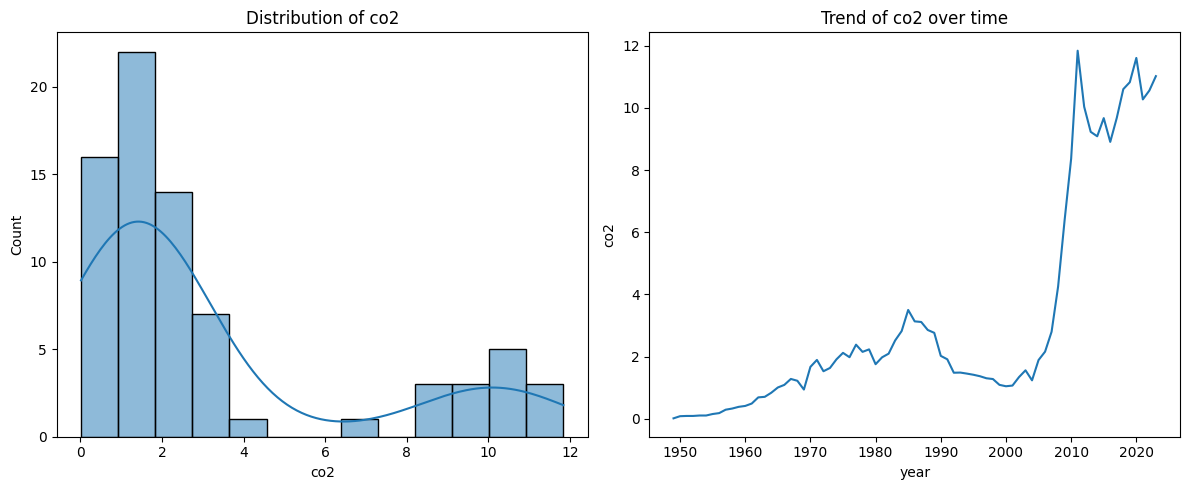

Skewness of co2: 1.3859
Recommendation: Consider log transformation of co2 due to high skewness

===== CORRELATION ANALYSIS =====


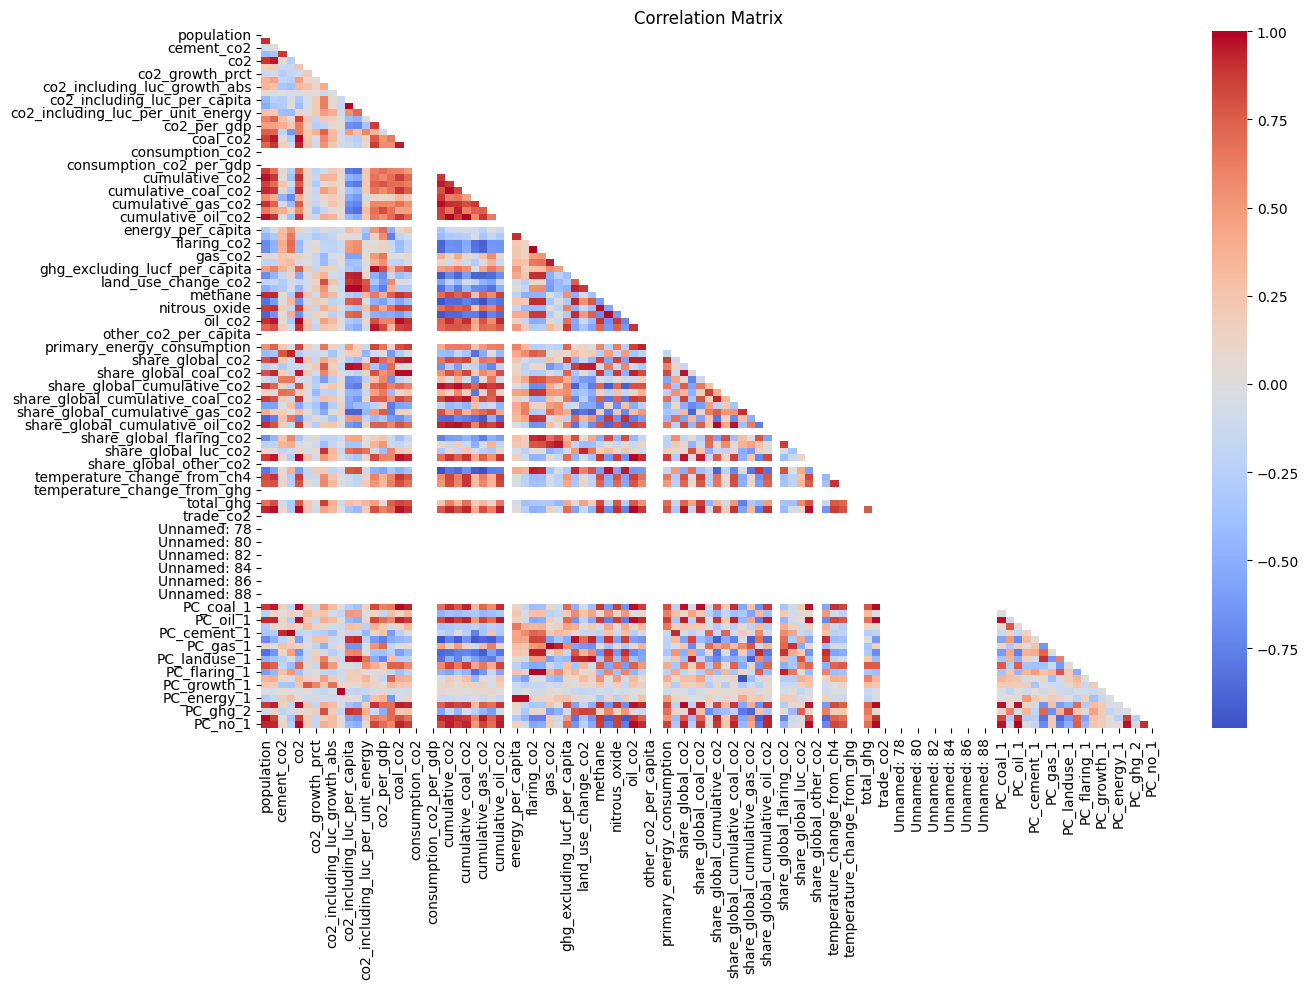

Top correlations with co2:
oil_co2                     0.993456
total_ghg_excluding_lucf    0.992642
share_global_oil_co2        0.988691
PC_coal_1                   0.984353
PC_ghg_1                    0.979637
Name: co2, dtype: float64

Strongly correlated feature pairs (potential multicollinearity):
                                Feature 1                 Feature 2  \
785                              PC_oil_1                   PC_no_1   
272                        cumulative_co2        cumulative_oil_co2   
467                flaring_co2_per_capita              PC_flaring_1   
453                           flaring_co2              PC_flaring_1   
438                           flaring_co2    flaring_co2_per_capita   
..                                    ...                       ...   
565                         nitrous_oxide  total_ghg_excluding_lucf   
787                           PC_cement_2              PC_landuse_1   
326          cumulative_co2_including_luc              PC

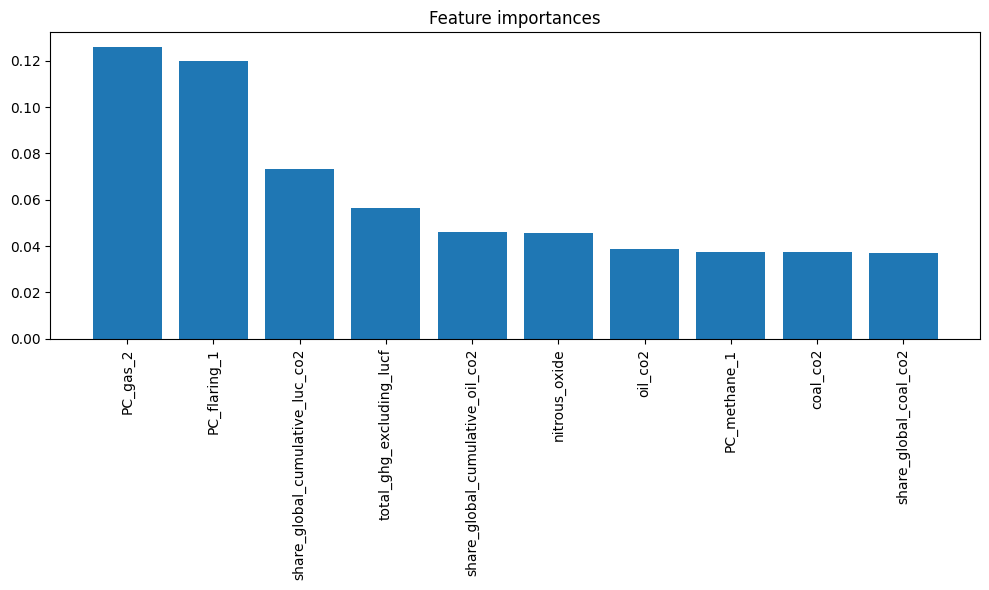


===== SCALING ASSESSMENT =====
Features that may need scaling:
                                        min           max         range
gdp                            7.919857e+09  7.308571e+10  6.516585e+10
population                     7.356890e+06  4.145476e+07  3.409787e+07
energy_per_capita              2.042310e+02  3.139185e+03  2.934954e+03
co2_including_luc_growth_prct -2.289960e+02  1.342009e+03  1.571005e+03
cumulative_co2_including_luc   6.250000e+00  6.005950e+02  5.943450e+02
co2_growth_prct               -2.678400e+01  4.750000e+02  5.017840e+02
cumulative_luc_co2             5.195030e+02  8.770220e+02  3.575190e+02
cumulative_co2                 1.500000e-02  2.368410e+02  2.368260e+02
cumulative_oil_co2             0.000000e+00  1.447850e+02  1.447850e+02
cumulative_coal_co2            1.500000e-02  6.316100e+01  6.314600e+01
primary_energy_consumption     4.428000e+00  4.200500e+01  3.757700e+01
co2_including_luc             -2.575000e+00  2.845200e+01  3.102700e+01


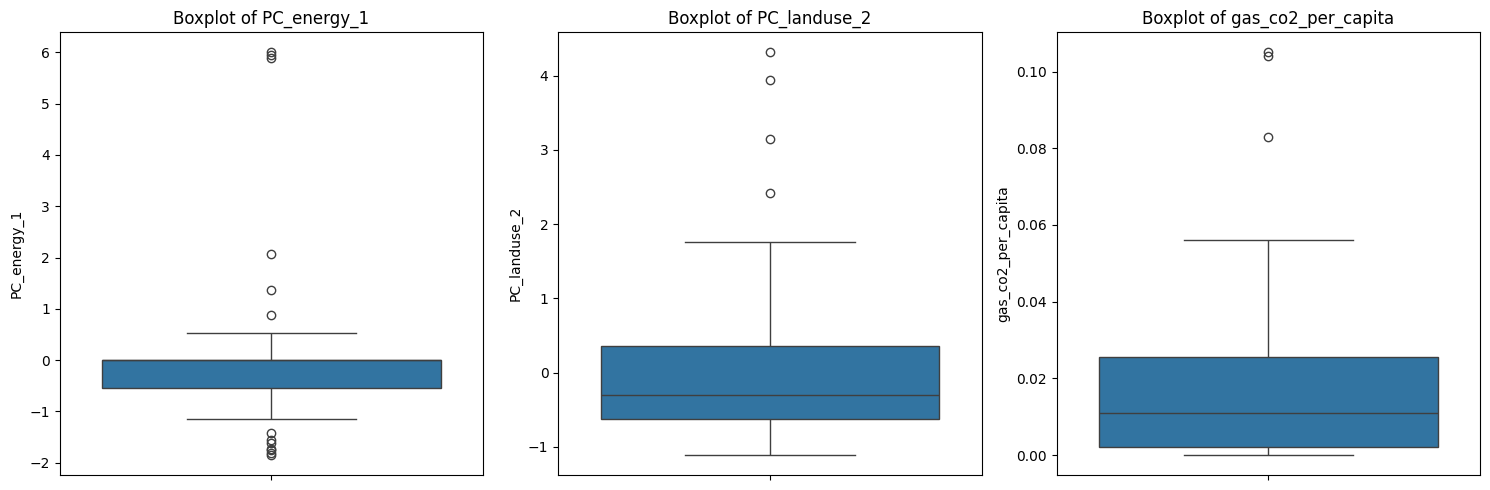


===== SUMMARY AND RECOMMENDATIONS =====
• Consider dropping features with high missing values: co2_including_luc_per_unit_energy, co2_per_unit_energy, consumption_co2, consumption_co2_per_capita, consumption_co2_per_gdp, cumulative_other_co2, energy_per_capita, energy_per_gdp, other_co2_per_capita, other_industry_co2, primary_energy_consumption, share_global_cumulative_other_co2, share_global_other_co2, trade_co2, trade_co2_share, Unnamed: 78, Unnamed: 79, Unnamed: 80, Unnamed: 81, Unnamed: 82, Unnamed: 83, Unnamed: 84, Unnamed: 85, Unnamed: 86, Unnamed: 87, Unnamed: 88, Unnamed: 89
• Address multicollinearity by:
  - Use regularization techniques (Ridge or Lasso regression)
  - Consider dropping one feature from each highly correlated pair
  - Consider creating composite variables or performing dimension reduction
• Focus on top important features: PC_gas_2, PC_flaring_1, share_global_cumulative_luc_co2, total_ghg_excluding_lucf, share_global_cumulative_oil_co2
• Apply appropriate sc

year iso_code  population           gdp  cement_co2  \
0   1949      AFG     7356890           NaN       0.000   
1   1950      AFG     7776182  9.421400e+09       0.000   
2   1951      AFG     7879343  9.692280e+09       0.000   
3   1952      AFG     7987783  1.001733e+10       0.000   
4   1953      AFG     8096703  1.063052e+10       0.000   
..   ...      ...         ...           ...         ...   
70  2019      AFG    37856126  7.308571e+10       0.038   
71  2020      AFG    39068978  7.141771e+10       0.061   
72  2021      AFG    40000411  5.663885e+10       0.016   
73  2022      AFG    40578846  5.330347e+10       0.016   
74  2023      AFG    41454762           NaN       0.016   

    cement_co2_per_capita     co2  co2_growth_abs  co2_growth_prct  \
0                   0.000   0.015             NaN              NaN   
1                   0.000   0.084           0.070          475.000   
2                   0.000   0.092           0.007            8.696   
3                   0.000   0.092           0.000            0.000   
4                   0.000   0.106           0.015           16.000   
..                    ...     ...             ...              ...   
70                  0.001  10.825           0.223            2.106   
71                  0.002  11.606           0.781            7.213   
72                  0.000  10.272          -1.334          -11.495   
73                  0.000  10.558           0.286            2.784   
74                  0.000  11.020           0.462            4.380   

    co2_including_luc  ...  PC_landuse_2  PC_flaring_1  PC_flaring_2  \
0               6.250  ...     -1.108472 -3.314412e-16  5.161637e-16   
1               7.316  ...     -1.009015 -1.496713e-15  1.105484e-15   
2               8.264  ...     -0.884559 -6.014202e-16  2.089795e-15   
3               9.192  ...     -0.716486 -7.438411e-17  5.807584e-16   
4              10.269  ...     -0.543087 -7.200431e-17  1.183418e-15   
..                ...  ...           ...           ...           ...   
70             19.743  ...      2.422137 -1.784130e+00  1.053873e+00   
71             16.833  ...      1.761503 -1.788501e+00  1.126857e+00   
72             22.036  ...      3.147813 -1.792871e+00  1.199841e+00   
73             25.863  ...      3.938709 -1.792871e+00  1.199841e+00   
74             28.452  ...      4.312850 -1.797241e+00  1.272825e+00   

     PC_growth_1   PC_growth_2   PC_energy_1  PC_ghg_1  PC_ghg_2  \
0   3.358923e-16 -5.373658e-17 -5.435357e-16 -2.176309  0.456466   
1   4.190722e+00 -8.786027e-01  1.533955e-16 -2.039847  0.569678   
2   4.300501e-03 -6.638789e-02  1.707377e-16 -2.017324  0.755819   
3  -8.554814e-02 -6.077595e-02  1.707377e-16 -1.999677  0.915244   
4   1.147981e-01 -9.119750e-02  1.707377e-16 -1.968106  1.093298   
..           ...           ...           ...       ...       ...   
70  1.847424e+00 -1.925498e-02 -6.680371e-01  3.323955  0.773092   
71 -4.662360e-01 -8.709661e-02 -8.605522e-01  3.222112  0.597333   
72 -1.374874e-01 -9.080573e-02 -7.199914e-01  3.048747  0.641974   
73  1.100343e+00 -1.200602e-01  1.707377e-16  3.178936  0.762284   
74  8.994611e-01 -1.225450e-01  1.707377e-16  3.244295  0.812135   

    PC_methane_1   PC_no_1  
0      -1.720208 -2.619553  
1      -1.580914 -2.448206  
2      -1.563101 -2.446810  
3      -1.543652 -2.400631  
4      -1.527258 -2.365848  
..           ...       ...  
70      2.268704  4.418721  
71      2.234143  4.985767  
72      2.351788  4.698701  
73      2.382437  4.820406  
74      2.393196  4.988137  

[75 rows x 109 columns]

In [7]:
analyze_country_data(csv_file)

## Data Preprocessing for Time Series Forecasting

### Initial Data Cleanup
- Handled missing values in the CO2 emissions dataset
- Normalized country names and codes for consistency
- Filtered relevant time periods (complete years with sufficient data coverage)
- Converted data types and standardized units where necessary

### Dimensionality Reduction
- **Principal Component Analysis (PCA)**:
  - Applied PCA to reduce dimensionality of the feature space
  - Retained principal components explaining 95% of variance
  - Helped accumulate the effects of various components of a specific sources of emission.
  - Helped address multicollinearity between economic and emission variables
  - Improved model stability, especially for linear models (LASSO, ElasticNet)
  
### Feature Scaling and Transformation
- Applied log transformation to handle skewed distributions
- Standardized features (z-score normalization) for linear models and neural networks
- Min-max scaling for tree-based models where appropriate

### Train-Test Splitting
- Implemented time series cross-validation with forward-chaining approach
- Created multiple training/validation splits with expanding windows
- Reserved most recent years for final model testing and evaluation

In [8]:
def apply_pca_and_save(csv_file, column_names, target_variable, n_components, source_name,
                      component_prefix='PC'):
    """
    Apply PCA to specified columns in a CSV file and append the new component columns.
    
    Parameters:
    -----------
    csv_file : str
        Path to the CSV file
    column_names : list
        List of column names to use for PCA
    target_variable : str
        Name of the target variable (not used in PCA but kept for reference)
    n_components : int
        Number of principal components to extract
    source_name : str
        Name of the source group (coal, gas, etc.)
    component_prefix : str, optional
        Prefix for the new component columns, defaults to 'PC'
        
    Returns:
    --------
    DataFrame
        The modified DataFrame with new PCA component columns
    """
    try:
        # Read the CSV file
        df = pd.read_csv(csv_file)
        print(f"Loaded CSV with {df.shape[0]} rows and {df.shape[1]} columns")
        
        # Check if all column names exist in the dataframe
        missing_columns = [col for col in column_names if col not in df.columns]
        if missing_columns:
            raise ValueError(f"Columns not found in the CSV: {missing_columns}")
        
        # Extract the columns for PCA
        X = df[column_names].copy()
        
        # Handle missing values (important for PCA)
        X = X.fillna(X.mean())
        
        # Standardize the data
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # Apply PCA
        pca = PCA(n_components=n_components)
        X_pca = pca.fit_transform(X_scaled)
        
        # Create column names for the components
        pca_column_names = [f"{component_prefix}_{source_name}_{i+1}" for i in range(n_components)]
        
        # Create a dataframe with the PCA components
        pca_df = pd.DataFrame(X_pca, columns=pca_column_names)
        
        # Add the PCA components to the original dataframe
        df = pd.concat([df, pca_df], axis=1)
        
        # Calculate and display explained variance
        explained_variance = pca.explained_variance_ratio_
        cumulative_variance = np.cumsum(explained_variance)
        
        print(f"\nPCA Results:")
        for i, (var, cum_var) in enumerate(zip(explained_variance, cumulative_variance)):
            print(f"Component {i+1}: {var:.4f} variance ({cum_var:.4f} cumulative)")
        
        # Show feature importance in components
        components_df = pd.DataFrame(
            pca.components_,
            columns=column_names,
            index=pca_column_names
        )
        print("\nComponent loadings (top 3 features for each component):")
        for component in pca_column_names:
            loadings = components_df.loc[component].abs()
            top_features = loadings.nlargest(3).index.tolist()
            print(f"{component}: {', '.join(top_features)}")
        
        # Save the modified dataframe back to the same file
        df.to_csv(csv_file, index=False)
        print(f"Updated original CSV file {csv_file} with {len(pca_column_names)} new PCA components")
        
        return df
        
    except Exception as e:
        print(f"Error: {str(e)}")
        return None

In [9]:
coal_columns = ['coal_co2', 'coal_co2_per_capita', 'cumulative_coal_co2', 
               'share_global_coal_co2', 'share_global_cumulative_coal_co2']

oil_columns = ['oil_co2', 'oil_co2_per_capita', 'cumulative_oil_co2',
              'share_global_oil_co2', 'share_global_cumulative_oil_co2']
cement_columns = [
    'cement_co2', 
    'cement_co2_per_capita', 
    'cumulative_cement_co2', 
    'share_global_cement_co2', 
    'share_global_cumulative_cement_co2'
]

gas_columns = [
    'gas_co2', 
    'gas_co2_per_capita', 
    'cumulative_gas_co2', 
    'share_global_gas_co2', 
    'share_global_cumulative_gas_co2'
]

land_use_columns = [
    'land_use_change_co2', 
    'land_use_change_co2_per_capita', 
    'cumulative_luc_co2', 
    'share_global_luc_co2', 
    'share_global_cumulative_luc_co2'
]

flaring_columns = [
    'flaring_co2', 
    'flaring_co2_per_capita', 
    'cumulative_flaring_co2', 
    'share_global_flaring_co2',
    'share_global_cumulative_flaring_co2'
]

growth_columns = [
    'co2_growth_abs', 
    'co2_growth_prct', 
    'co2_including_luc_growth_abs', 
    'co2_including_luc_growth_prct'
]


energy_columns = [
    'energy_per_capita', 
    'energy_per_gdp', 
]

ghg_columns = [
    
    'ghg_per_capita',
    'ghg_excluding_lucf_per_capita',
    'total_ghg',
    'total_ghg_excluding_lucf',

]

In [10]:
apply_pca_and_save( csv_file, coal_columns, 'co2', 2, 'coal')
# Oil columns
apply_pca_and_save(csv_file, oil_columns, 'co2', 2, 'oil')

# Cement columns
apply_pca_and_save(csv_file, cement_columns, 'co2', 2, 'cement')

# Gas columns
apply_pca_and_save(csv_file, gas_columns, 'co2', 2, 'gas')

# Land use columns
apply_pca_and_save(csv_file, land_use_columns, 'co2', 2, 'landuse')

# Flaring columns
apply_pca_and_save(csv_file, flaring_columns, 'co2', 2, 'flaring')

# Growth columns
apply_pca_and_save(csv_file, growth_columns, 'co2', 2, 'growth')

# Energy columns
apply_pca_and_save(csv_file, energy_columns, 'co2', 1, 'energy')

# GHG columns
apply_pca_and_save(csv_file, ghg_columns, 'co2', 2, 'ghg')
methane_column =[ 'methane','methane_per_capita']

apply_pca_and_save(csv_file, methane_column, 'co2', 1, 'methane')

no_column=[ 'nitrous_oxide','nitrous_oxide_per_capita']

apply_pca_and_save(csv_file, oil_columns, 'co2', 1, 'no')

Loaded CSV with 75 rows and 109 columns

PCA Results:
Component 1: 0.8947 variance (0.8947 cumulative)
Component 2: 0.0898 variance (0.9845 cumulative)

Component loadings (top 3 features for each component):
PC_coal_1: coal_co2, share_global_coal_co2, coal_co2_per_capita
PC_coal_2: share_global_cumulative_coal_co2, coal_co2_per_capita, cumulative_coal_co2
Error: [Errno 13] Permission denied: 'C:\\Users\\acksh\\OneDrive\\Desktop\\MSAI\\Machine Learning\\Final_project\\data\\databycountry\\Afghanistan.csv'
Loaded CSV with 75 rows and 109 columns

PCA Results:
Component 1: 0.9078 variance (0.9078 cumulative)
Component 2: 0.0597 variance (0.9674 cumulative)

Component loadings (top 3 features for each component):
PC_oil_1: oil_co2, share_global_oil_co2, cumulative_oil_co2
PC_oil_2: oil_co2_per_capita, cumulative_oil_co2, share_global_cumulative_oil_co2
Error: [Errno 13] Permission denied: 'C:\\Users\\acksh\\OneDrive\\Desktop\\MSAI\\Machine Learning\\Final_project\\data\\databycountry\\Afg

In [11]:
def analyze_selected_features(csv_file, feature_columns, target_variable, correlation_threshold=0.8):
    # Load data and select columns
    df = pd.read_csv(csv_file)
    columns_to_use = feature_columns + [target_variable]
    df_selected = df[columns_to_use].copy()
    
    # Drop rows with NaN in target
    df_selected = df_selected.dropna(subset=[target_variable])
    
    # Plot correlation matrix
    plt.figure(figsize=(12, 10))
    corr_matrix = df_selected.corr()
    
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title('Correlation Matrix')
    plt.tight_layout()
    plt.savefig('correlation_matrix.png')
    plt.show()
    
    # Find correlated pairs
    correlated_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) >= correlation_threshold:
                correlated_pairs.append((corr_matrix.columns[i], 
                                        corr_matrix.columns[j], 
                                        corr_matrix.iloc[i, j]))
    
    correlated_df = pd.DataFrame(correlated_pairs, columns=['Feature 1', 'Feature 2', 'Correlation'])
    correlated_df = correlated_df.sort_values('Correlation', ascending=False)
    print("Highly correlated feature pairs:")
    print(correlated_df)
    
    # Calculate VIF
    X = df_selected.drop(columns=[target_variable])
    X = X.fillna(X.mean())  # Handle any remaining NaN values
    
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif_data = vif_data.sort_values("VIF", ascending=False)
    print("\nVariance Inflation Factors:")
    print(vif_data)
    
    # Feature importance
    X = df_selected.drop(columns=[target_variable])
    y = df_selected[target_variable]
    
    X_filled = X.fillna(X.mean())
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_filled, y)
    
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': model.feature_importances_
    })
    feature_importance = feature_importance.sort_values('Importance', ascending=False)
    
    print("\nFeature Importance Ranking:")
    print(feature_importance)
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance)
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.show()
    

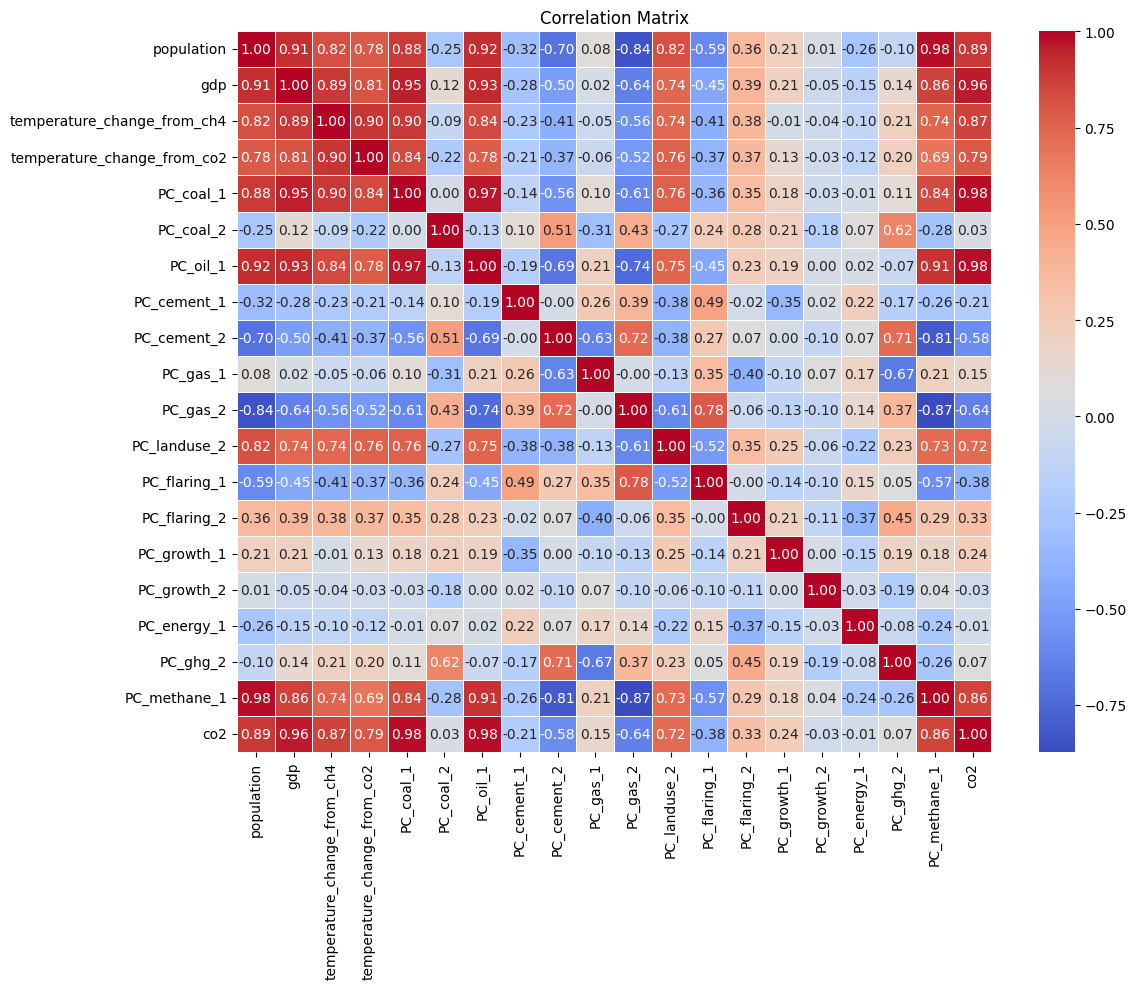

Highly correlated feature pairs:
                      Feature 1                    Feature 2  Correlation
21                    PC_coal_1                          co2     0.984353
6                    population                 PC_methane_1     0.979683
23                     PC_oil_1                          co2     0.979237
19                    PC_coal_1                     PC_oil_1     0.965028
13                          gdp                          co2     0.959742
10                          gdp                    PC_coal_1     0.949730
11                          gdp                     PC_oil_1     0.930153
3                    population                     PC_oil_1     0.924292
0                    population                          gdp     0.912447
22                     PC_oil_1                 PC_methane_1     0.909229
14  temperature_change_from_ch4  temperature_change_from_co2     0.898717
15  temperature_change_from_ch4                    PC_coal_1     0.895310
8    

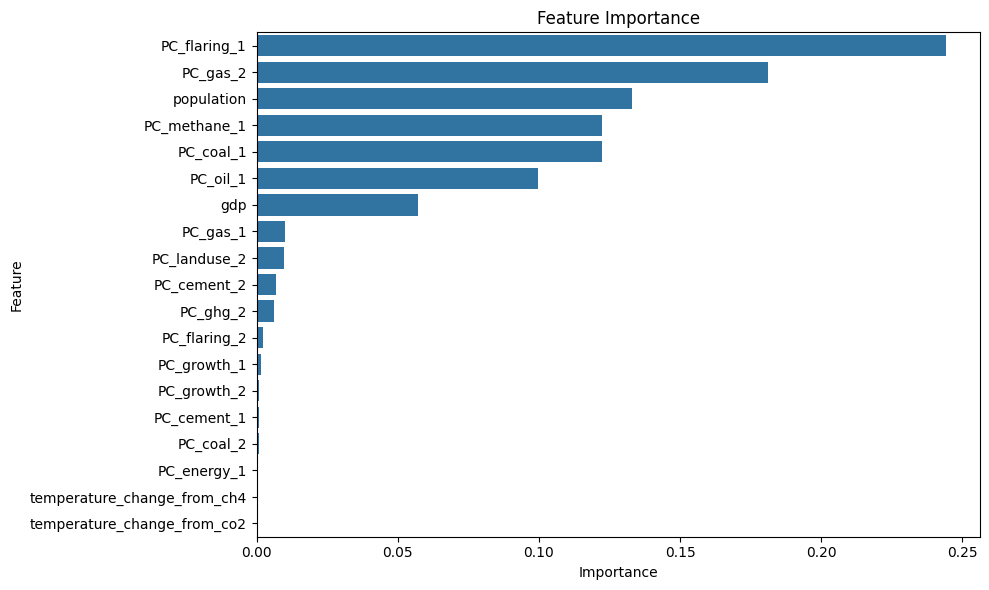

In [12]:
analyze_selected_features(csv_file,[
    'population',
    'gdp',
'temperature_change_from_ch4',
'temperature_change_from_co2',
'PC_coal_1',
'PC_coal_2',
'PC_oil_1',

'PC_cement_1',
'PC_cement_2',
'PC_gas_1',
'PC_gas_2',

'PC_landuse_2',
'PC_flaring_1',
'PC_flaring_2',
'PC_growth_1',
'PC_growth_2',
'PC_energy_1',
'PC_ghg_2',
'PC_methane_1',

]
,target_variable='co2' )

In [13]:


columns_to_use = ['year',
    'gdp',
'PC_coal_1',
'PC_coal_2',
'PC_oil_1',
 'PC_oil_2',
'PC_cement_1',
'PC_cement_2',
'PC_gas_1',
'PC_gas_2',
 
'PC_landuse_2',
'PC_flaring_1',
'PC_flaring_2',
'PC_growth_1',
'PC_growth_2',
'PC_energy_1',
'temperature_change_from_ch4',
'PC_ghg_2',
'PC_methane_1',
'primary_energy_consumption',

'co2_per_capita',
'co2_per_gdp',
'co2_per_unit_energy',
'share_global_co2',

'co2']

df = pd.read_csv(csv_file)

df_final= df[columns_to_use].copy()

print(df_final.isnull().sum())
print(len(df_final))

year                            0
gdp                             2
PC_coal_1                       0
PC_coal_2                       0
PC_oil_1                        0
PC_oil_2                        0
PC_cement_1                     0
PC_cement_2                     0
PC_gas_1                        0
PC_gas_2                        0
PC_landuse_2                    0
PC_flaring_1                    0
PC_flaring_2                    0
PC_growth_1                     0
PC_growth_2                     0
PC_energy_1                     0
temperature_change_from_ch4     0
PC_ghg_2                        0
PC_methane_1                    0
primary_energy_consumption     33
co2_per_capita                  0
co2_per_gdp                     2
co2_per_unit_energy            33
share_global_co2                0
co2                             0
dtype: int64
75


In [14]:
def prepare_time_series_data(df, target_col='co2', lags=2, add_polynomial_year=True, window_size=3):
    """
    Prepare time series data with lag variables and polynomial transformations.
    Uses rolling window imputation for missing values instead of dropping rows.
    
    Parameters:
    -----------
    df : DataFrame
        Input dataframe
    target_col : str
        Target variable column name
    lags : int
        Number of lag terms to include
    add_polynomial_year : bool
        Whether to add polynomial transformations of year
    window_size : int
        Size of rolling window for imputation
        
    Returns:
    --------
    DataFrame
        Prepared dataframe
    """
    # Create a copy to avoid modifying the original
    df_prepared = df.copy().sort_values('year')
    
    # First impute the target variable using rolling window method
    df_prepared[target_col] = rolling_window_impute(df_prepared[target_col], window=window_size)
    
    # Add lag variables
    for i in range(1, lags+1):
        df_prepared[f'{target_col}_lag_{i}'] = df_prepared[target_col].shift(i)
    
#     # Add polynomial year terms if requested
#     if add_polynomial_year:
#         df_prepared['year_squared'] = df_prepared['year']**2
#         df_prepared['year_cubed'] = df_prepared['year']**3
    
    # Log transform the target
    df_prepared[f'log_{target_col}'] = np.log1p(df_prepared[target_col])
    
    # Impute any remaining missing values in all columns
    for col in df_prepared.columns:
        if df_prepared[col].isna().any():
            df_prepared[col] = rolling_window_impute(df_prepared[col], window=window_size)
    
    return df_prepared

def rolling_window_impute(series, window=3):
    """
    Impute missing values using rolling window average.
    
    Parameters:
    -----------
    series : Series
        The pandas Series to impute
    window : int
        Size of the rolling window
        
    Returns:
    --------
    Series
        Imputed series
    """
    imputed = series.copy()
    mask = series.isna()
    
    if mask.any():
        # Create a rolling mean series (ignoring NaNs)
        rolling_mean = series.rolling(window=window, center=True, min_periods=1).mean()
        
        # Fill missing values with rolling mean
        imputed[mask] = rolling_mean[mask]
        
        # If there are still NaN values (e.g., at the start with no prior values)
        # Fill forward and then backward to handle edges
        imputed = imputed.fillna(method='ffill').fillna(method='bfill')
    
    return imputed

## Model Implementation

Hyperparameter tuning and ablation study has been performed for each model.

### Lasso Regression with lag variables

In [15]:
def time_series_regression(df, target_col='co2', test_size=0.2, n_splits=5, 
                                alphas=[0.1, 1.0, 10.0, 100.0], lags=2, 
                                add_polynomial_year=True, use_log_transform=True):
    """
    Perform time series ridge regression with cross-validation.
    
    Parameters:
    -----------
    df : DataFrame
        DataFrame containing features and target variable
    target_col : str
        Name of the target column
    test_size : float
        Proportion of data to use for final testing
    n_splits : int
        Number of splits for time series cross-validation
    alphas : list
        Ridge regularization parameters to test
    lags : int
        Number of lag terms to include
    add_polynomial_year : bool
        Whether to add polynomial transformations of year
    use_log_transform : bool
        Whether to use log transformation of target
    
    Returns:
    --------
    dict
        Dictionary containing model, predictions, and evaluation metrics
    """
    # Prepare time series data
    df_prepared = prepare_time_series_data(df, target_col, lags, add_polynomial_year)
    
    # Set the transformed target variable if requested
    if use_log_transform:
        transformed_target = f'log_{target_col}'
    else:
        transformed_target = target_col
    
    # Sort data by year to ensure chronological order
    df_prepared = df_prepared.sort_values('year')
    
    # Separate features and target
    X = df_prepared.drop(columns=[target_col, transformed_target, 'year'])
    y = df_prepared[transformed_target]
    years = df_prepared['year']
    
    # Create train/test split based on the most recent 'test_years' years
    unique_years = sorted(years.unique())
    test_years= 10
    cutoff_year = unique_years[-test_years]
    
    # Split based on years
    train_mask = years < cutoff_year
    test_mask = years >= cutoff_year
    
    X_train, X_test = X[train_mask], X[test_mask]
    y_train, y_test = y[train_mask], y[test_mask]
    train_years = years[train_mask]
    test_years = years[test_mask]
    
    print(f"Training data: {train_years.min()} to {train_years.max()}")
    print(f"Testing data: {test_years.min()} to {test_years.max()}")
    
    # Time series cross-validation
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    # Create pipeline with imputation, scaling and ridge regression
    pipeline = Pipeline([

        ('scaler', StandardScaler()),
        ('lasso', Lasso(max_iter=10000))
    ])
    
    # Cross-validation for alpha selection
    cv_scores = []
    for alpha in alphas:
        fold_scores = []
        pipeline.set_params(lasso__alpha=alpha)
        
        for train_idx, val_idx in tscv.split(X_train):
            # Train on each fold
            X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
            
            pipeline.fit(X_fold_train, y_fold_train)
            y_fold_pred = pipeline.predict(X_fold_val)
            
            # Calculate RMSE for this fold
            rmse = np.sqrt(mean_squared_error(y_fold_val, y_fold_pred))
            fold_scores.append(rmse)
        
        # Average score across folds
        avg_rmse = np.mean(fold_scores)
        cv_scores.append(avg_rmse)
        print(f"Alpha = {alpha}, Average RMSE = {avg_rmse:.4f}")
        
    print(cv_scores)
    
    # Find best alpha
    best_alpha_idx = np.argmin(cv_scores)
    best_alpha = alphas[best_alpha_idx]
    print(f"Best alpha: {best_alpha}")
    
    # Train final model with best alpha
    final_pipeline = Pipeline([

        ('scaler', StandardScaler()),
        ('lasso', Lasso(alpha=best_alpha,max_iter=10000))
    ])
    final_pipeline.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = final_pipeline.predict(X_train)
    y_test_pred = final_pipeline.predict(X_test)
    
    # Transform predictions back to original scale if using log transform
    if use_log_transform:
        y_train_orig = np.expm1(y_train)
        y_test_orig = np.expm1(y_test)
        y_train_pred_orig = np.expm1(y_train_pred)
        y_test_pred_orig = np.expm1(y_test_pred)
    else:
        y_train_orig = y_train
        y_test_orig = y_test
        y_train_pred_orig = y_train_pred
        y_test_pred_orig = y_test_pred
    
    # Calculate metrics in transformed space
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Calculate metrics in original space
    train_rmse_orig = np.sqrt(mean_squared_error(y_train_orig, y_train_pred_orig))
    test_rmse_orig = np.sqrt(mean_squared_error(y_test_orig, y_test_pred_orig))
    train_r2_orig = r2_score(y_train_orig, y_train_pred_orig)
    test_r2_orig = r2_score(y_test_orig, y_test_pred_orig)
    
    print(f"\nMetrics in {'log' if use_log_transform else 'original'} space:")
    print(f"Training RMSE: {train_rmse:.4f}")
    print(f"Testing RMSE: {test_rmse:.4f}")
    print(f"Training R²: {train_r2:.4f}")
    print(f"Testing R²: {test_r2:.4f}")
    
    print(f"\nMetrics in original CO2 space:")
    print(f"Training RMSE: {train_rmse_orig:.4f}")
    print(f"Testing RMSE: {test_rmse_orig:.4f}")
    print(f"Training R²: {train_r2_orig:.4f}")
    print(f"Testing R²: {test_r2_orig:.4f}")
    
    # Get feature importances (coefficient magnitudes)
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Coefficient': np.abs(final_pipeline.named_steps['lasso'].coef_)
    }).sort_values('Coefficient', ascending=False)
    
    print("\nFeature Importance (by coefficient magnitude):")
    print(feature_importance.head(10))
    
    # Visualize results (in original space)
    plt.figure(figsize=(14, 7))
    
    plt.subplot(121)
    plt.plot(train_years, y_train_orig, 'b-', label='Actual')
    plt.plot(train_years, y_train_pred_orig, 'r--', label='Predicted')
    plt.title('Training Data: Actual vs Predicted CO2')
    plt.xlabel('Year')
    plt.ylabel('CO2 Emissions')
    plt.legend()
    
    plt.subplot(122)
    plt.plot(test_years, y_test_orig, 'b-', label='Actual')
    plt.plot(test_years, y_test_pred_orig, 'r--', label='Predicted')
    plt.title('Testing Data: Actual vs Predicted CO2')
    plt.xlabel('Year')
    plt.ylabel('CO2 Emissions')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Plot alpha vs RMSE
    plt.figure(figsize=(10, 6))
    plt.plot(alphas, cv_scores, 'o-')
    plt.xscale('log')
    plt.xlabel('Alpha (log scale)')
    plt.ylabel('Average RMSE')
    plt.title('Alpha Parameter Selection')
    plt.axvline(best_alpha, color='r', linestyle='--', label=f'Best Alpha = {best_alpha}')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Create result dictionary
    results = {
        'model': final_pipeline,
        'best_alpha': best_alpha,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_rmse_orig': train_rmse_orig,
        'test_rmse_orig': test_rmse_orig,
        'train_r2_orig': train_r2_orig,
        'test_r2_orig': test_r2_orig,
        'feature_importance': feature_importance,
        'y_train_pred': y_train_pred,
        'y_test_pred': y_test_pred,
        'y_train_pred_orig': y_train_pred_orig,
        'y_test_pred_orig': y_test_pred_orig,
        'train_years': train_years,
        'test_years': test_years,
        'use_log_transform': use_log_transform,
        'X_columns': list(X.columns)
    }
    
    return results

def forecast_co2_emissions(model, df, years_to_forecast=5, 
                          target_col='co2', use_log_transform=True,
                          window_size=3):
    """
    Forecast CO2 emissions for future years using a more streamlined approach.
    Uses rolling window imputation for any missing historical values.
    
    Parameters:
    -----------
    model : Pipeline
        Trained regression model pipeline
    df : DataFrame
        Original dataframe with historical data
    years_to_forecast : int
        Number of years to forecast
    target_col : str
        Target variable name
    use_log_transform : bool
        Whether log transformation was used
    window_size : int
        Size of rolling window for imputation
    
    Returns:
    --------
    DataFrame
        Forecasted emissions by year
    """

    
    # Sort dataframe by year
    df_sorted = df.copy().sort_values('year')
    
    # Impute any missing values in the historical data using rolling window
    for col in df_sorted.columns:
        if df_sorted[col].isna().any():
            df_sorted[col] = rolling_window_impute(df_sorted[col], window=window_size)
    
    # Get the last year in the data
    last_year = df_sorted['year'].max()
    
    # Get the feature columns used in the model
    feature_names = model.feature_names_in_
    
    # Create a dataframe to store forecasts
    forecast_years = range(int(last_year) + 1, int(last_year) + years_to_forecast + 1)
    forecast_df = pd.DataFrame({'year': forecast_years})
    forecast_values = []
    
    # Get the most recent values to use for prediction
    last_row = df_sorted.iloc[-1].copy()
    prev_co2 = last_row[target_col]
    
    # For each future year
    for i, year in enumerate(forecast_years):
        # Create prediction input with the year and latest known values
        pred_input = {}
        
        # Add the year information
        pred_input['year'] = year
        pred_input['year_squared'] = year**2
        pred_input['year_cubed'] = year**3
        
        # Add lag terms (use previous predictions once available)
        if i == 0:
            # First forecast year - use the last known CO2 value
            pred_input[f'{target_col}_lag1'] = prev_co2
            if f'{target_col}_lag2' in feature_names:
                pred_input[f'{target_col}_lag2'] = df_sorted[target_col].iloc[-2]
        elif i == 1:
            # Second forecast year - use the first prediction and last known CO2
            pred_input[f'{target_col}_lag1'] = forecast_values[0]
            pred_input[f'{target_col}_lag2'] = prev_co2
        else:
            # Later forecast years - use previous predictions
            pred_input[f'{target_col}_lag1'] = forecast_values[i-1]
            pred_input[f'{target_col}_lag2'] = forecast_values[i-2]
            
        # For all other features, use the last known values
        for feature in feature_names:
            if feature not in pred_input and feature not in [f'{target_col}_lag1', f'{target_col}_lag2']:
                if feature in last_row.index:
                    pred_input[feature] = last_row[feature]
                else:
                    # Use column mean if feature not in last row
                    pred_input[feature] = df_sorted[feature].mean() if feature in df_sorted.columns else 0
        
        # Create a DataFrame with the prediction input
        pred_df = pd.DataFrame([pred_input])
        
        # Ensure all required features are present and in the right order
        pred_features = pred_df[feature_names].copy()
        
        # Make the prediction
        try:
            # Predict CO2 value
            prediction = model.predict(pred_features)[0]
            
            # Convert back from log scale if needed
            if use_log_transform:
                co2_forecast = np.expm1(prediction)
            else:
                co2_forecast = prediction
                
            forecast_values.append(co2_forecast)
            
        except Exception as e:
            print(f"Error predicting for year {year}: {str(e)}")
            # Use trend continuation as fallback
            if i > 0:
                # Use previous prediction with same growth rate
                prev_growth = forecast_values[i-1] / (forecast_values[i-2] if i > 1 else prev_co2)
                co2_forecast = forecast_values[i-1] * prev_growth
            else:
                # Use last observed value
                co2_forecast = prev_co2
                
            forecast_values.append(co2_forecast)
    
    # Add forecasts to the result dataframe
    forecast_df[target_col] = forecast_values
    
    return forecast_df

Training data: 1949 to 2013
Testing data: 2014 to 2023
Alpha = 0.0001, Average RMSE = 1857138159245.3718
Alpha = 0.001, Average RMSE = 0.2065
Alpha = 0.01, Average RMSE = 0.1077
Alpha = 0.1, Average RMSE = 0.2133
Alpha = 1.0, Average RMSE = 0.6216
Alpha = 10.0, Average RMSE = 0.6216
Alpha = 100.0, Average RMSE = 0.6216
Alpha = 1000.0, Average RMSE = 0.6216
Alpha = 10000.0, Average RMSE = 0.6216
[1857138159245.3718, 0.20650592267844076, 0.10765106077631162, 0.2133499133659688, 0.6215906728339106, 0.6215906728339106, 0.6215906728339106, 0.6215906728339106, 0.6215906728339106]
Best alpha: 0.01

Metrics in log space:
Training RMSE: 0.0437
Testing RMSE: 0.0892
Training R²: 0.9939
Testing R²: -0.4495

Metrics in original CO2 space:
Training RMSE: 0.2436
Testing RMSE: 1.0514
Training R²: 0.9888
Testing R²: -0.6259

Feature Importance (by coefficient magnitude):
                Feature  Coefficient
19       co2_per_capita     0.160722
0                   gdp     0.153986
20          co2_per_gd

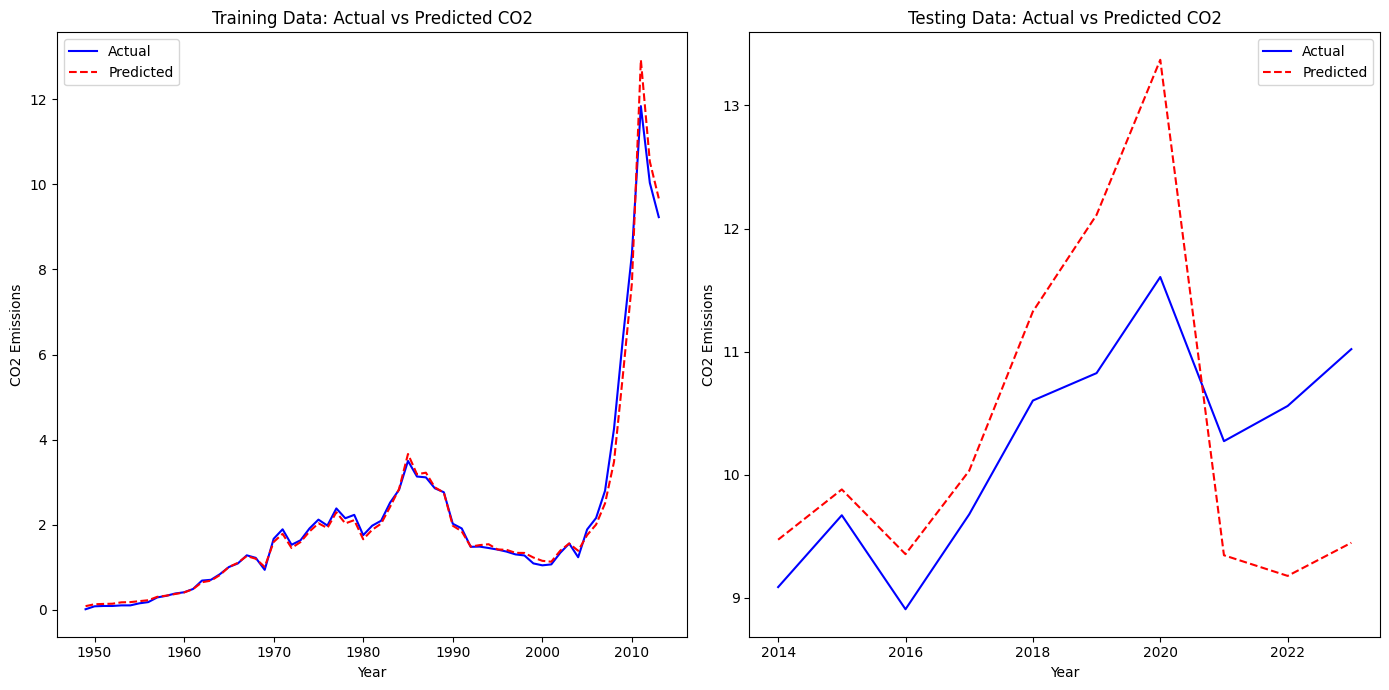

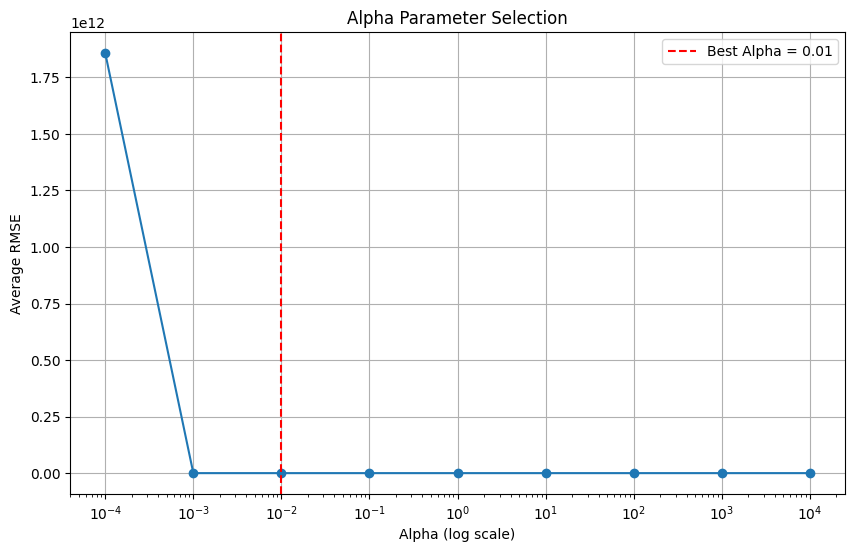

   year       co2
0  2024  9.446357
1  2025  9.446357
2  2026  9.446357
3  2027  9.446357
4  2028  9.446357
5  2029  9.446357
6  2030  9.446357
7  2031  9.446357
8  2032  9.446357
9  2033  9.446357


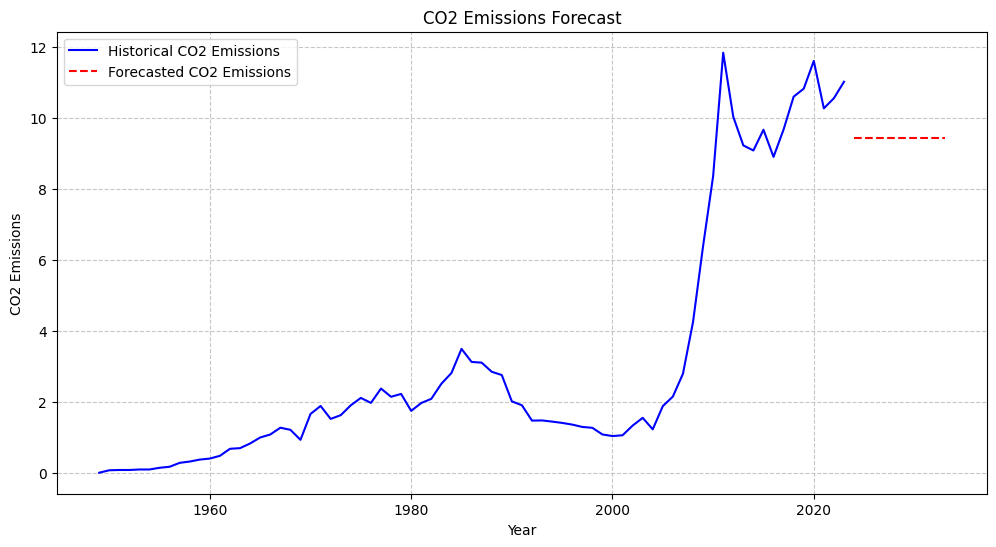

In [16]:
results = time_series_regression(df_final, target_col='co2', 
                                      alphas=[0.0001,0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0,10000.0],
                                      lags=2, add_polynomial_year=True, use_log_transform=True)

forecast = forecast_co2_emissions(results['model'],df_final,years_to_forecast=10,target_col='co2')

# Display the forecasts
print(forecast)

# Visualize historical data and forecasts
plt.figure(figsize=(12, 6))
plt.plot(df_final['year'], df_final['co2'], 'b-', label='Historical CO2 Emissions')
plt.plot(forecast['year'], forecast['co2'], 'r--', label='Forecasted CO2 Emissions')
plt.title('CO2 Emissions Forecast')
plt.xlabel('Year')
plt.ylabel('CO2 Emissions')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

### Lasso with lag variables and Moving average.

In [17]:
lag_periods = 10
target='co2'
df_ma = prepare_time_series_data(df_final,target,lag_periods)
df_ma.isnull().sum()

year                           0
gdp                            0
PC_coal_1                      0
PC_coal_2                      0
PC_oil_1                       0
PC_oil_2                       0
PC_cement_1                    0
PC_cement_2                    0
PC_gas_1                       0
PC_gas_2                       0
PC_landuse_2                   0
PC_flaring_1                   0
PC_flaring_2                   0
PC_growth_1                    0
PC_growth_2                    0
PC_energy_1                    0
temperature_change_from_ch4    0
PC_ghg_2                       0
PC_methane_1                   0
primary_energy_consumption     0
co2_per_capita                 0
co2_per_gdp                    0
co2_per_unit_energy            0
share_global_co2               0
co2                            0
co2_lag_1                      0
co2_lag_2                      0
co2_lag_3                      0
co2_lag_4                      0
co2_lag_5                      0
co2_lag_6 

In [18]:
def add_moving_average_features(dataframe, variable, windows):
    for window in windows:
        dataframe[f'{variable}_ma_{window}'] = dataframe[variable].rolling(window=window).mean()
    return dataframe

# Add moving averages with different window sizes
ma_windows = [2, 3, 5]
df_ma = add_moving_average_features(df_ma, target, ma_windows)

df_ma=df_ma.dropna()
df_ma.isnull().sum()

year                           0
gdp                            0
PC_coal_1                      0
PC_coal_2                      0
PC_oil_1                       0
PC_oil_2                       0
PC_cement_1                    0
PC_cement_2                    0
PC_gas_1                       0
PC_gas_2                       0
PC_landuse_2                   0
PC_flaring_1                   0
PC_flaring_2                   0
PC_growth_1                    0
PC_growth_2                    0
PC_energy_1                    0
temperature_change_from_ch4    0
PC_ghg_2                       0
PC_methane_1                   0
primary_energy_consumption     0
co2_per_capita                 0
co2_per_gdp                    0
co2_per_unit_energy            0
share_global_co2               0
co2                            0
co2_lag_1                      0
co2_lag_2                      0
co2_lag_3                      0
co2_lag_4                      0
co2_lag_5                      0
co2_lag_6 

Starting extended grid search for alpha parameter...
Fitting 5 folds for each of 15 candidates, totalling 75 fits

Top 10 alpha values:
Alpha: 0.0000100000, Test MSE: 1.0907, Train MSE: 0.0002
Alpha: 0.0000500000, Test MSE: 1.5188, Train MSE: 0.0003
Alpha: 0.0001000000, Test MSE: 1.7561, Train MSE: 0.0004
Alpha: 0.0005000000, Test MSE: 2.3123, Train MSE: 0.0007
Alpha: 0.0010000000, Test MSE: 2.4400, Train MSE: 0.0011
Alpha: 0.0050000000, Test MSE: 2.8254, Train MSE: 0.0034
Alpha: 0.0100000000, Test MSE: 3.1030, Train MSE: 0.0052
Alpha: 0.0500000000, Test MSE: 3.6625, Train MSE: 0.0149
Alpha: 0.1000000000, Test MSE: 4.0490, Train MSE: 0.0311
Alpha: 0.5000000000, Test MSE: 8.9947, Train MSE: 0.3806


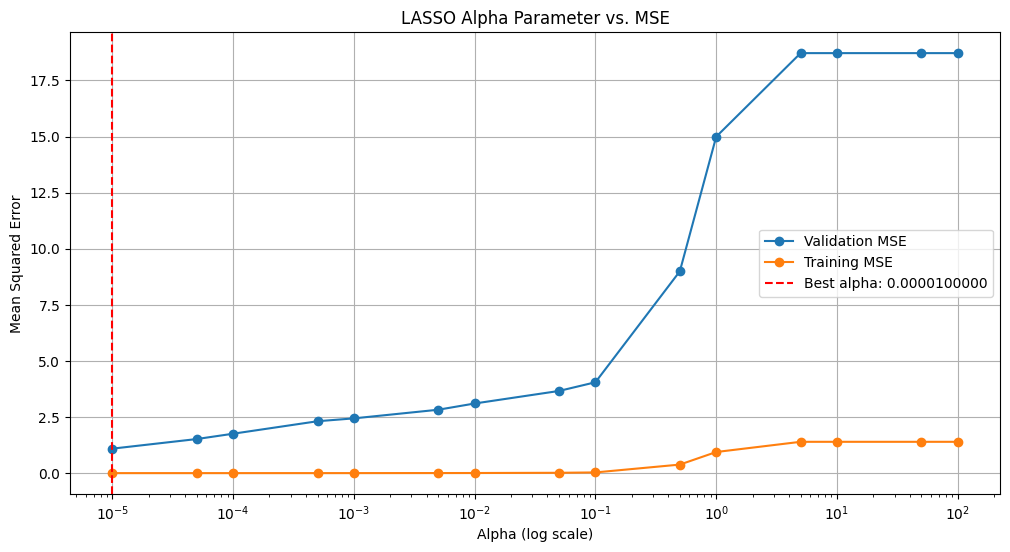


Best alpha parameter: 0.0000100000

Feature importance (top 15 features):
                       Feature  Coefficient  Abs_Coefficient
34                    co2_ma_2     1.577151         1.577151
35                    co2_ma_3     1.300607         1.300607
3                     PC_oil_1     0.984169         0.984169
1                    PC_coal_1     0.884278         0.884278
23                   co2_lag_1    -0.794726         0.794726
18  primary_energy_consumption     0.489765         0.489765
0                          gdp    -0.450441         0.450441
17                PC_methane_1     0.341226         0.341226
19              co2_per_capita    -0.336047         0.336047
24                   co2_lag_2    -0.320297         0.320297
32                  co2_lag_10    -0.229921         0.229921
31                   co2_lag_9     0.221613         0.221613
14                 PC_energy_1    -0.220379         0.220379
33                     log_co2     0.208687         0.208687
6         

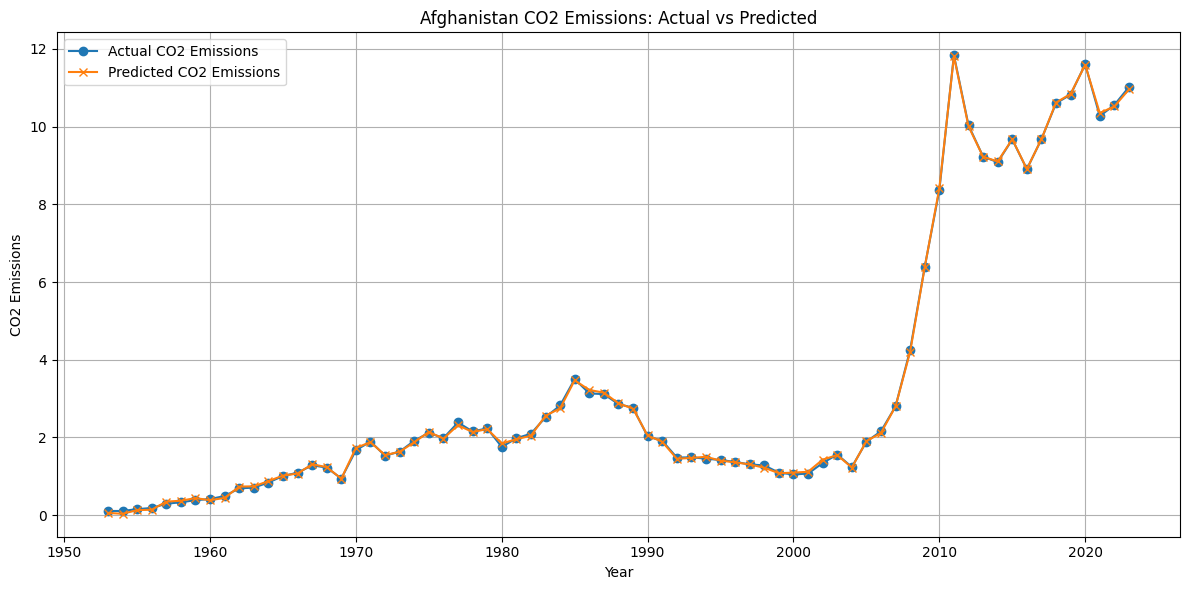

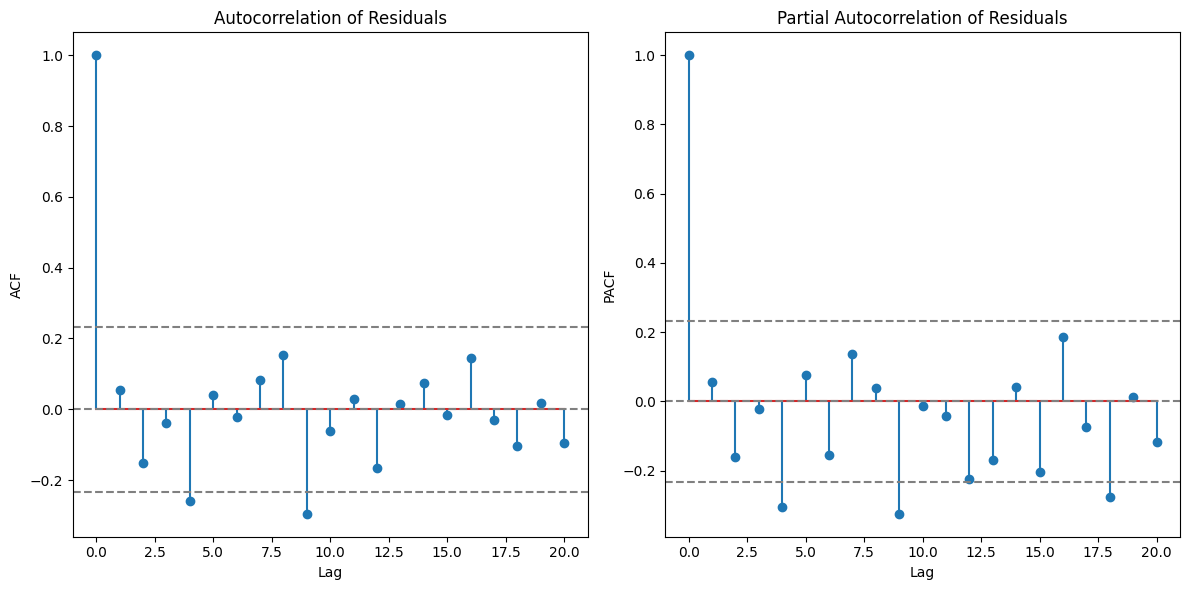


Future CO2 Emission Forecasts:
Year 2024: 10.9580
Year 2025: 11.1016
Year 2026: 10.9720
Year 2027: 11.1111
Year 2028: 11.1842
Year 2029: 11.1817
Year 2030: 11.2075
Year 2031: 11.0098
Year 2032: 11.1203
Year 2033: 11.1488

Training/Testing Performance Metrics:
Training MSE: 0.0000, RMSE: 0.0015, R²: 1.0000
Testing MSE: 0.0103, RMSE: 0.1015, R²: 0.9942


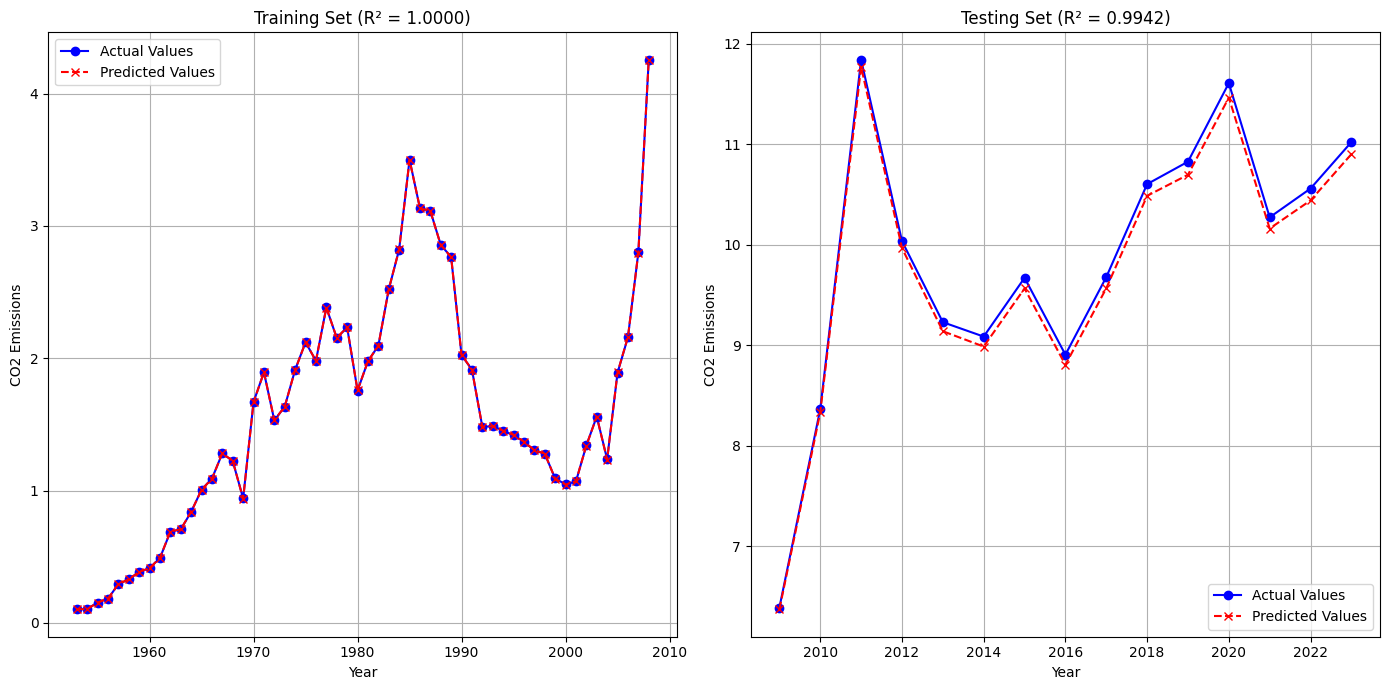

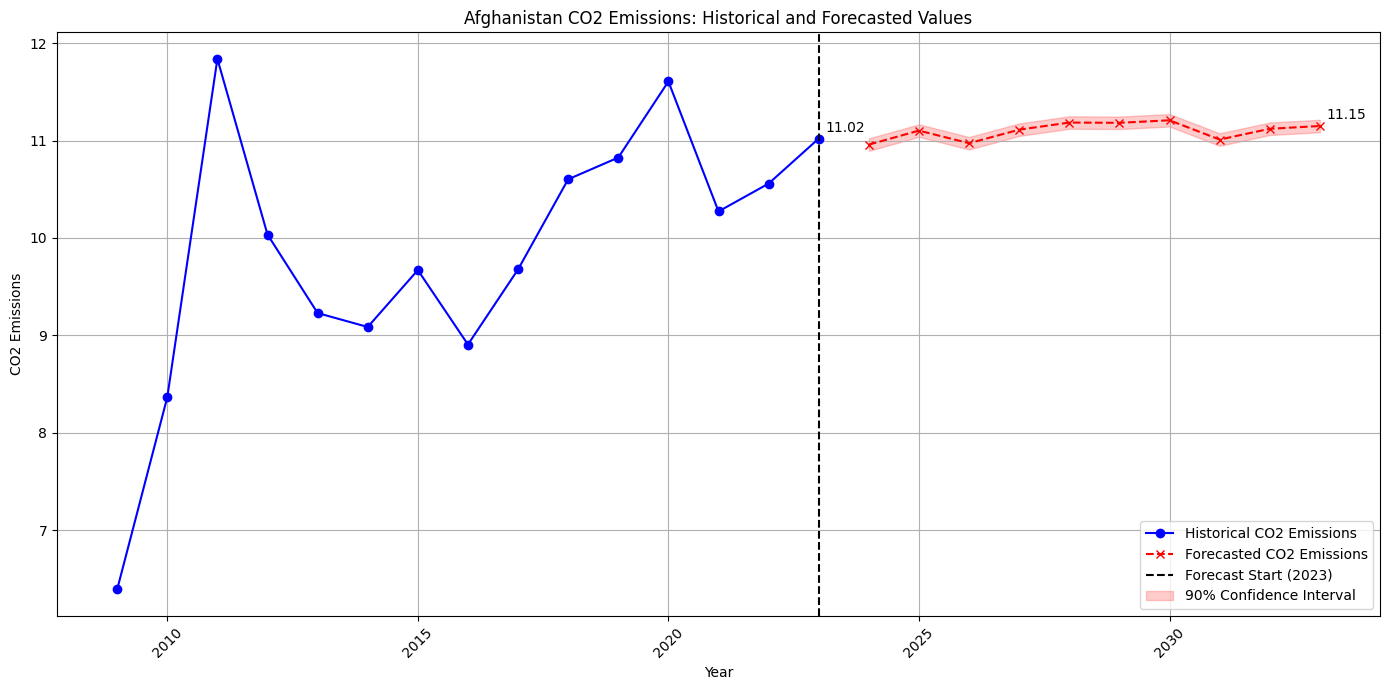


Forecast Analysis:
Forecast period: 2024 to 2033 (10 years)
Starting CO2 emissions: 10.9580
Ending CO2 emissions: 11.1488
Overall change: 0.1909 (1.74%)
Average annual change: 0.0191


In [19]:
# Create features and target arrays
X = df_ma.drop(target, axis=1)
y = df_ma[target]

# Use year for indexing but remove from features
X_year = X['year']
X = X.drop('year', axis=1)

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# EXTENDED Grid Search: Use a much wider range of alpha values
param_grid = {
    'alpha': [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]
}

# Set additional parameters for the Lasso model
lasso = Lasso(
    max_iter=10000,       # Increase max iterations to ensure convergence
    random_state=42,
    tol=1e-4,             # Tolerance for optimization
    selection='random',   # Can use 'random' for faster computation with large datasets
    warm_start=True       # Use warm start to speed up fitting with multiple alphas
)

print("Starting extended grid search for alpha parameter...")
grid_search = GridSearchCV(
    estimator=lasso, 
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,            # Use all available cores
    verbose=2,            # Show progress
    return_train_score=True  # Return training scores for analysis
)

grid_search.fit(X_scaled, y)

# Print all tested alphas and their corresponding scores for analysis
results = pd.DataFrame(grid_search.cv_results_)
results = results.sort_values(by='rank_test_score')
print("\nTop 10 alpha values:")
for i in range(min(10, len(results))):
    row = results.iloc[i]
    print(f"Alpha: {row['param_alpha']:.10f}, "
          f"Test MSE: {-row['mean_test_score']:.4f}, "
          f"Train MSE: {-row['mean_train_score']:.4f}")

# Visualize alpha vs. MSE to see the performance trend
plt.figure(figsize=(12, 6))
plt.semilogx(results['param_alpha'], -results['mean_test_score'], 'o-', label='Validation MSE')
plt.semilogx(results['param_alpha'], -results['mean_train_score'], 'o-', label='Training MSE')
plt.axvline(x=grid_search.best_params_['alpha'], color='r', linestyle='--', label=f"Best alpha: {grid_search.best_params_['alpha']:.10f}")
plt.xlabel('Alpha (log scale)')
plt.ylabel('Mean Squared Error')
plt.title('LASSO Alpha Parameter vs. MSE')
plt.legend()
plt.grid(True)
# plt.savefig('afghanistan_co2_alpha_tuning.png')
plt.show()

# Best parameters
print(f"\nBest alpha parameter: {grid_search.best_params_['alpha']:.10f}")
best_lasso = grid_search.best_estimator_

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns, 
    'Coefficient': best_lasso.coef_
})
# Sort by absolute coefficient value to see most important features
feature_importance['Abs_Coefficient'] = abs(feature_importance['Coefficient'])
feature_importance = feature_importance.sort_values(by='Abs_Coefficient', ascending=False)
print("\nFeature importance (top 15 features):")
print(feature_importance.head(15))

# Count non-zero coefficients
non_zero_coefs = np.sum(best_lasso.coef_ != 0)
print(f"\nNumber of features selected by LASSO: {non_zero_coefs} out of {len(X.columns)}")

# Make predictions
y_pred = best_lasso.predict(X_scaled)

# Calculate performance metrics
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y, y_pred)

print(f"\nModel Performance:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R-squared: {r2:.4f}")

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(X_year, y, label='Actual CO2 Emissions', marker='o')
plt.plot(X_year, y_pred, label='Predicted CO2 Emissions', marker='x')
plt.xlabel('Year')
plt.ylabel('CO2 Emissions')
plt.title('Afghanistan CO2 Emissions: Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.savefig('afghanistan_co2_lasso_prediction.png')
plt.show()

# Plot the autocorrelation function of residuals to check model adequacy
residuals = y - y_pred
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.stem(acf(residuals, nlags=20))
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(residuals)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(residuals)), linestyle='--', color='gray')
plt.title('Autocorrelation of Residuals')
plt.xlabel('Lag')
plt.ylabel('ACF')

plt.subplot(1, 2, 2)
plt.stem(pacf(residuals, nlags=20))
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(residuals)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(residuals)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation of Residuals')
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.tight_layout()
# plt.savefig('afghanistan_co2_residual_analysis.png')
plt.show()

# Function to forecast future values
def forecast_future(model, data, scaler, periods=5):
    """
    Forecast future values using the trained model
    
    Parameters:
    - model: Trained Lasso model
    - data: DataFrame with the latest data
    - scaler: Fitted StandardScaler
    - periods: Number of periods to forecast
    
    Returns:
    - Forecasted values
    """
    # Copy the latest data
    future_data = data.copy()
    forecasts = []
    
    for i in range(periods):
        # Get the latest row of data
        latest_data = future_data.iloc[-1:].copy()
        
        # Update the year
        next_year = latest_data['year'].values[0] + 1
        latest_data['year'] = next_year
        
        # Get features without the target
        X_forecast = latest_data.drop(target, axis=1)
        X_forecast_year = X_forecast['year']
        X_forecast = X_forecast.drop('year', axis=1)
        
        # Scale the features
        X_forecast_scaled = scaler.transform(X_forecast)
        
        # Make prediction
        forecast = model.predict(X_forecast_scaled)[0]
        forecasts.append((next_year, forecast))
        
        # Update the dataframe with the new prediction for next iteration
        new_row = latest_data.copy()
        new_row[target] = forecast
        
        # Update lag and moving average features
        for lag in range(1, lag_periods + 1):
            lag_col = f'{target}_lag_{lag}'
            if lag == 1:
                new_row[lag_col] = latest_data[target].values[0]
            else:
                prev_lag_col = f'{target}_lag_{lag-1}'
                new_row[lag_col] = latest_data[prev_lag_col].values[0]
        
        # Update moving averages (simplified approach)
        for window in ma_windows:
            ma_col = f'{target}_ma_{window}'
            # This is a simple approximation; a more accurate approach would involve more complex calculations
            recent_values = [forecast] + [future_data[target].iloc[-i] for i in range(1, window)]
            new_row[ma_col] = sum(recent_values) / window
        
        # Append to the future_data DataFrame
        future_data = pd.concat([future_data, new_row], ignore_index=True)
    
    return forecasts, future_data

# Example usage of the forecast function
# Get the latest data
latest_data = df_ma.copy()
future_forecasts, future_data = forecast_future(best_lasso, latest_data, scaler, periods=10)

print("\nFuture CO2 Emission Forecasts:")
for year, forecast in future_forecasts:
    print(f"Year {year}: {forecast:.4f}")

# # Save the model for future use
# import joblib
# joblib.dump(best_lasso, 'afghanistan_co2_lasso_model.pkl')
# joblib.dump(scaler, 'afghanistan_co2_feature_scaler.pkl')
# print("\nModel and scaler saved to disk.")

# ------------------------- NEW CODE STARTS HERE -------------------------
# Split data for training and testing visualization
# Use a simple time-based split for demonstration
split_ratio = 0.8
split_idx = int(len(X) * split_ratio)

X_train = X_scaled[:split_idx]
X_test = X_scaled[split_idx:]
y_train = y[:split_idx]
y_test = y[split_idx:]
years_train = X_year[:split_idx]
years_test = X_year[split_idx:]

# Train the best model on training data
best_lasso_for_split = Lasso(alpha=grid_search.best_params_['alpha'], 
                            max_iter=10000, 
                            random_state=42)
best_lasso_for_split.fit(X_train, y_train)

# Make predictions on both training and test data
y_train_pred = best_lasso_for_split.predict(X_train)
y_test_pred = best_lasso_for_split.predict(X_test)

# Calculate metrics for both sets
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("\nTraining/Testing Performance Metrics:")
print(f"Training MSE: {train_mse:.4f}, RMSE: {np.sqrt(train_mse):.4f}, R²: {train_r2:.4f}")
print(f"Testing MSE: {test_mse:.4f}, RMSE: {np.sqrt(test_mse):.4f}, R²: {test_r2:.4f}")

# Plot training and testing predictions
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(years_train, y_train, 'o-', label='Actual Values', color='blue')
plt.plot(years_train, y_train_pred, 'x--', label='Predicted Values', color='red')
plt.title(f'Training Set (R² = {train_r2:.4f})')
plt.xlabel('Year')
plt.ylabel('CO2 Emissions')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(years_test, y_test, 'o-', label='Actual Values', color='blue')
plt.plot(years_test, y_test_pred, 'x--', label='Predicted Values', color='red')
plt.title(f'Testing Set (R² = {test_r2:.4f})')
plt.xlabel('Year')
plt.ylabel('CO2 Emissions')
plt.grid(True)
plt.legend()

plt.tight_layout()
# plt.savefig('afghanistan_co2_train_test_split.png')
plt.show()

# Create a plot for historical and forecasted values
# Extract forecast years and values
forecast_years = [year for year, _ in future_forecasts]
forecast_values = [forecast for _, forecast in future_forecasts]

# Get the last few years of historical data for context
history_years = X_year[-15:].tolist()  # Last 15 years for context
history_values = y[-15:].tolist()

# Define confidence level (change this value to adjust the confidence interval)
confidence_level = 0.90  # 95% confidence interval

# Z-score mapping for common confidence levels
z_scores = {
    0.50: 0.67,  # 50% confidence interval
    0.68: 1.00,  # 68% confidence interval
    0.80: 1.28,  # 80% confidence interval
    0.90: 1.645, # 90% confidence interval
    0.95: 1.96,  # 95% confidence interval
    0.99: 2.576, # 99% confidence interval
    0.999: 3.291 # 99.9% confidence interval
}

# Get the appropriate z-score for the confidence level
z_score = z_scores.get(confidence_level, 1.96)  # Default to 95% if not found

plt.figure(figsize=(14, 7))
# Plot historical data
plt.plot(history_years, history_values, 'o-', color='blue', label='Historical CO2 Emissions')

# Plot forecasted data
plt.plot(forecast_years, forecast_values, 'x--', color='red', label='Forecasted CO2 Emissions')

# Add vertical line to separate historical from forecast
last_historical_year = history_years[-1]
plt.axvline(x=last_historical_year, color='black', linestyle='--', 
           label=f'Forecast Start ({last_historical_year})')

# Create a confidence interval for forecasts using the selected confidence level
historical_rmse = np.sqrt(mse)
upper_bound = [val + z_score * historical_rmse for val in forecast_values]
lower_bound = [max(0, val - z_score * historical_rmse) for val in forecast_values]  # Ensure no negative values

plt.fill_between(forecast_years, lower_bound, upper_bound, color='red', alpha=0.2, 
                label=f'{confidence_level*100:.0f}% Confidence Interval')

plt.title('Afghanistan CO2 Emissions: Historical and Forecasted Values')
plt.xlabel('Year')
plt.ylabel('CO2 Emissions')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)

# Annotate the last historical and future values
plt.annotate(f'{history_values[-1]:.2f}', 
            xy=(history_years[-1], history_values[-1]),
            xytext=(5, 5), textcoords='offset points')
plt.annotate(f'{forecast_values[-1]:.2f}', 
            xy=(forecast_years[-1], forecast_values[-1]),
            xytext=(5, 5), textcoords='offset points')

plt.tight_layout()
# plt.savefig('afghanistan_co2_forecast.png')
plt.show()

# Calculate forecast trend
first_forecast = forecast_values[0]
last_forecast = forecast_values[-1]
forecast_change_pct = ((last_forecast - first_forecast) / first_forecast) * 100
forecast_period = len(forecast_values)

print(f"\nForecast Analysis:")
print(f"Forecast period: {forecast_years[0]} to {forecast_years[-1]} ({forecast_period} years)")
print(f"Starting CO2 emissions: {first_forecast:.4f}")
print(f"Ending CO2 emissions: {last_forecast:.4f}")
print(f"Overall change: {last_forecast - first_forecast:.4f} ({forecast_change_pct:.2f}%)")
print(f"Average annual change: {(last_forecast - first_forecast) / forecast_period:.4f}")

### Elastic Net implementation with lag variables 

In [20]:
def time_series_elasticnet(df, target_col='co2', test_size=0.2, n_splits=5, 
                          alphas=[0.1, 1.0, 10.0, 100.0], l1_ratios=[0.1, 0.5, 0.7, 0.9], 
                          lags=2, add_polynomial_year=True, use_log_transform=True):
    """
    Perform time series ElasticNet regression with cross-validation.
    
    Parameters:
    -----------
    df : DataFrame
        DataFrame containing features and target variable
    target_col : str
        Name of the target column
    test_size : float
        Proportion of data to use for final testing
    n_splits : int
        Number of splits for time series cross-validation
    alphas : list
        ElasticNet regularization parameters to test
    l1_ratios : list
        ElasticNet L1 ratio parameters to test (1 = Lasso, 0 = Ridge)
    lags : int
        Number of lag terms to include
    add_polynomial_year : bool
        Whether to add polynomial transformations of year
    use_log_transform : bool
        Whether to use log transformation of target
    
    Returns:
    --------
    dict
        Dictionary containing model, predictions, and evaluation metrics
    """
    # Prepare time series data - reuse your existing function
    df_prepared = prepare_time_series_data(df, target_col, lags, add_polynomial_year)
    
    # Set the transformed target variable if requested
    if use_log_transform:
        transformed_target = f'log_{target_col}'
    else:
        transformed_target = target_col
    
    # Sort data by year to ensure chronological order
    df_prepared = df_prepared.sort_values('year')
    
    # Separate features and target
    X = df_prepared.drop(columns=[target_col, transformed_target, 'year'])
    y = df_prepared[transformed_target]
    years = df_prepared['year']
    
    # Create train/test split based on the most recent 'test_years' years
    unique_years = sorted(years.unique())
    test_years = 10
    cutoff_year = unique_years[-test_years]
    
    # Split based on years
    train_mask = years < cutoff_year
    test_mask = years >= cutoff_year
    
    X_train, X_test = X[train_mask], X[test_mask]
    y_train, y_test = y[train_mask], y[test_mask]
    train_years = years[train_mask]
    test_years = years[test_mask]
    
    print(f"Training data: {train_years.min()} to {train_years.max()}")
    print(f"Testing data: {test_years.min()} to {test_years.max()}")
    
    # Time series cross-validation
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    # Create pipeline with scaling and ElasticNet regression
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('elasticnet', ElasticNet(max_iter=10000, random_state=42))
    ])
    
    # Cross-validation for hyperparameter selection
    best_score = float('inf')
    best_params = {'alpha': None, 'l1_ratio': None}
    
    for alpha in alphas:
        for l1_ratio in l1_ratios:
            fold_scores = []
            pipeline.set_params(elasticnet__alpha=alpha, elasticnet__l1_ratio=l1_ratio)
            
            for train_idx, val_idx in tscv.split(X_train):
                # Train on each fold
                X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
                y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
                
                pipeline.fit(X_fold_train, y_fold_train)
                y_fold_pred = pipeline.predict(X_fold_val)
                
                # Calculate RMSE for this fold
                rmse = np.sqrt(mean_squared_error(y_fold_val, y_fold_pred))
                fold_scores.append(rmse)
            
            # Average score across folds
            avg_rmse = np.mean(fold_scores)
            print(f"Alpha = {alpha}, L1 Ratio = {l1_ratio}, Average RMSE = {avg_rmse:.4f}")
            
            if avg_rmse < best_score:
                best_score = avg_rmse
                best_params = {'alpha': alpha, 'l1_ratio': l1_ratio}
    
    print(f"\nBest parameters: Alpha = {best_params['alpha']}, L1 Ratio = {best_params['l1_ratio']}")
    
    # Train final model with best parameters
    final_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('elasticnet', ElasticNet(alpha=best_params['alpha'], 
                                 l1_ratio=best_params['l1_ratio'],
                                 max_iter=10000,
                                 random_state=42))
    ])
    final_pipeline.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = final_pipeline.predict(X_train)
    y_test_pred = final_pipeline.predict(X_test)
    
    # Transform predictions back to original scale if using log transform
    if use_log_transform:
        y_train_orig = np.expm1(y_train)
        y_test_orig = np.expm1(y_test)
        y_train_pred_orig = np.expm1(y_train_pred)
        y_test_pred_orig = np.expm1(y_test_pred)
    else:
        y_train_orig = y_train
        y_test_orig = y_test
        y_train_pred_orig = y_train_pred
        y_test_pred_orig = y_test_pred
    
    # Calculate metrics in transformed space
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Calculate metrics in original space
    train_rmse_orig = np.sqrt(mean_squared_error(y_train_orig, y_train_pred_orig))
    test_rmse_orig = np.sqrt(mean_squared_error(y_test_orig, y_test_pred_orig))
    train_r2_orig = r2_score(y_train_orig, y_train_pred_orig)
    test_r2_orig = r2_score(y_test_orig, y_test_pred_orig)
    
    print(f"\nMetrics in {'log' if use_log_transform else 'original'} space:")
    print(f"Training RMSE: {train_rmse:.4f}")
    print(f"Testing RMSE: {test_rmse:.4f}")
    print(f"Training R²: {train_r2:.4f}")
    print(f"Testing R²: {test_r2:.4f}")
    
    print(f"\nMetrics in original CO2 space:")
    print(f"Training RMSE: {train_rmse_orig:.4f}")
    print(f"Testing RMSE: {test_rmse_orig:.4f}")
    print(f"Training R²: {train_r2_orig:.4f}")
    print(f"Testing R²: {test_r2_orig:.4f}")
    
    # Calculate and display feature importances
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Coefficient': np.abs(final_pipeline.named_steps['elasticnet'].coef_)
    }).sort_values('Coefficient', ascending=False)
    
    print("\nFeature Importance (by coefficient magnitude):")
    print(feature_importance.head(10))
    
    # Visualize actual vs predicted values
    plt.figure(figsize=(14, 7))
    
    plt.subplot(121)
    plt.plot(train_years, y_train_orig, 'b-', label='Actual')
    plt.plot(train_years, y_train_pred_orig, 'r--', label='Predicted')
    plt.title('Training Data: Actual vs Predicted CO2')
    plt.xlabel('Year')
    plt.ylabel('CO2 Emissions')
    plt.legend()
    
    plt.subplot(122)
    plt.plot(test_years, y_test_orig, 'b-', label='Actual')
    plt.plot(test_years, y_test_pred_orig, 'r--', label='Predicted')
    plt.title('Testing Data: Actual vs Predicted CO2')
    plt.xlabel('Year')
    plt.ylabel('CO2 Emissions')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Visualize parameter selection
    param_grid = [(alpha, l1) for alpha in alphas for l1 in l1_ratios]
    all_scores = []
    
    for alpha in alphas:
        for l1_ratio in l1_ratios:
            fold_scores = []
            pipeline.set_params(elasticnet__alpha=alpha, elasticnet__l1_ratio=l1_ratio)
            
            for train_idx, val_idx in tscv.split(X_train):
                X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
                y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
                
                pipeline.fit(X_fold_train, y_fold_train)
                y_fold_pred = pipeline.predict(X_fold_val)
                rmse = np.sqrt(mean_squared_error(y_fold_val, y_fold_pred))
                fold_scores.append(rmse)
            
            all_scores.append(np.mean(fold_scores))
    
    # Plot heatmap of parameter combinations
    scores_matrix = np.array(all_scores).reshape(len(alphas), len(l1_ratios))
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(scores_matrix, annot=True, fmt=".4f", 
                xticklabels=l1_ratios, yticklabels=alphas, 
                cmap="YlGnBu", cbar_kws={'label': 'RMSE'})
    plt.xlabel('L1 Ratio')
    plt.ylabel('Alpha')
    plt.title('ElasticNet Parameter Selection: RMSE by Alpha and L1 Ratio')
    plt.tight_layout()
    plt.show()
    
    # Create result dictionary
    results = {
        'model': final_pipeline,
        'best_params': best_params,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_rmse_orig': train_rmse_orig,
        'test_rmse_orig': test_rmse_orig,
        'train_r2_orig': train_r2_orig,
        'test_r2_orig': test_r2_orig,
        'feature_importance': feature_importance,
        'y_train_pred': y_train_pred,
        'y_test_pred': y_test_pred,
        'y_train_pred_orig': y_train_pred_orig,
        'y_test_pred_orig': y_test_pred_orig,
        'train_years': train_years,
        'test_years': test_years,
        'use_log_transform': use_log_transform,
        'X_columns': list(X.columns)
    }
    
    return results


# Modify the forecast function to work with the ElasticNet model
def forecast_co2_elasticnet(model, df, years_to_forecast=5, 
                          target_col='co2', use_log_transform=True,
                          window_size=3):
    """
    Forecast CO2 emissions for future years using the trained ElasticNet model.
    Uses rolling window imputation for any missing historical values.
    
    Parameters:
    -----------
    model : Pipeline
        Trained ElasticNet model pipeline
    df : DataFrame
        Original dataframe with historical data
    years_to_forecast : int
        Number of years to forecast
    target_col : str
        Target variable name
    use_log_transform : bool
        Whether log transformation was used
    window_size : int
        Size of rolling window for imputation
    
    Returns:
    --------
    DataFrame
        Forecasted emissions by year
    """
    # Sort dataframe by year
    df_sorted = df.copy().sort_values('year')
    
    # Impute any missing values in the historical data using rolling window
    for col in df_sorted.columns:
        if df_sorted[col].isna().any():
            df_sorted[col] = rolling_window_impute(df_sorted[col], window=window_size)
    
    # Get the last year in the data
    last_year = df_sorted['year'].max()
    
    # Get the feature columns used in the model
    if hasattr(model, 'feature_names_in_'):
        feature_names = model.feature_names_in_
    else:
        # For older scikit-learn versions
        feature_names = model.named_steps['elasticnet'].feature_names_in_
    
    # Create a dataframe to store forecasts
    forecast_years = range(int(last_year) + 1, int(last_year) + years_to_forecast + 1)
    forecast_df = pd.DataFrame({'year': forecast_years})
    forecast_values = []
    forecast_conf_intervals = []
    
    # Get the most recent values to use for prediction
    last_row = df_sorted.iloc[-1].copy()
    prev_co2 = last_row[target_col]
    
    # Calculate prediction error from historical data
    # This is used for confidence intervals
    # We'll use the mean error from the last 5 years of data
    historical_errors = []
    try:
        # Prepare data as we would for training to make consistent predictions
        df_prepared = prepare_time_series_data(df_sorted, target_col, 
                                            lags=2, add_polynomial_year=True)
        
        if use_log_transform:
            # Use log transformed target for comparison
            y_actual = df_prepared[f'log_{target_col}'].values[-5:]
            X_recent = df_prepared.drop(columns=[target_col, f'log_{target_col}', 'year']).iloc[-5:]
            if X_recent.shape[1] == len(feature_names):
                y_pred = model.predict(X_recent)
                # Calculate RMSE of recent predictions
                pred_rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
            else:
                # Fall back to a default value
                pred_rmse = 0.1
        else:
            y_actual = df_prepared[target_col].values[-5:]
            X_recent = df_prepared.drop(columns=[target_col, 'year']).iloc[-5:]
            if X_recent.shape[1] == len(feature_names):
                y_pred = model.predict(X_recent)
                # Calculate RMSE of recent predictions
                pred_rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
            else:
                # Fall back to a default value
                pred_rmse = 0.1
    except Exception as e:
        print(f"Warning: Error calculating prediction uncertainty: {str(e)}")
        # Use a default value if calculation fails
        pred_rmse = 0.1
    
    # For each future year
    for i, year in enumerate(forecast_years):
        # Create prediction input with the year and latest known values
        pred_input = {}
        
        # Add the year information
        pred_input['year_squared'] = year**2
        pred_input['year_cubed'] = year**3
        
        # Add lag terms (use previous predictions once available)
        if i == 0:
            # First forecast year - use the last known CO2 value
            pred_input[f'{target_col}_lag1'] = prev_co2
            if f'{target_col}_lag2' in feature_names:
                pred_input[f'{target_col}_lag2'] = df_sorted[target_col].iloc[-2]
        elif i == 1:
            # Second forecast year - use the first prediction and last known CO2
            pred_input[f'{target_col}_lag1'] = forecast_values[0]
            pred_input[f'{target_col}_lag2'] = prev_co2
        else:
            # Later forecast years - use previous predictions
            pred_input[f'{target_col}_lag1'] = forecast_values[i-1]
            pred_input[f'{target_col}_lag2'] = forecast_values[i-2]
            
        # For all other features, use the last known values
        for feature in feature_names:
            if feature not in pred_input and feature not in [f'{target_col}_lag1', f'{target_col}_lag2']:
                if feature in last_row.index:
                    pred_input[feature] = last_row[feature]
                else:
                    # Use column mean if feature not in last row
                    pred_input[feature] = df_sorted[feature].mean() if feature in df_sorted.columns else 0
        
        # Create a DataFrame with the prediction input
        pred_df = pd.DataFrame([pred_input])
        
        # Ensure all required features are present and in the right order
        missing_features = set(feature_names) - set(pred_df.columns)
        if missing_features:
            print(f"Warning: Missing features for prediction: {missing_features}")
            # Add missing features with default values
            for feature in missing_features:
                pred_df[feature] = 0
            
        # Make sure columns are in the right order
        pred_features = pred_df[feature_names].copy()
        
        # Make the prediction
        try:
            # Predict CO2 value
            prediction = model.predict(pred_features)[0]
            
            # Convert back from log scale if needed
            if use_log_transform:
                co2_forecast = np.expm1(prediction)
            else:
                co2_forecast = prediction
                
            forecast_values.append(co2_forecast)
            
            # Estimate prediction interval
            if use_log_transform:
                lower_bound = np.expm1(prediction - 1.96 * pred_rmse)
                upper_bound = np.expm1(prediction + 1.96 * pred_rmse)
            else:
                lower_bound = prediction - 1.96 * pred_rmse
                upper_bound = prediction + 1.96 * pred_rmse
                
            forecast_conf_intervals.append((lower_bound, upper_bound))
            
        except Exception as e:
            print(f"Error predicting for year {year}: {str(e)}")
            # Use trend continuation as fallback
            if i > 0:
                # Use previous prediction with same growth rate
                prev_growth = forecast_values[i-1] / (forecast_values[i-2] if i > 1 else prev_co2)
                co2_forecast = forecast_values[i-1] * prev_growth
            else:
                # Use last observed value
                co2_forecast = prev_co2
                
            forecast_values.append(co2_forecast)
            forecast_conf_intervals.append((co2_forecast * 0.9, co2_forecast * 1.1))  # Fallback interval
    
    # Add forecasts to the result dataframe
    forecast_df[target_col] = forecast_values
    forecast_df['lower_bound'] = [interval[0] for interval in forecast_conf_intervals]
    forecast_df['upper_bound'] = [interval[1] for interval in forecast_conf_intervals]
    
    # Visualize forecast with confidence intervals
    plt.figure(figsize=(12, 8))
    
    # Plot historical data
    hist_years = df_sorted['year'].values
    hist_values = df_sorted[target_col].values
    plt.plot(hist_years, hist_values, 'b-', label='Historical Data')
    
    # Plot forecast
    plt.plot(forecast_df['year'], forecast_df[target_col], 'r--', label='Forecast')
    
    # Plot confidence intervals
    plt.fill_between(forecast_df['year'], 
                     forecast_df['lower_bound'], 
                     forecast_df['upper_bound'], 
                     color='red', alpha=0.2, label='Confidence Interval')
    
    plt.title(f'CO2 Emissions Forecast for {years_to_forecast} Years')
    plt.xlabel('Year')
    plt.ylabel('CO2 Emissions')
    plt.legend()
    plt.grid(True)
    plt.show()


Training data: 1949 to 2013
Testing data: 2014 to 2023
Alpha = 0.001, L1 Ratio = 0.1, Average RMSE = 1248930015588.0581
Alpha = 0.001, L1 Ratio = 0.3, Average RMSE = 0.2900
Alpha = 0.001, L1 Ratio = 0.5, Average RMSE = 0.2564
Alpha = 0.001, L1 Ratio = 0.7, Average RMSE = 0.2330
Alpha = 0.001, L1 Ratio = 0.9, Average RMSE = 0.2135
Alpha = 0.01, L1 Ratio = 0.1, Average RMSE = 0.1592
Alpha = 0.01, L1 Ratio = 0.3, Average RMSE = 0.1083
Alpha = 0.01, L1 Ratio = 0.5, Average RMSE = 0.1100
Alpha = 0.01, L1 Ratio = 0.7, Average RMSE = 0.1085
Alpha = 0.01, L1 Ratio = 0.9, Average RMSE = 0.1053
Alpha = 0.1, L1 Ratio = 0.1, Average RMSE = 0.0983
Alpha = 0.1, L1 Ratio = 0.3, Average RMSE = 0.1042
Alpha = 0.1, L1 Ratio = 0.5, Average RMSE = 0.1174
Alpha = 0.1, L1 Ratio = 0.7, Average RMSE = 0.1528
Alpha = 0.1, L1 Ratio = 0.9, Average RMSE = 0.1861
Alpha = 1.0, L1 Ratio = 0.1, Average RMSE = 0.2133
Alpha = 1.0, L1 Ratio = 0.3, Average RMSE = 0.5288
Alpha = 1.0, L1 Ratio = 0.5, Average RMSE = 0.6216


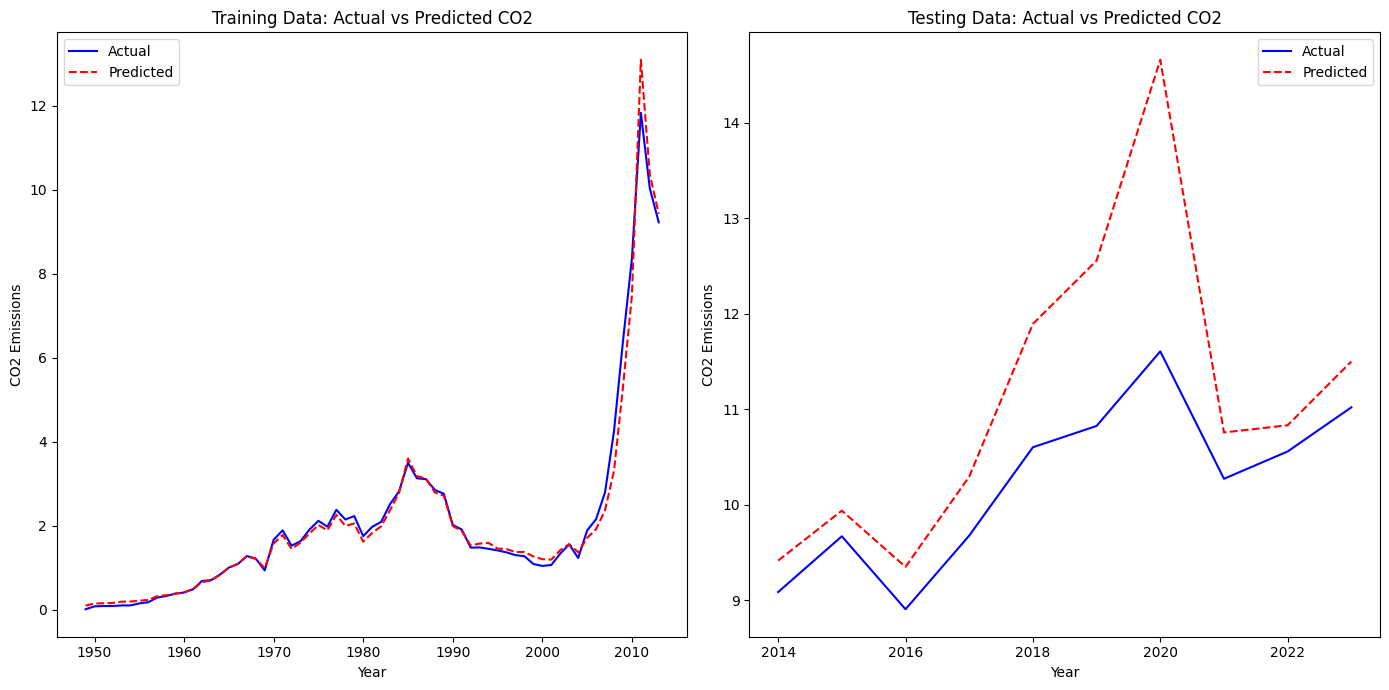

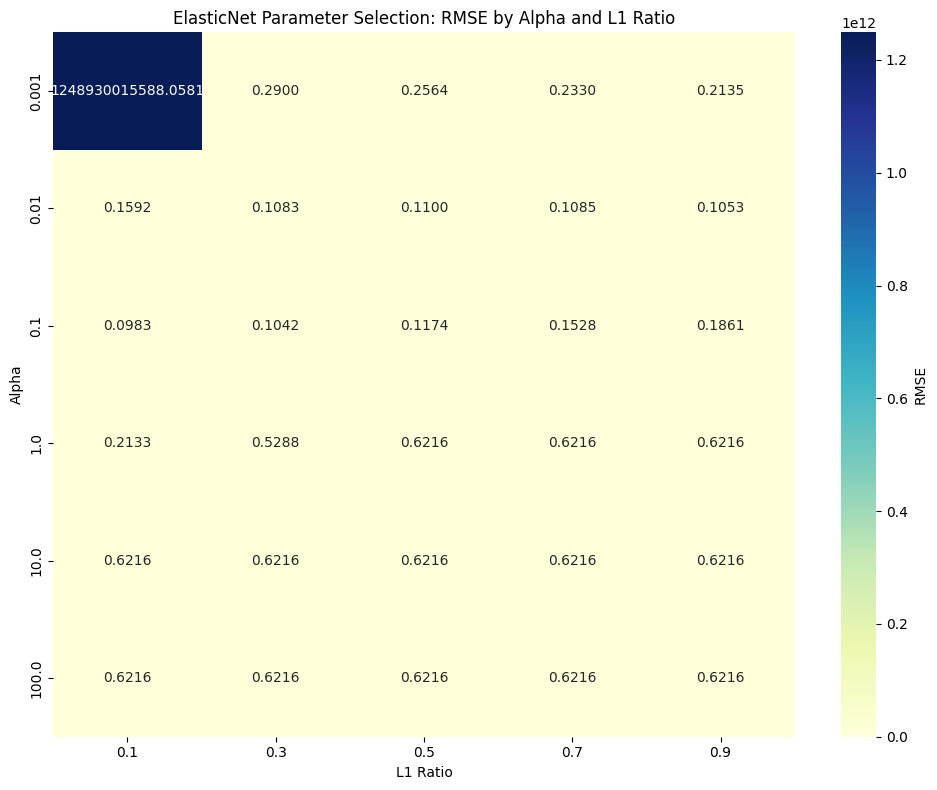

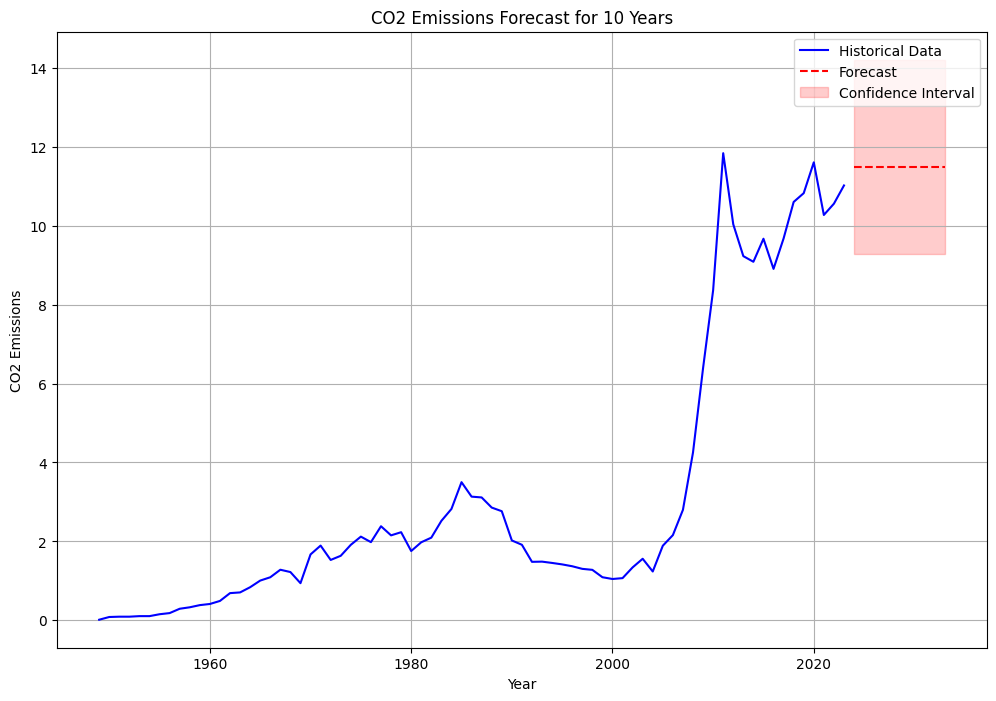

In [21]:
alphas = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
l1_ratios = [0.1, 0.3, 0.5, 0.7, 0.9]
lags = 3
add_polynomial_year = True
use_log_transform = True

# Run ElasticNet model
elasticnet_results = time_series_elasticnet(
    df_final, 
    target_col='co2',  
    alphas=alphas,
    l1_ratios=l1_ratios,
    lags=lags,
    add_polynomial_year=add_polynomial_year,
    use_log_transform=use_log_transform
)

# Generate forecast
forecast_df = forecast_co2_elasticnet(
    elasticnet_results['model'], 
    df_final, 
    years_to_forecast=10
)

### Elastic Net Model with Lag variables and Moving average

Starting grid search for Elastic Net parameters...
Fitting 7 folds for each of 64 candidates, totalling 448 fits

Top 10 parameter combinations:
Alpha: 0.00001, L1 Ratio: 0.30, Test MSE: 0.4011, Train MSE: 0.0002
Alpha: 0.00001, L1 Ratio: 0.10, Test MSE: 0.4025, Train MSE: 0.0002
Alpha: 0.00001, L1 Ratio: 0.50, Test MSE: 0.4108, Train MSE: 0.0002
Alpha: 0.00001, L1 Ratio: 0.70, Test MSE: 0.4109, Train MSE: 0.0002
Alpha: 0.00001, L1 Ratio: 0.90, Test MSE: 0.4247, Train MSE: 0.0002
Alpha: 0.00001, L1 Ratio: 1.00, Test MSE: 0.4317, Train MSE: 0.0002
Alpha: 0.00001, L1 Ratio: 0.99, Test MSE: 0.4325, Train MSE: 0.0002
Alpha: 0.00001, L1 Ratio: 0.95, Test MSE: 0.4357, Train MSE: 0.0002
Alpha: 0.00010, L1 Ratio: 0.10, Test MSE: 0.8157, Train MSE: 0.0004
Alpha: 0.00010, L1 Ratio: 0.30, Test MSE: 0.8418, Train MSE: 0.0004

Best parameters: Alpha=0.00001, L1 Ratio=0.30

Feature importance (top 15 features):
                       Feature  Coefficient  Abs_Coefficient
34                    co2_ma

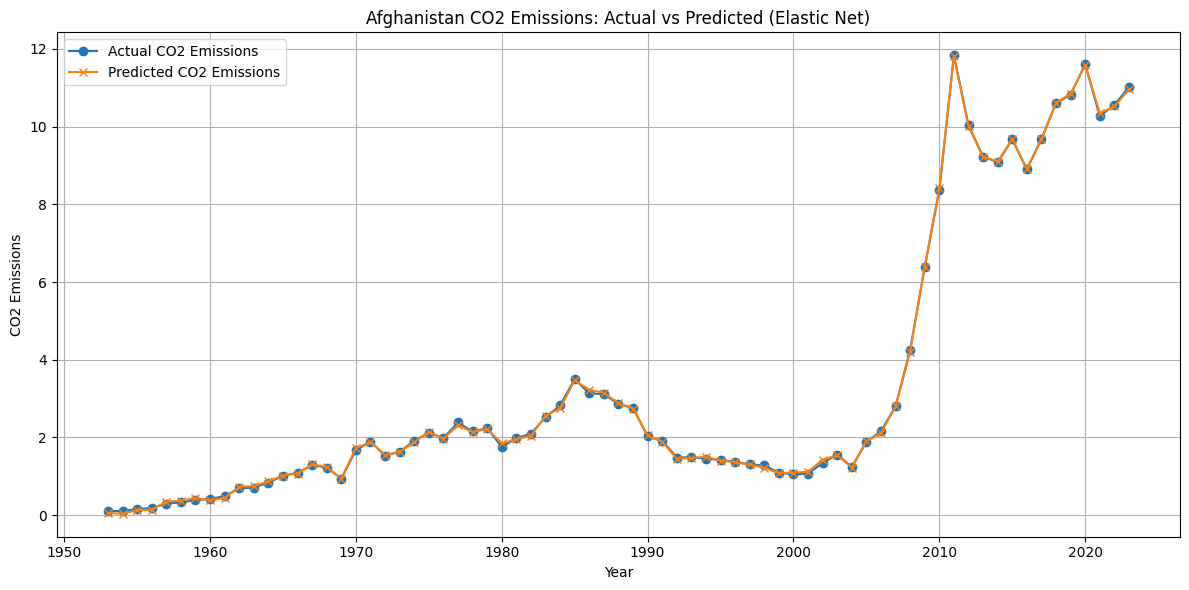

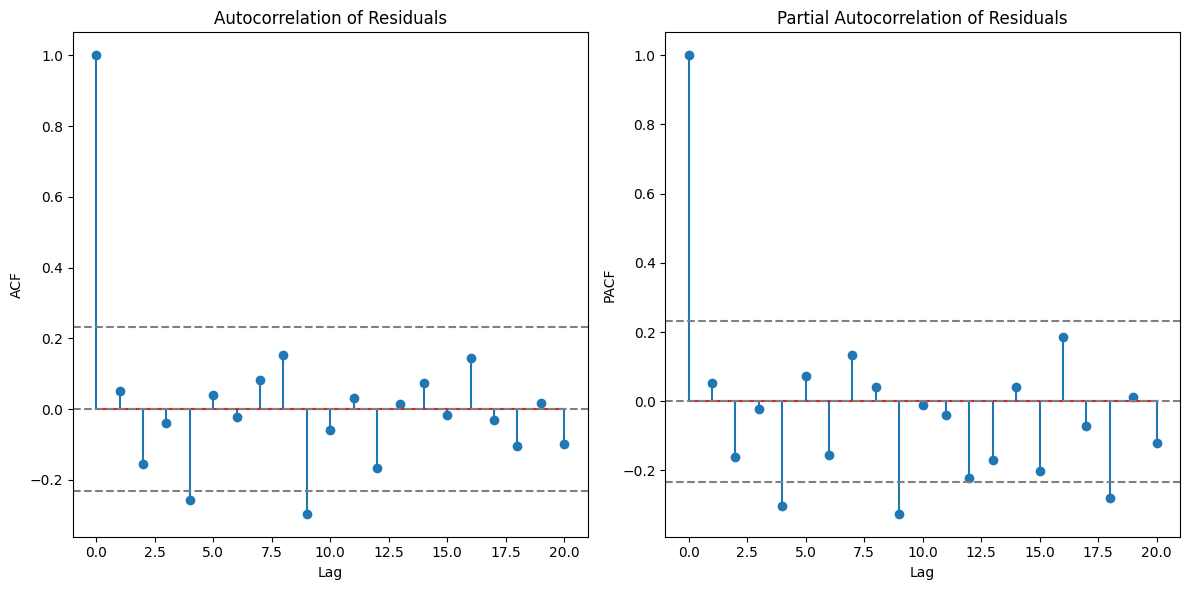


Future CO2 Emission Forecasts (Elastic Net):
Year 2024: 10.9585
Year 2025: 11.1025
Year 2026: 10.9711
Year 2027: 11.1121
Year 2028: 11.1851
Year 2029: 11.1842
Year 2030: 11.2097
Year 2031: 11.0100
Year 2032: 11.1220
Year 2033: 11.1508

Elastic Net model and scaler saved to disk.

Training/Testing Performance Metrics:
Training MSE: 0.0000, RMSE: 0.0055, R²: 1.0000
Testing MSE: 0.8822, RMSE: 0.9393, R²: 0.5046


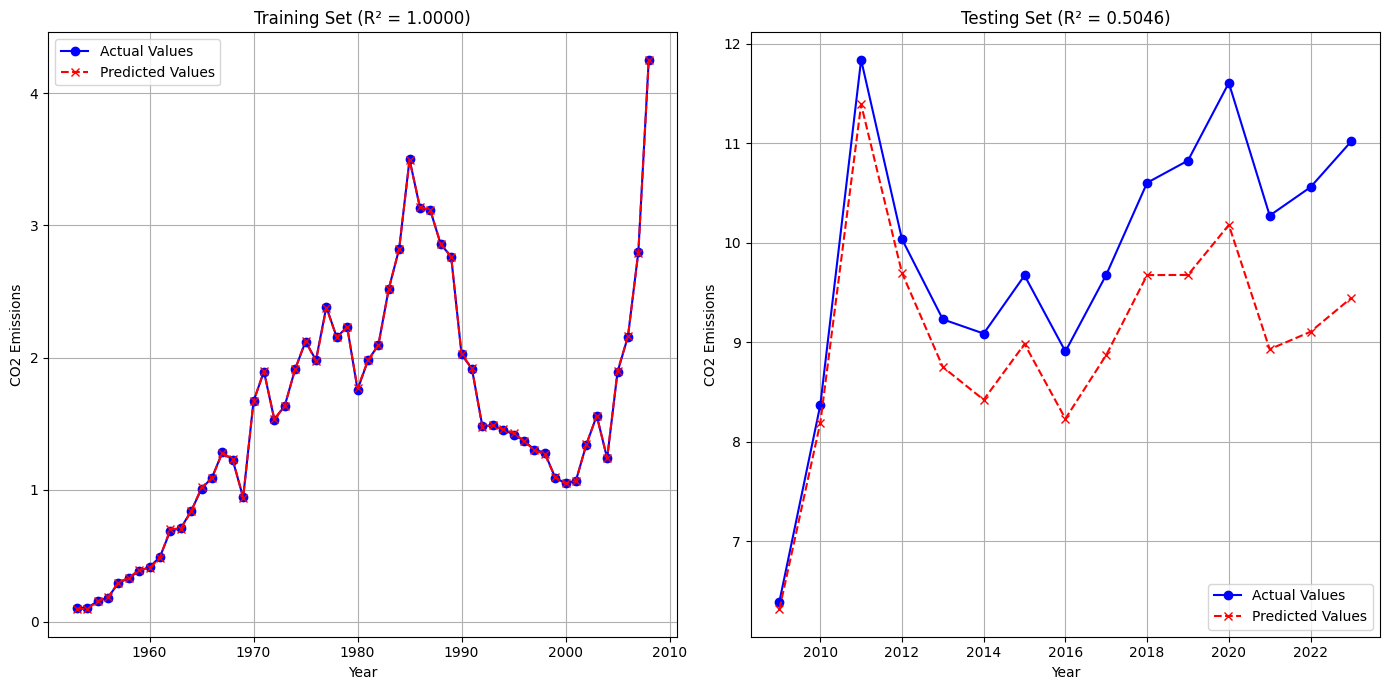

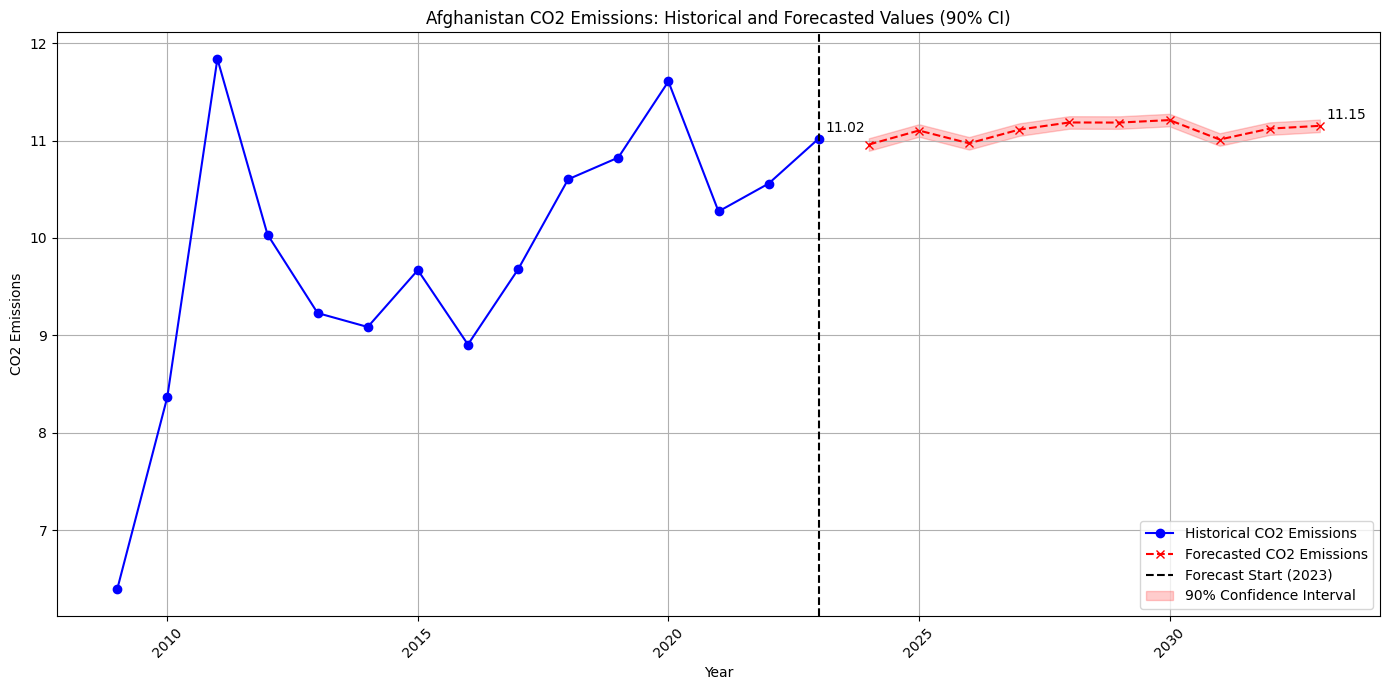


Forecast Analysis:
Forecast period: 2024 to 2033 (10 years)
Starting CO2 emissions: 10.9585
Ending CO2 emissions: 11.1508
Overall change: 0.1922 (1.75%)
Average annual change: 0.0192


In [22]:
# Create features and target arrays
X = df_ma.drop(target, axis=1)
y = df_ma[target]

# Use year for indexing but remove from features
X_year = X['year']
X = X.drop('year', axis=1)

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=7)

# Set up grid search for Elastic Net with simplified alpha values and l1_ratio
param_grid = {
    'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99, 1.0]
}

# Set additional parameters for the Elastic Net model
elastic_net = ElasticNet(
    max_iter=10000,
    random_state=42,
    tol=1e-4,
    selection='random',
    warm_start=True
)

print("Starting grid search for Elastic Net parameters...")
grid_search = GridSearchCV(
    estimator=elastic_net, 
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

grid_search.fit(X_scaled, y)

# Print all tested parameter combinations and their corresponding scores for analysis
results = pd.DataFrame(grid_search.cv_results_)
results = results.sort_values(by='rank_test_score')
print("\nTop 10 parameter combinations:")
for i in range(min(10, len(results))):
    row = results.iloc[i]
    print(f"Alpha: {row['param_alpha']:.5f}, L1 Ratio: {row['param_l1_ratio']:.2f}, "
          f"Test MSE: {-row['mean_test_score']:.4f}, "
          f"Train MSE: {-row['mean_train_score']:.4f}")

# Best parameters
print(f"\nBest parameters: Alpha={grid_search.best_params_['alpha']:.5f}, L1 Ratio={grid_search.best_params_['l1_ratio']:.2f}")
best_elastic_net = grid_search.best_estimator_

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns, 
    'Coefficient': best_elastic_net.coef_
})
# Sort by absolute coefficient value to see most important features
feature_importance['Abs_Coefficient'] = abs(feature_importance['Coefficient'])
feature_importance = feature_importance.sort_values(by='Abs_Coefficient', ascending=False)
print("\nFeature importance (top 15 features):")
print(feature_importance.head(15))

# Count non-zero coefficients
non_zero_coefs = np.sum(best_elastic_net.coef_ != 0)
print(f"\nNumber of features selected by Elastic Net: {non_zero_coefs} out of {len(X.columns)}")

# Make predictions
y_pred = best_elastic_net.predict(X_scaled)

# Calculate performance metrics
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y, y_pred)

print(f"\nModel Performance:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R-squared: {r2:.4f}")

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(X_year, y, label='Actual CO2 Emissions', marker='o')
plt.plot(X_year, y_pred, label='Predicted CO2 Emissions', marker='x')
plt.xlabel('Year')
plt.ylabel('CO2 Emissions')
plt.title('Afghanistan CO2 Emissions: Actual vs Predicted (Elastic Net)')
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.savefig('afghanistan_co2_elastic_net_prediction.png')
plt.show()

# Plot the autocorrelation function of residuals to check model adequacy
residuals = y - y_pred
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.stem(acf(residuals, nlags=20))
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(residuals)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(residuals)), linestyle='--', color='gray')
plt.title('Autocorrelation of Residuals')
plt.xlabel('Lag')
plt.ylabel('ACF')

plt.subplot(1, 2, 2)
plt.stem(pacf(residuals, nlags=20))
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(residuals)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(residuals)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation of Residuals')
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.tight_layout()
# plt.savefig('afghanistan_co2_elastic_net_residual_analysis.png')
plt.show()

# Function to forecast future values
def forecast_future(model, data, scaler, periods=5):
    """
    Forecast future values using the trained model
    
    Parameters:
    - model: Trained Elastic Net model
    - data: DataFrame with the latest data
    - scaler: Fitted StandardScaler
    - periods: Number of periods to forecast
    
    Returns:
    - Forecasted values and updated data
    """
    # Copy the latest data
    future_data = data.copy()
    forecasts = []
    
    for i in range(periods):
        # Get the latest row of data
        latest_data = future_data.iloc[-1:].copy()
        
        # Update the year
        next_year = latest_data['year'].values[0] + 1
        latest_data['year'] = next_year
        
        # Get features without the target
        X_forecast = latest_data.drop(target, axis=1)
        X_forecast_year = X_forecast['year']
        X_forecast = X_forecast.drop('year', axis=1)
        
        # Scale the features
        X_forecast_scaled = scaler.transform(X_forecast)
        
        # Make prediction
        forecast = model.predict(X_forecast_scaled)[0]
        forecasts.append((next_year, forecast))
        
        # Update the dataframe with the new prediction for next iteration
        new_row = latest_data.copy()
        new_row[target] = forecast
        
        # Update lag and moving average features
        for lag in range(1, lag_periods + 1):
            lag_col = f'{target}_lag_{lag}'
            if lag == 1:
                new_row[lag_col] = latest_data[target].values[0]
            else:
                prev_lag_col = f'{target}_lag_{lag-1}'
                new_row[lag_col] = latest_data[prev_lag_col].values[0]
        
        # Update moving averages (simplified approach)
        for window in ma_windows:
            ma_col = f'{target}_ma_{window}'
            # This is a simple approximation; a more accurate approach would involve more complex calculations
            recent_values = [forecast] + [future_data[target].iloc[-i] for i in range(1, window)]
            new_row[ma_col] = sum(recent_values) / window
        
        # Append to the future_data DataFrame
        future_data = pd.concat([future_data, new_row], ignore_index=True)
    
    return forecasts, future_data

# Example usage of the forecast function
# Get the latest data
latest_data = df_ma.copy()
future_forecasts, future_data = forecast_future(best_elastic_net, latest_data, scaler, periods=10)

print("\nFuture CO2 Emission Forecasts (Elastic Net):")
for year, forecast in future_forecasts:
    print(f"Year {year}: {forecast:.4f}")

# Save the model for future use
import joblib
joblib.dump(best_elastic_net, 'afghanistan_co2_elastic_net_model.pkl')
joblib.dump(scaler, 'afghanistan_co2_feature_scaler.pkl')
print("\nElastic Net model and scaler saved to disk.")

# Split data for training and testing visualization
split_ratio = 0.8
split_idx = int(len(X) * split_ratio)

X_train = X_scaled[:split_idx]
X_test = X_scaled[split_idx:]
y_train = y[:split_idx]
y_test = y[split_idx:]
years_train = X_year[:split_idx]
years_test = X_year[split_idx:]

# Train the best model on training data
best_elastic_net_for_split = ElasticNet(
    alpha=grid_search.best_params_['alpha'],
    l1_ratio=grid_search.best_params_['l1_ratio'],
    max_iter=10000, 
    random_state=42)
best_elastic_net_for_split.fit(X_train, y_train)

# Make predictions on both training and test data
y_train_pred = best_elastic_net_for_split.predict(X_train)
y_test_pred = best_elastic_net_for_split.predict(X_test)

# Calculate metrics for both sets
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("\nTraining/Testing Performance Metrics:")
print(f"Training MSE: {train_mse:.4f}, RMSE: {np.sqrt(train_mse):.4f}, R²: {train_r2:.4f}")
print(f"Testing MSE: {test_mse:.4f}, RMSE: {np.sqrt(test_mse):.4f}, R²: {test_r2:.4f}")

# Plot training and testing predictions
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(years_train, y_train, 'o-', label='Actual Values', color='blue')
plt.plot(years_train, y_train_pred, 'x--', label='Predicted Values', color='red')
plt.title(f'Training Set (R² = {train_r2:.4f})')
plt.xlabel('Year')
plt.ylabel('CO2 Emissions')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(years_test, y_test, 'o-', label='Actual Values', color='blue')
plt.plot(years_test, y_test_pred, 'x--', label='Predicted Values', color='red')
plt.title(f'Testing Set (R² = {test_r2:.4f})')
plt.xlabel('Year')
plt.ylabel('CO2 Emissions')
plt.grid(True)
plt.legend()

plt.tight_layout()
# plt.savefig('afghanistan_co2_elastic_net_train_test_split.png')
plt.show()

# Create a plot for historical and forecasted values with adjustable confidence interval
# Extract forecast years and values
forecast_years = [year for year, _ in future_forecasts]
forecast_values = [forecast for _, forecast in future_forecasts]

# Get the last few years of historical data for context
history_years = X_year[-15:].tolist()  # Last 15 years for context
history_values = y[-15:].tolist()

# Define confidence level (change this value to adjust the confidence interval)
confidence_level = 0.90  # 95% confidence interval

# Z-score mapping for common confidence levels
z_scores = {
    0.50: 0.67,  # 50% confidence interval
    0.68: 1.00,  # 68% confidence interval
    0.80: 1.28,  # 80% confidence interval
    0.90: 1.645, # 90% confidence interval
    0.95: 1.96,  # 95% confidence interval
    0.99: 2.576, # 99% confidence interval
    0.999: 3.291 # 99.9% confidence interval
}

# Get the appropriate z-score for the confidence level
z_score = z_scores.get(confidence_level, 1.96)  # Default to 95% if not found

plt.figure(figsize=(14, 7))
# Plot historical data
plt.plot(history_years, history_values, 'o-', color='blue', label='Historical CO2 Emissions')

# Plot forecasted data
plt.plot(forecast_years, forecast_values, 'x--', color='red', label='Forecasted CO2 Emissions')

# Add vertical line to separate historical from forecast
last_historical_year = history_years[-1]
plt.axvline(x=last_historical_year, color='black', linestyle='--', 
           label=f'Forecast Start ({last_historical_year})')

# Create a confidence interval for forecasts using the selected confidence level
historical_rmse = np.sqrt(mse)
upper_bound = [val + z_score * historical_rmse for val in forecast_values]
lower_bound = [max(0, val - z_score * historical_rmse) for val in forecast_values]  # Ensure no negative values

plt.fill_between(forecast_years, lower_bound, upper_bound, color='red', alpha=0.2, 
                label=f'{confidence_level*100:.0f}% Confidence Interval')

plt.title(f'Afghanistan CO2 Emissions: Historical and Forecasted Values ({confidence_level*100:.0f}% CI)')
plt.xlabel('Year')
plt.ylabel('CO2 Emissions')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)

# Annotate the last historical and future values
plt.annotate(f'{history_values[-1]:.2f}', 
            xy=(history_years[-1], history_values[-1]),
            xytext=(5, 5), textcoords='offset points')
plt.annotate(f'{forecast_values[-1]:.2f}', 
            xy=(forecast_years[-1], forecast_values[-1]),
            xytext=(5, 5), textcoords='offset points')

plt.tight_layout()
# plt.savefig(f'afghanistan_co2_elastic_net_forecast_{confidence_level*100:.0f}pct_ci.png')
plt.show()

# Calculate forecast trend
first_forecast = forecast_values[0]
last_forecast = forecast_values[-1]
forecast_change_pct = ((last_forecast - first_forecast) / first_forecast) * 100
forecast_period = len(forecast_values)

print(f"\nForecast Analysis:")
print(f"Forecast period: {forecast_years[0]} to {forecast_years[-1]} ({forecast_period} years)")
print(f"Starting CO2 emissions: {first_forecast:.4f}")
print(f"Ending CO2 emissions: {last_forecast:.4f}")
print(f"Overall change: {last_forecast - first_forecast:.4f} ({forecast_change_pct:.2f}%)")
print(f"Average annual change: {(last_forecast - first_forecast) / forecast_period:.4f}")

### Random Forest , XGBoost and LightGBM 

Random Forest, Xgboost and LightGBM models have been implemented with lag variables created on the target variable and moving average variables. Extensive grid search has been performed to find the Best Parameters. Feature Selection has been performed using Lasso regression.

Total samples: 71
Train samples: 63
Test samples: 8

LASSO FEATURE SELECTION

Columns before feature selection:
1. gdp
2. PC_coal_1
3. PC_coal_2
4. PC_oil_1
5. PC_oil_2
6. PC_cement_1
7. PC_cement_2
8. PC_gas_1
9. PC_gas_2
10. PC_landuse_2
11. PC_flaring_1
12. PC_flaring_2
13. PC_growth_1
14. PC_growth_2
15. PC_energy_1
16. temperature_change_from_ch4
17. PC_ghg_2
18. PC_methane_1
19. primary_energy_consumption
20. co2_per_capita
21. co2_per_gdp
22. co2_per_unit_energy
23. share_global_co2
24. co2_lag_1
25. co2_lag_2
26. co2_lag_3
27. co2_lag_4
28. co2_lag_5
29. co2_lag_6
30. co2_lag_7
31. co2_lag_8
32. co2_lag_9
33. co2_lag_10
34. log_co2
35. co2_ma_2
36. co2_ma_3
37. co2_ma_5
Total number of features: 37

Lasso feature selection (alpha=0.0001) selected 35 features:
1. gdp: -0.338261
2. PC_coal_1: 0.759570
3. PC_coal_2: 0.110694
4. PC_oil_1: 1.155271
5. PC_oil_2: 0.128019
6. PC_cement_1: -0.034740
7. PC_cement_2: 0.165625
8. PC_gas_1: 0.222063
9. PC_gas_2: 0.011140
10. PC_landuse_2: -

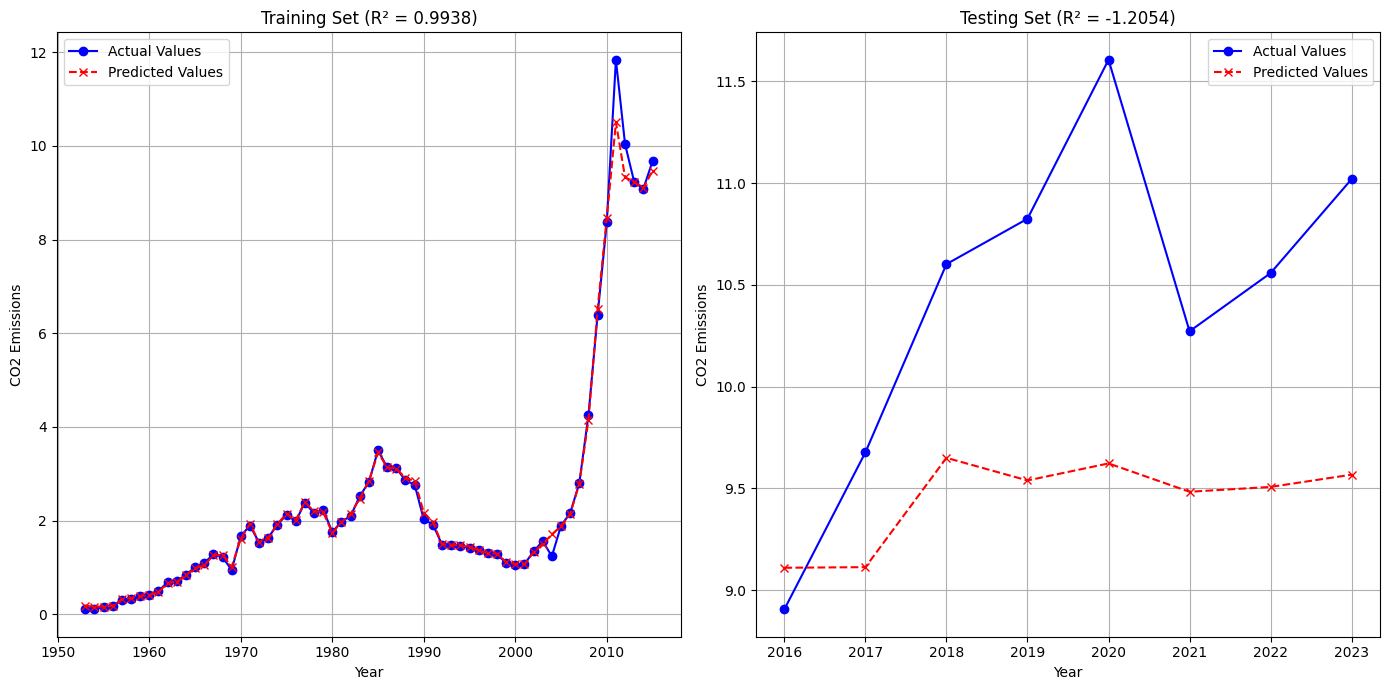

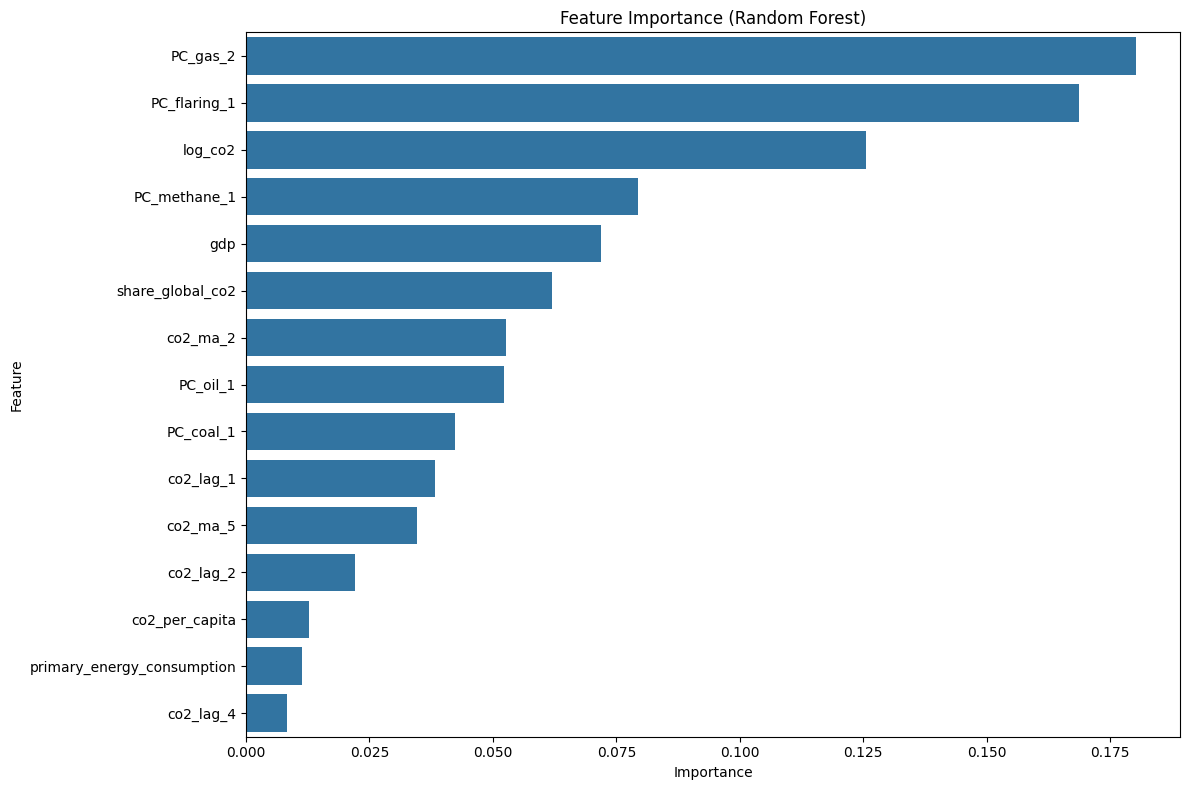


Feature importance (top 15 features) - Random Forest:
                       Feature  Importance
8                     PC_gas_2    0.180131
10                PC_flaring_1    0.168700
32                     log_co2    0.125499
17                PC_methane_1    0.079463
0                          gdp    0.071969
22            share_global_co2    0.061930
33                    co2_ma_2    0.052560
3                     PC_oil_1    0.052260
1                    PC_coal_1    0.042324
23                   co2_lag_1    0.038196
34                    co2_ma_5    0.034638
24                   co2_lag_2    0.022061
19              co2_per_capita    0.012837
18  primary_energy_consumption    0.011333
25                   co2_lag_4    0.008338


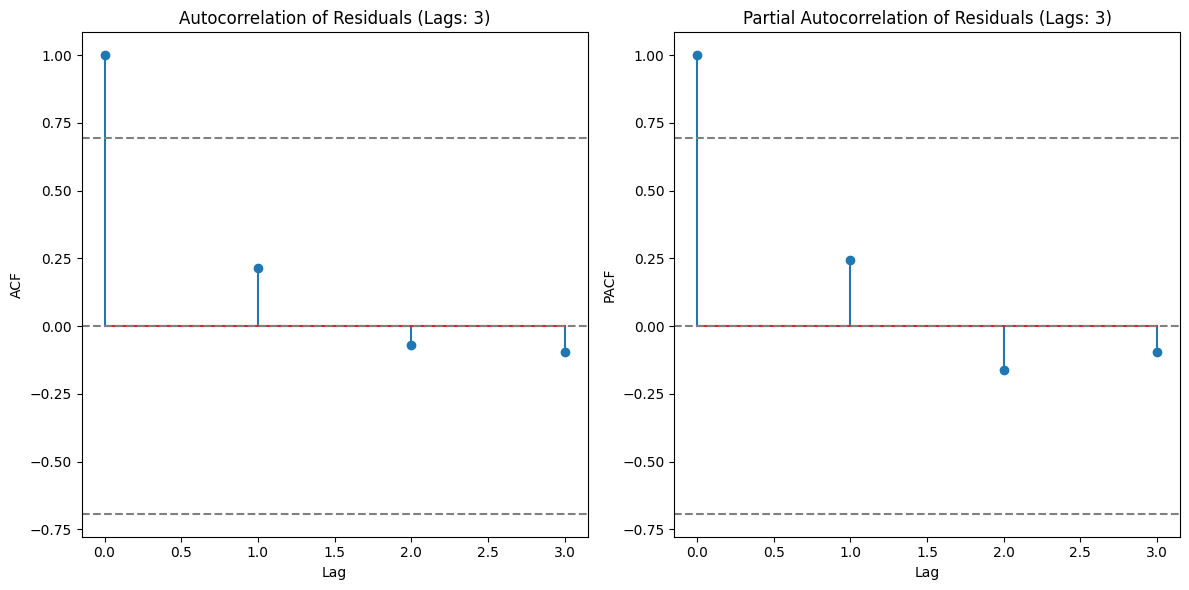


Performing Grid Search for XGBoost...
Fitting 10 folds for each of 128 candidates, totalling 1280 fits
Best XGBoost parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 8000, 'reg_alpha': 0.1, 'reg_lambda': 20.0, 'subsample': 0.9}
Best XGBoost CV score: 1.5448 (MSE)

Training XGBoost model...

Model Performance (XGBoost (Training)):
MSE: 0.0002
RMSE: 0.0144
MAE: 0.0039
R-squared: 1.0000

Model Performance (XGBoost (Testing)):
MSE: 0.2539
RMSE: 0.5039
MAE: 0.3952
R-squared: 0.5810


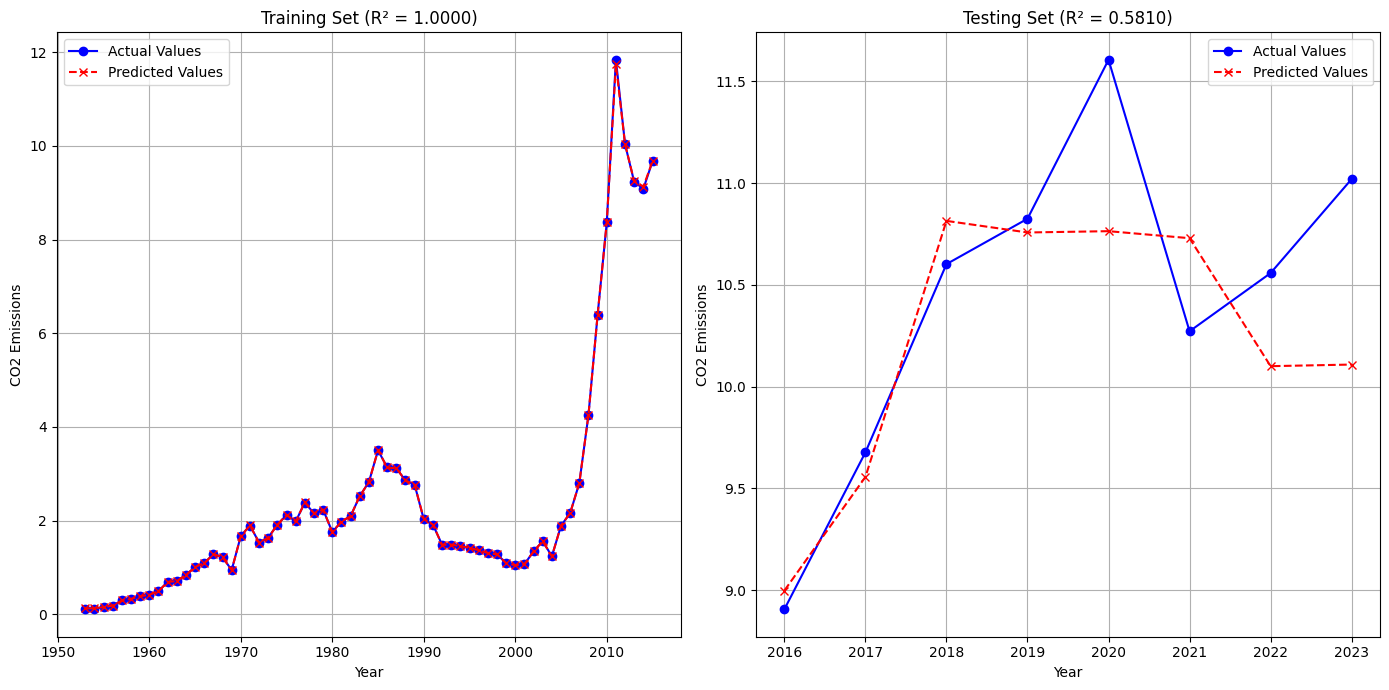

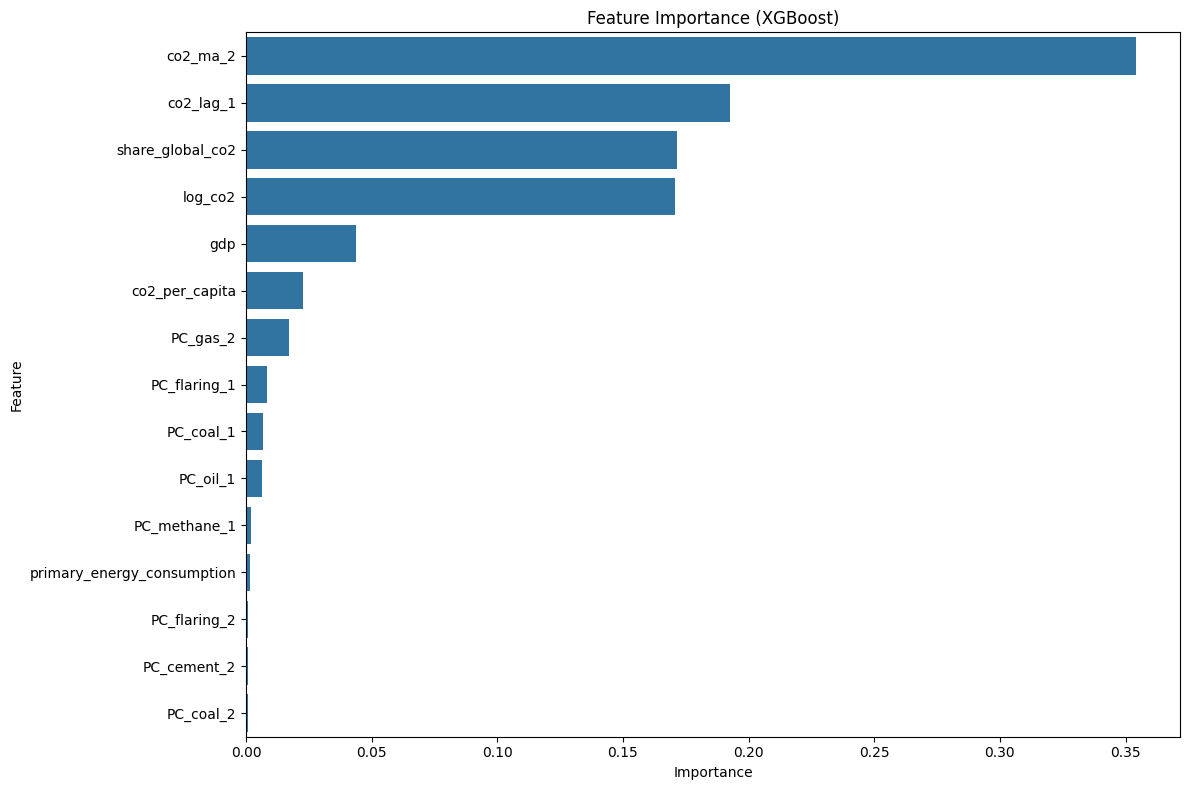


Feature importance (top 15 features) - XGBoost:
                       Feature  Importance
33                    co2_ma_2    0.353971
23                   co2_lag_1    0.192695
22            share_global_co2    0.171647
32                     log_co2    0.170675
0                          gdp    0.043954
19              co2_per_capita    0.022792
8                     PC_gas_2    0.016916
10                PC_flaring_1    0.008489
1                    PC_coal_1    0.006587
3                     PC_oil_1    0.006308
17                PC_methane_1    0.001949
18  primary_energy_consumption    0.001645
11                PC_flaring_2    0.000681
6                  PC_cement_2    0.000646
2                    PC_coal_2    0.000643


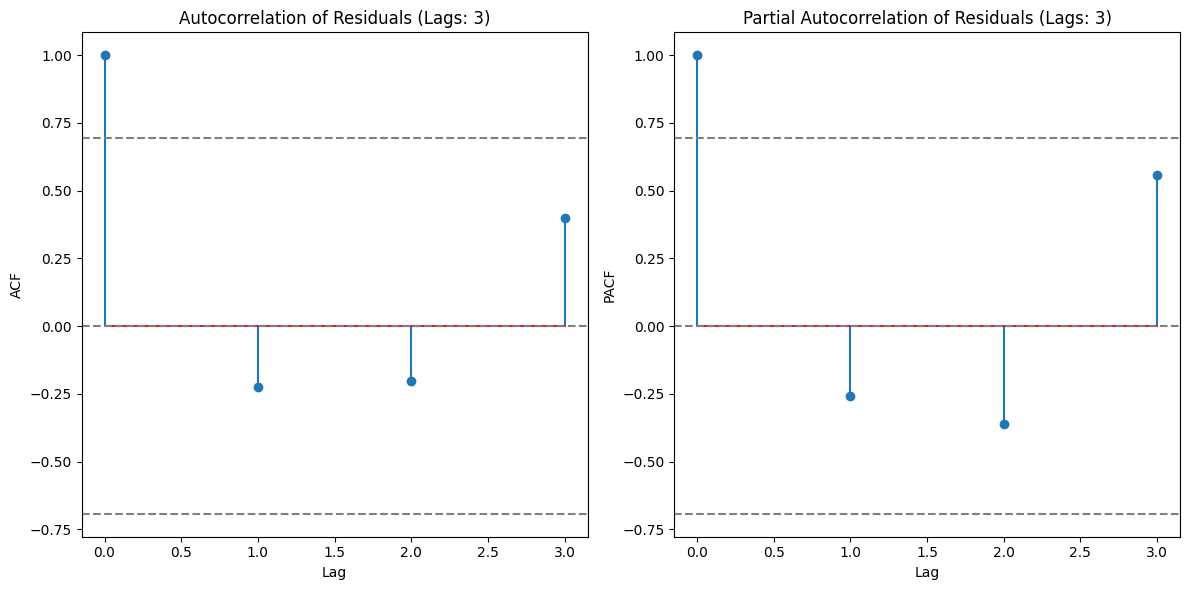


Performing Grid Search for LightGBM...
Fitting 10 folds for each of 64 candidates, totalling 640 fits
Best LightGBM parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 10000, 'num_leaves': 4, 'reg_alpha': 0.1, 'reg_lambda': 10.0, 'subsample': 0.9}
Best LightGBM CV score: 3.8187 (MSE)

Training LightGBM model...

Model Performance (LightGBM (Training)):
MSE: 0.0036
RMSE: 0.0603
MAE: 0.0427
R-squared: 0.9995

Model Performance (LightGBM (Testing)):
MSE: 0.3284
RMSE: 0.5731
MAE: 0.4129
R-squared: 0.4580


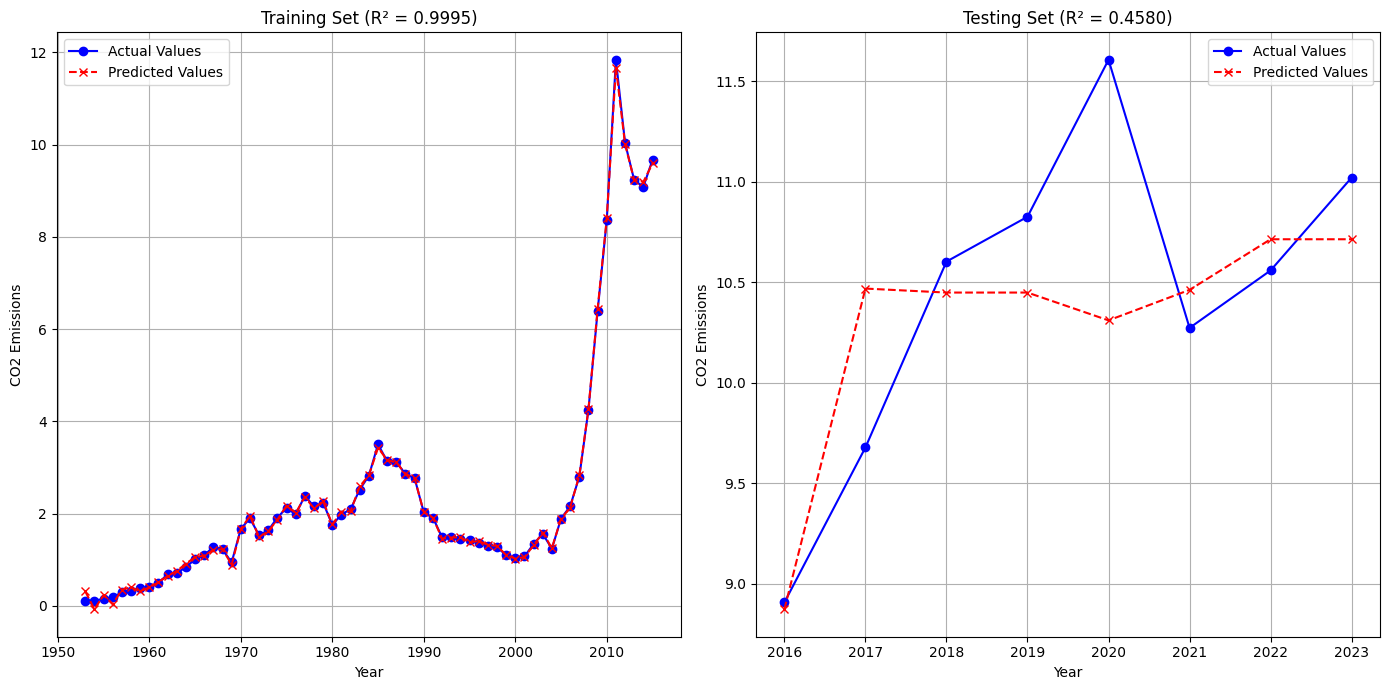

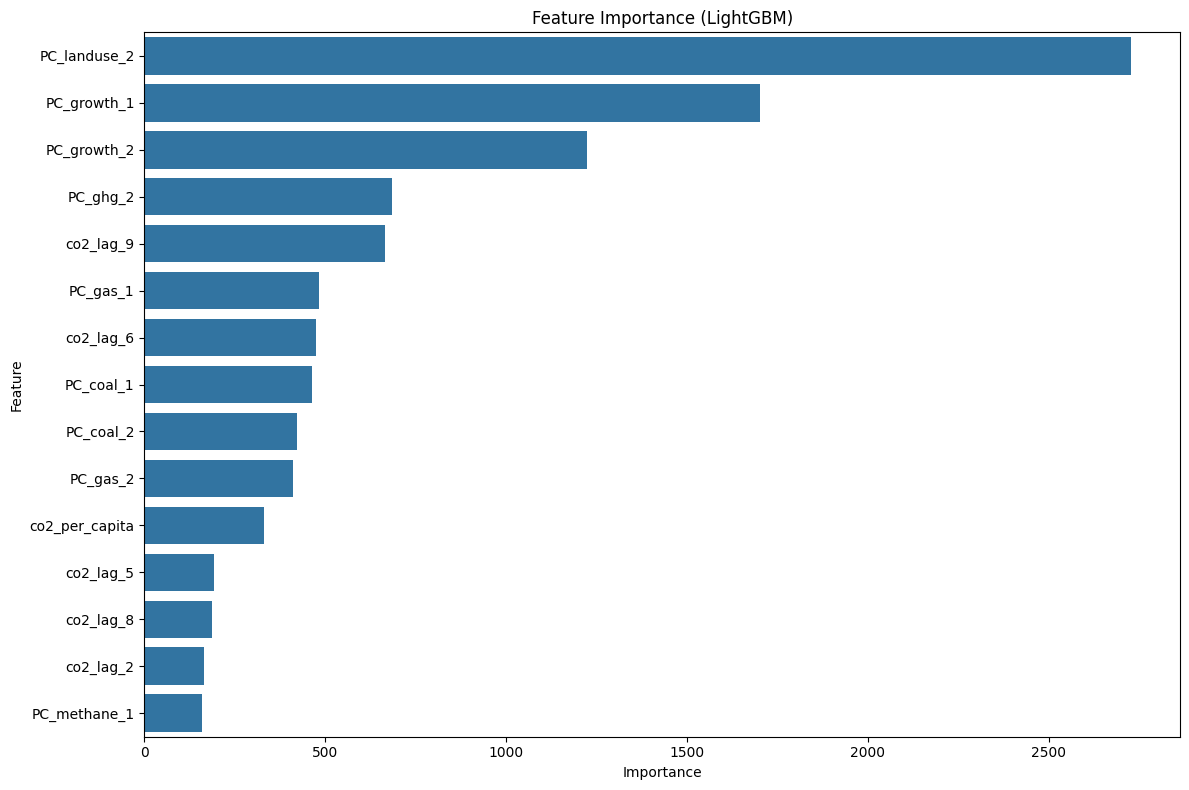


Feature importance (top 15 features) - LightGBM:
           Feature  Importance
9     PC_landuse_2        2727
12     PC_growth_1        1702
13     PC_growth_2        1224
16        PC_ghg_2         685
30       co2_lag_9         664
7         PC_gas_1         483
27       co2_lag_6         474
1        PC_coal_1         464
2        PC_coal_2         422
8         PC_gas_2         412
19  co2_per_capita         332
26       co2_lag_5         192
29       co2_lag_8         186
24       co2_lag_2         164
17    PC_methane_1         160


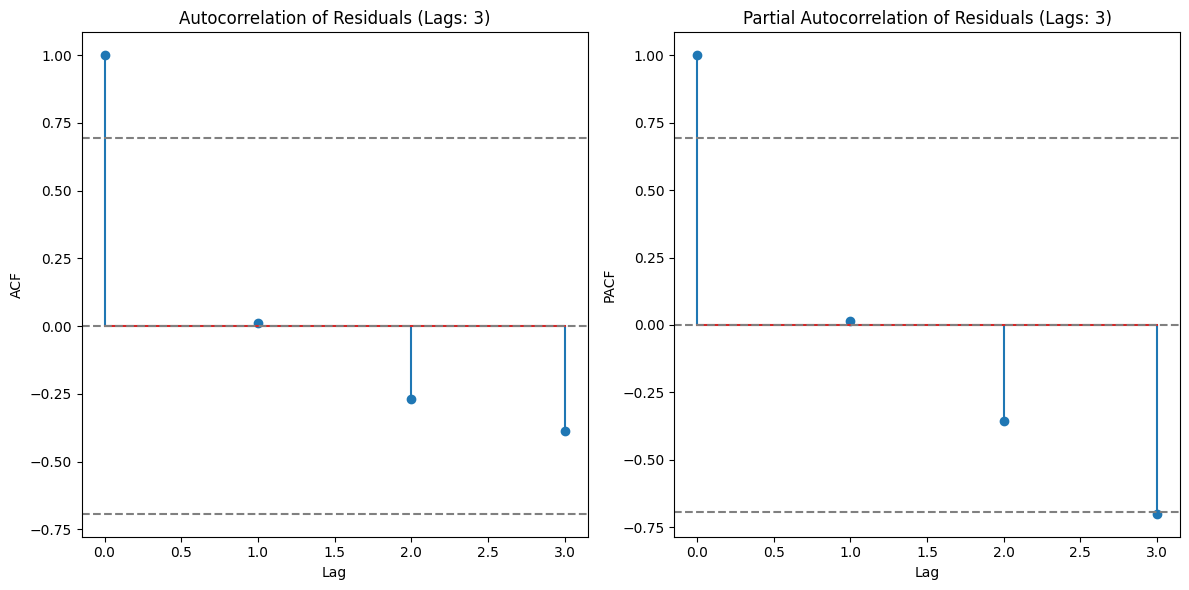


Performing Grid Search for AutoRegressive model...
Testing AR model with lag=5
  Lag 5 - Average CV MSE: 21.6477
Testing AR model with lag=7
  Lag 7 - Average CV MSE: 20.6768
Testing AR model with lag=10
  Lag 10 - Average CV MSE: 20.5062
Testing AR model with lag=15
  Lag 15 - Average CV MSE: 94.9760
Best AR lag: 10
Best AR CV score: 20.5062 (MSE)

Model Performance (AutoRegressive):
MSE: 2.8566
RMSE: 1.6901
MAE: 1.4704
R-squared: -3.7143


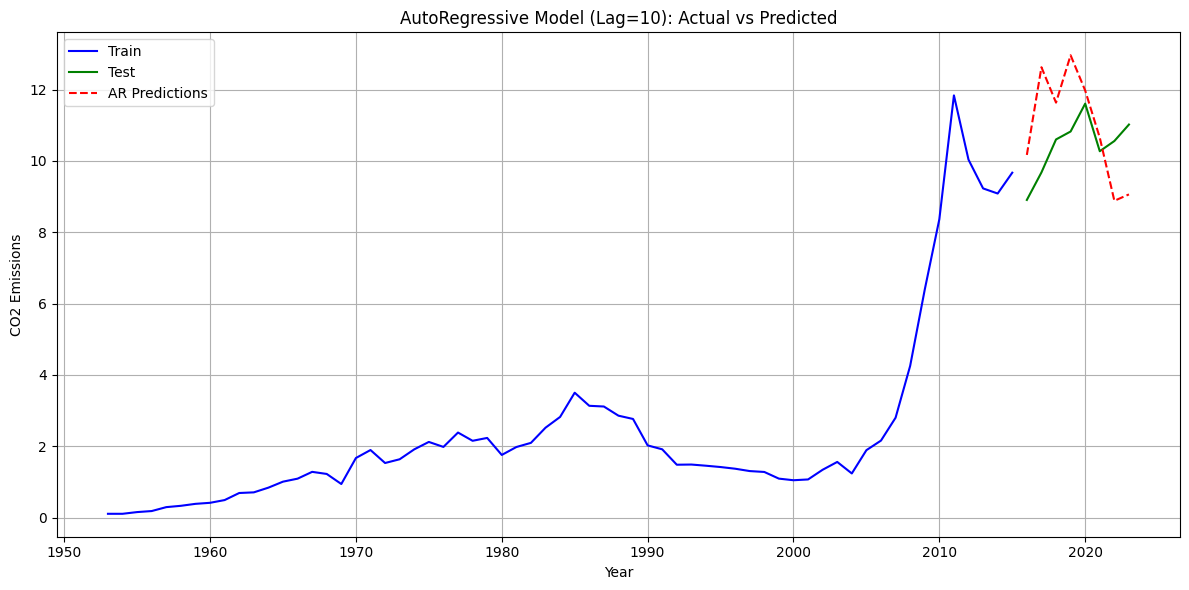


Model Performance Comparison (with Grid Search):
--------------------------------------------------
Random Forest:
  MSE:  1.3363
  RMSE: 1.1560
  MAE:  1.0352
  R²:   -1.2054
--------------------------------------------------
XGBoost:
  MSE:  0.2539
  RMSE: 0.5039
  MAE:  0.3952
  R²:   0.5810
--------------------------------------------------
LightGBM:
  MSE:  0.3284
  RMSE: 0.5731
  MAE:  0.4129
  R²:   0.4580
--------------------------------------------------
AutoRegressive:
  MSE:  2.8566
  RMSE: 1.6901
  MAE:  1.4704
  R²:   -3.7143
--------------------------------------------------


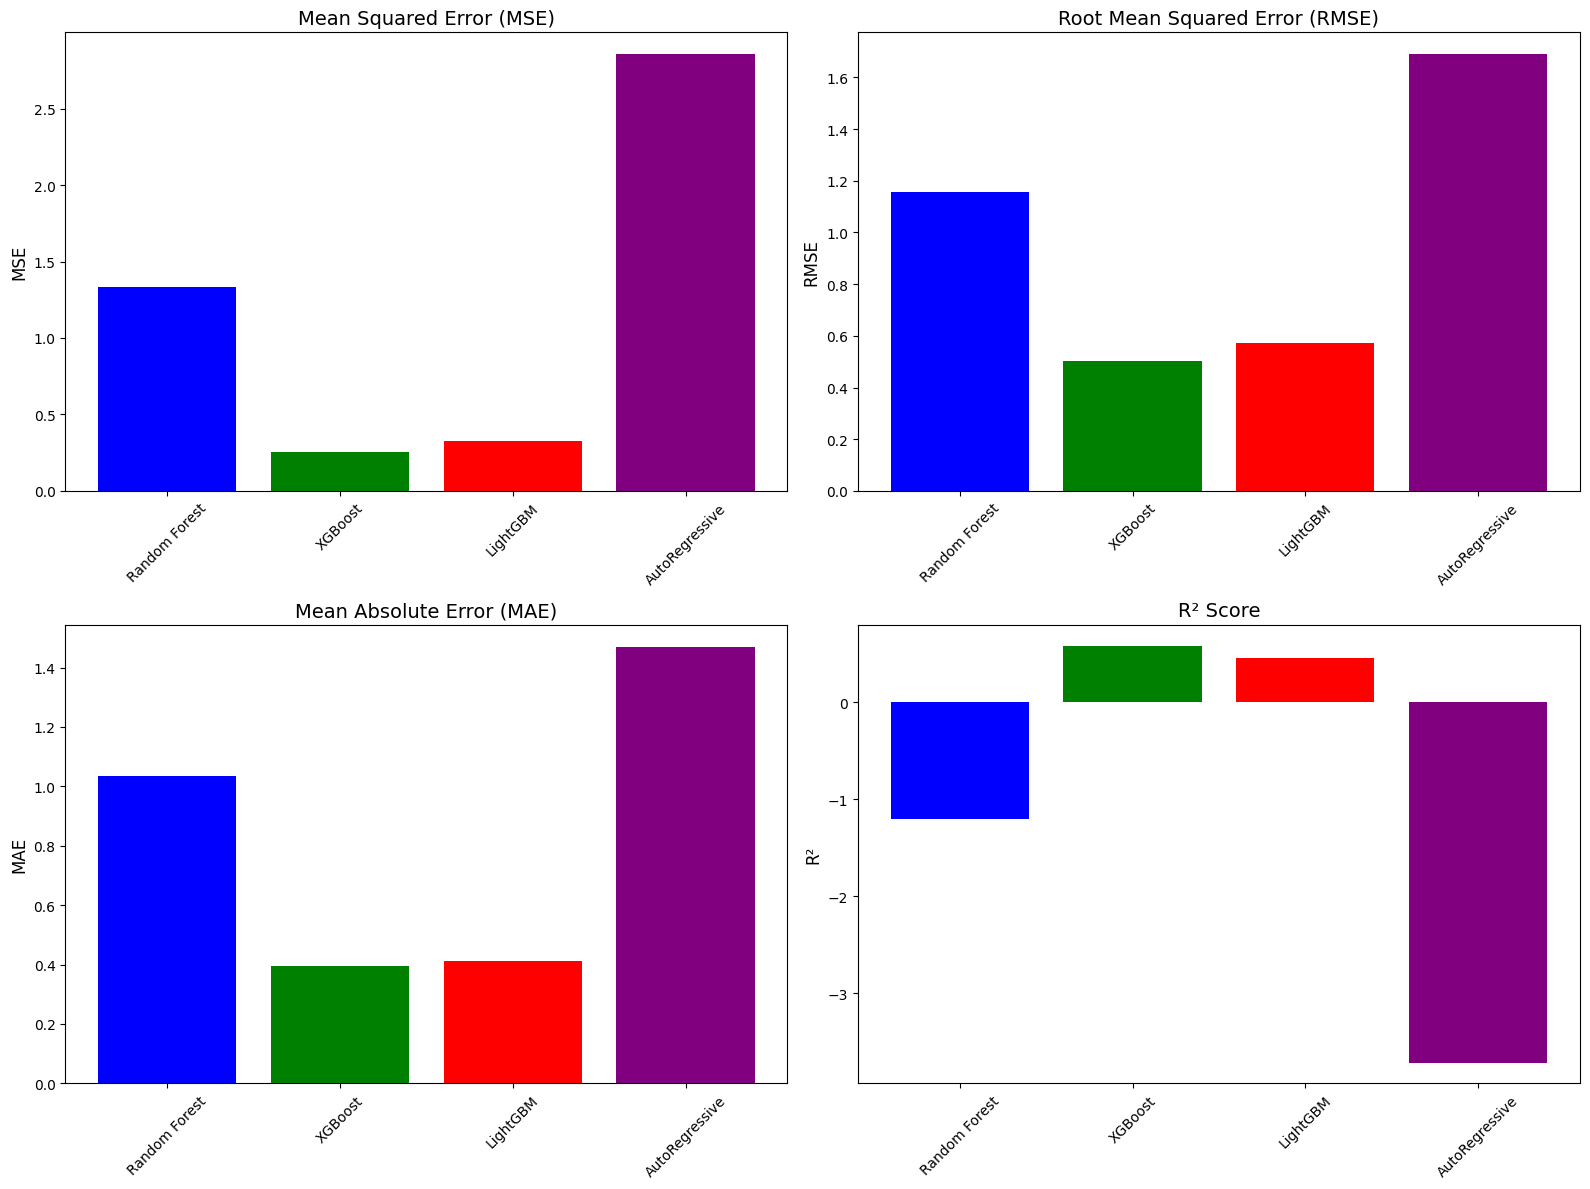


Best model based on RMSE: XGBoost

Generating forecasts for Random Forest...


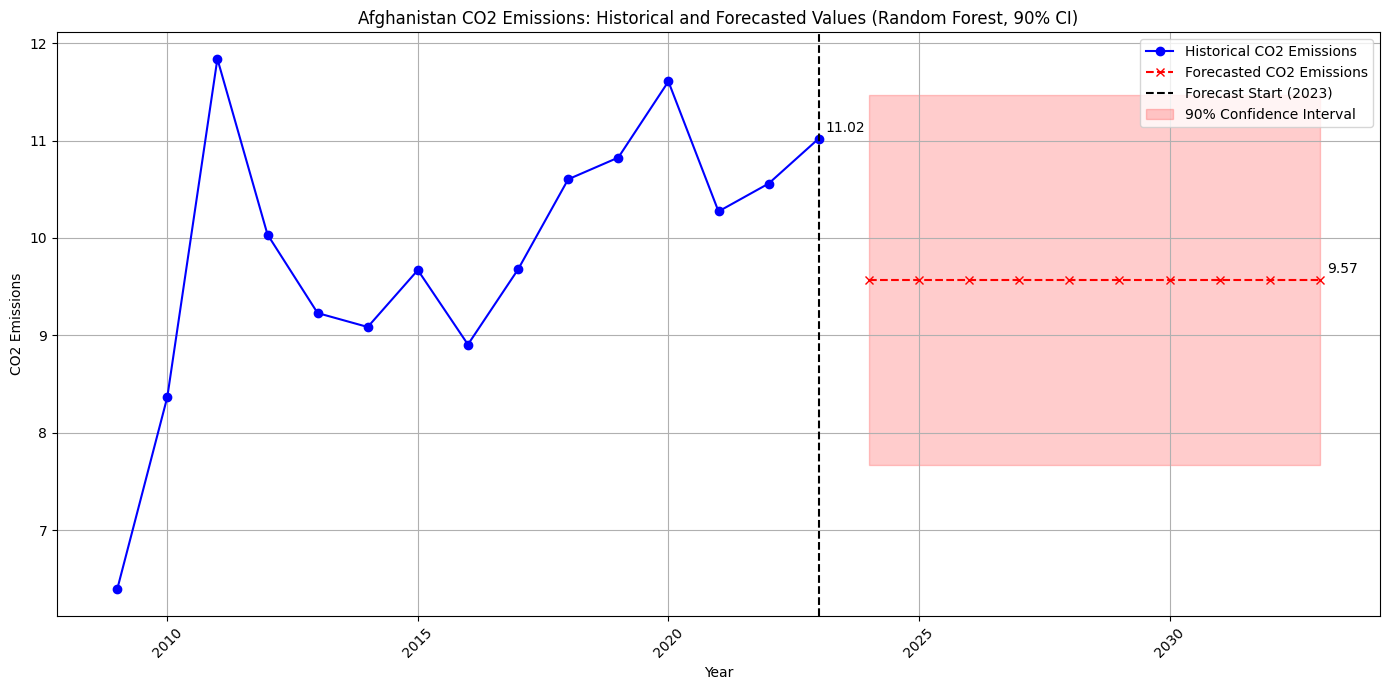


Forecast Analysis (Random Forest):
Forecast period: 2024 to 2033 (10 years)
Starting CO2 emissions: 9.5673
Ending CO2 emissions: 9.5673
Overall change: 0.0000 (0.00%)
Average annual change: 0.0000

Generating forecasts for XGBoost...


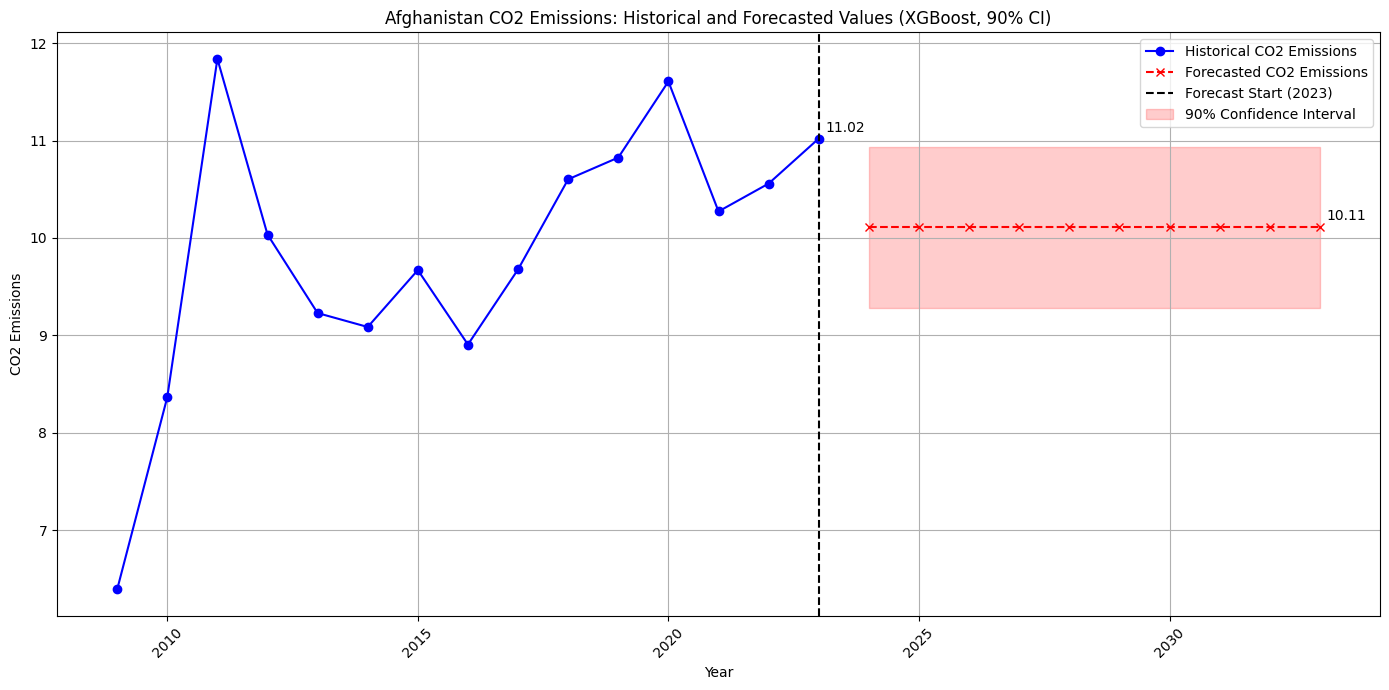


Forecast Analysis (XGBoost):
Forecast period: 2024 to 2033 (10 years)
Starting CO2 emissions: 10.1085
Ending CO2 emissions: 10.1085
Overall change: 0.0000 (0.00%)
Average annual change: 0.0000

Generating forecasts for LightGBM...


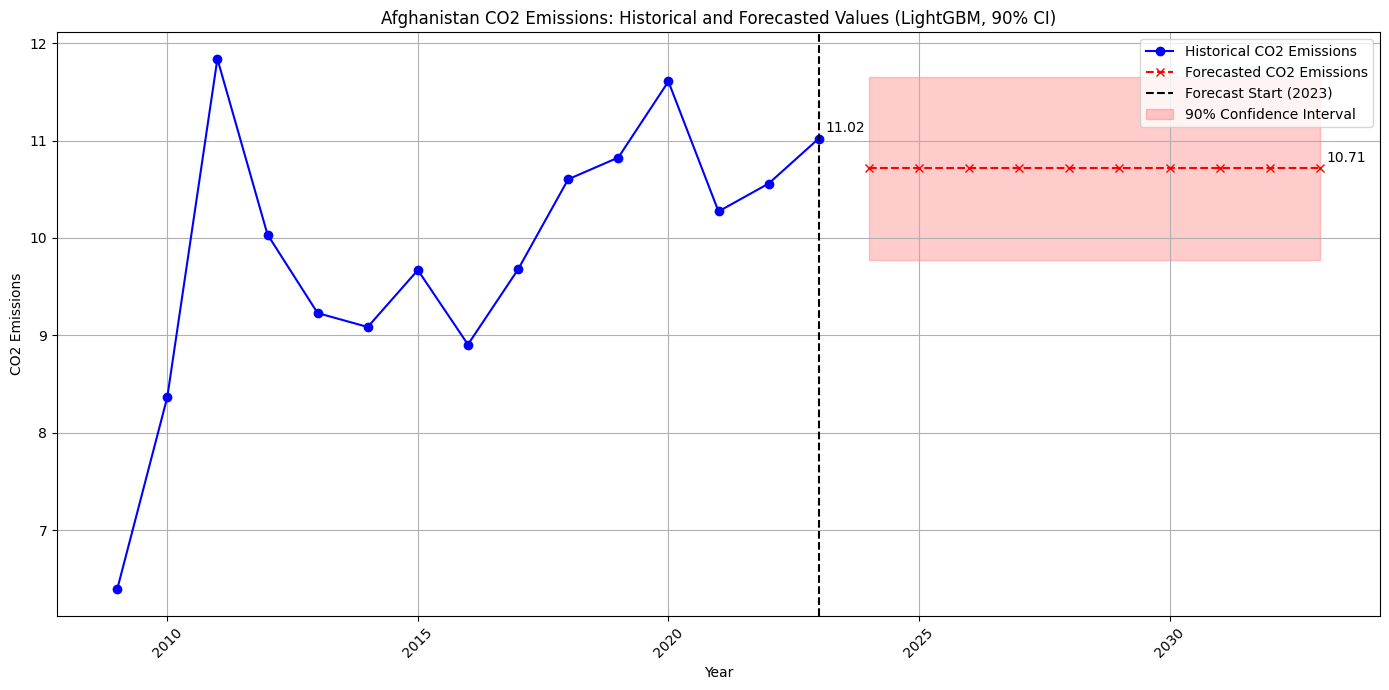


Forecast Analysis (LightGBM):
Forecast period: 2024 to 2033 (10 years)
Starting CO2 emissions: 10.7131
Ending CO2 emissions: 10.7131
Overall change: 0.0000 (0.00%)
Average annual change: 0.0000

Generating forecasts for AutoRegressive model...


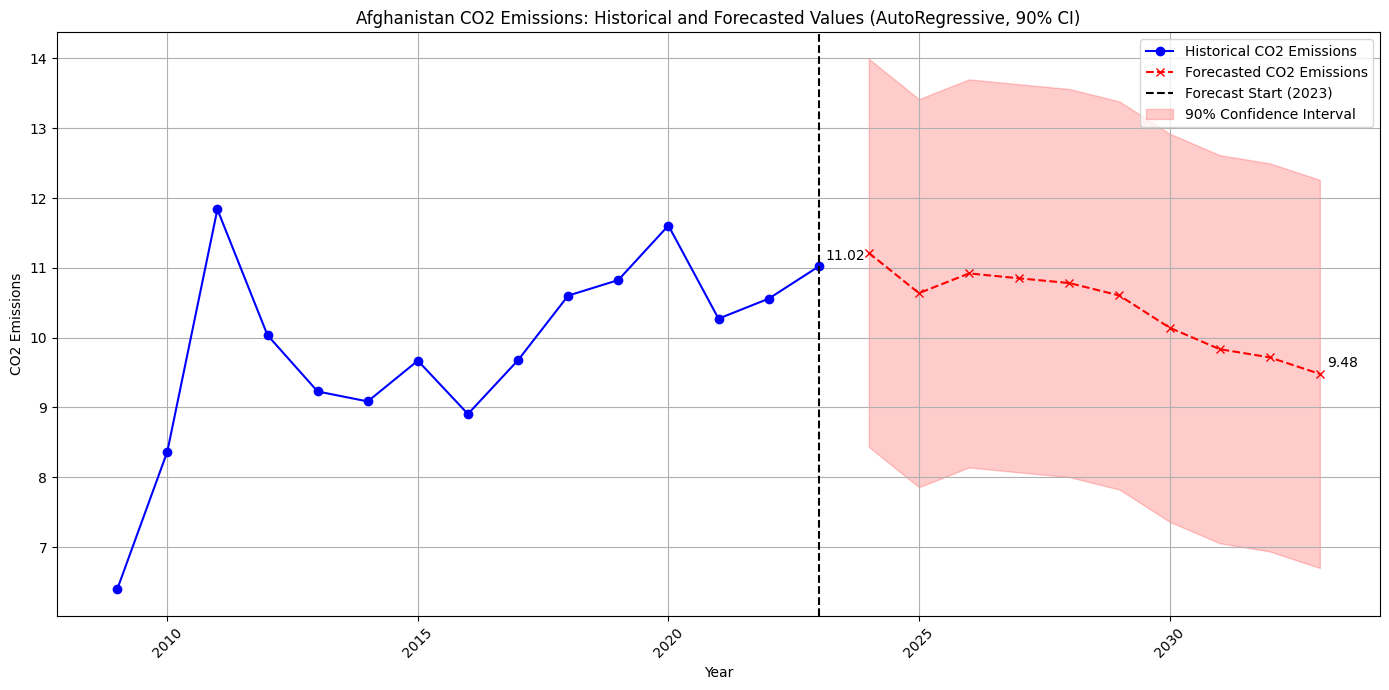


Forecast Analysis (AutoRegressive):
Forecast period: 2024 to 2033 (10 years)
Starting CO2 emissions: 11.2139
Ending CO2 emissions: 9.4799
Overall change: -1.7340 (-15.46%)
Average annual change: -0.1734


{'models': {'Random Forest': RandomForestRegressor(max_depth=5, min_samples_split=3, n_estimators=2000,
                        random_state=42),
  'XGBoost': XGBRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.7, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               feature_weights=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=0.1, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=9,
               max_leaves=None, min_child_weight=1, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=8000,
               n_jobs=None, num_parallel_tree=None, ...),
  'LightGBM': LGBMRegressor(colsample_bytree=0.9, max_depth=3, n_estimators=10

In [28]:
# For XGBoost
from xgboost import XGBRegressor

# For LightGBM
from lightgbm import LGBMRegressor

from statsmodels.tsa.ar_model import AutoReg

# Function to evaluate models
def evaluate_model(y_true, y_pred, model_name):
    """Calculate and print evaluation metrics."""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\nModel Performance ({model_name}):")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R-squared: {r2:.4f}")
    
    return {"mse": mse, "rmse": rmse, "mae": mae, "r2": r2}

# Function to plot actual vs predicted values
def plot_predictions(years, y_true, y_pred, model_name):
    """Plot actual vs predicted values."""
    plt.figure(figsize=(12, 6))
    plt.plot(years, y_true, label='Actual CO2 Emissions', marker='o')
    plt.plot(years, y_pred, label='Predicted CO2 Emissions', marker='x')
    plt.xlabel('Year')
    plt.ylabel('CO2 Emissions')
    plt.title(f'Afghanistan CO2 Emissions: Actual vs Predicted ({model_name})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'afghanistan_co2_{model_name.lower().replace(" ", "_")}_prediction.png')
    plt.show()

# Function to plot feature importance
def plot_feature_importance(model, feature_names, model_name):
    """Plot feature importance for tree-based models."""
    if hasattr(model, 'feature_importances_'):
        # Get feature importances
        importances = model.feature_importances_
        
        # Create DataFrame for easier manipulation
        feature_importance = pd.DataFrame({
            'Feature': feature_names, 
            'Importance': importances
        })
        
        # Sort by importance
        feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
        
        # Plot top 15 features
        plt.figure(figsize=(12, 8))
        top_n = min(15, len(feature_names))
        sns.barplot(x='Importance', y='Feature', data=feature_importance.head(top_n))
        plt.title(f'Feature Importance ({model_name})')
        plt.tight_layout()
        plt.savefig(f'afghanistan_co2_{model_name.lower().replace(" ", "_")}_feature_importance.png')
        plt.show()
        
        print(f"\nFeature importance (top 15 features) - {model_name}:")
        print(feature_importance.head(15))
        
        return feature_importance
    else:
        print(f"Model {model_name} does not support feature importances")
        return None

def plot_residuals(y_true, y_pred, model_name):
    """Plot the autocorrelation function of residuals to check model adequacy."""
    residuals = y_true - y_pred
    
    # Calculate maximum allowed lags (up to 50% of sample size)
    max_allowed_lags = len(residuals) // 2
    nlags = min(20, max_allowed_lags - 1)  # Stay safely below the limit
    
    plt.figure(figsize=(12, 6))
    
    # ACF plot
    plt.subplot(1, 2, 1)
    try:
        plt.stem(acf(residuals, nlags=nlags))
        plt.axhline(y=0, linestyle='--', color='gray')
        plt.axhline(y=-1.96/np.sqrt(len(residuals)), linestyle='--', color='gray')
        plt.axhline(y=1.96/np.sqrt(len(residuals)), linestyle='--', color='gray')
        plt.title(f'Autocorrelation of Residuals (Lags: {nlags})')
    except Exception as e:
        plt.text(0.5, 0.5, f"ACF Error: {str(e)}", ha='center', va='center')
        plt.title('ACF Calculation Failed')
    plt.xlabel('Lag')
    plt.ylabel('ACF')

    # PACF plot
    plt.subplot(1, 2, 2)
    try:
        plt.stem(pacf(residuals, nlags=nlags))
        plt.axhline(y=0, linestyle='--', color='gray')
        plt.axhline(y=-1.96/np.sqrt(len(residuals)), linestyle='--', color='gray')
        plt.axhline(y=1.96/np.sqrt(len(residuals)), linestyle='--', color='gray')
        plt.title(f'Partial Autocorrelation of Residuals (Lags: {nlags})')
    except Exception as e:
        plt.text(0.5, 0.5, f"PACF Error: {str(e)}", ha='center', va='center')
        plt.title('PACF Calculation Failed')
    plt.xlabel('Lag')
    plt.ylabel('PACF')
    
    plt.tight_layout()
    plt.savefig(f'afghanistan_co2_{model_name.lower().replace(" ", "_")}_residual_analysis.png')
    plt.show()

# Modified plot_forecast_with_ci function with better error handling
def plot_forecast_with_ci(history_years, history_values, forecast_years, forecast_values, 
                         model_name, confidence_level=0.90, historical_rmse=None):
    """Plot forecast with confidence interval."""
    # Z-score mapping for common confidence levels
    z_scores = {
        0.50: 0.67, 0.68: 1.00, 0.80: 1.28, 0.90: 1.645, 
        0.95: 1.96, 0.99: 2.576, 0.999: 3.291
    }
    
    # Get the appropriate z-score for the confidence level
    z_score = z_scores.get(confidence_level, 1.96)  # Default to 95% if not found
    
    # Convert inputs to lists if they are not already
    history_years = list(history_years) if not isinstance(history_years, list) else history_years
    history_values = list(history_values) if not isinstance(history_values, list) else history_values
    forecast_years = list(forecast_years) if not isinstance(forecast_years, list) else forecast_years
    
    # Handle different types of forecast_values
    if hasattr(forecast_values, 'tolist'):  # If it's a numpy array or similar
        forecast_values = forecast_values.tolist()
    elif not isinstance(forecast_values, list):
        forecast_values = list(forecast_values)
    
    plt.figure(figsize=(14, 7))
    # Plot historical data
    plt.plot(history_years, history_values, 'o-', color='blue', label='Historical CO2 Emissions')
    
    # Plot forecasted data
    plt.plot(forecast_years, forecast_values, 'x--', color='red', label='Forecasted CO2 Emissions')
    
    # Add vertical line to separate historical from forecast
    if history_years and history_values:
        last_historical_year = history_years[-1]
        plt.axvline(x=last_historical_year, color='black', linestyle='--', 
                   label=f'Forecast Start ({last_historical_year})')
    
    # Create a confidence interval for forecasts using the selected confidence level
    if historical_rmse is not None and forecast_values:
        upper_bound = [val + z_score * historical_rmse for val in forecast_values]
        lower_bound = [max(0, val - z_score * historical_rmse) for val in forecast_values]  # Ensure no negative values
        
        plt.fill_between(forecast_years, lower_bound, upper_bound, color='red', alpha=0.2, 
                        label=f'{confidence_level*100:.0f}% Confidence Interval')
    
    plt.title(f'Afghanistan CO2 Emissions: Historical and Forecasted Values ({model_name}, {confidence_level*100:.0f}% CI)')
    plt.xlabel('Year')
    plt.ylabel('CO2 Emissions')
    plt.grid(True)
    plt.legend()
    plt.xticks(rotation=45)
    
    # Annotate the last historical and future values
    if history_years and history_values:
        plt.annotate(f'{history_values[-1]:.2f}', 
                    xy=(history_years[-1], history_values[-1]),
                    xytext=(5, 5), textcoords='offset points')
    
    if forecast_years and forecast_values:
        plt.annotate(f'{forecast_values[-1]:.2f}', 
                    xy=(forecast_years[-1], forecast_values[-1]),
                    xytext=(5, 5), textcoords='offset points')
    
    plt.tight_layout()
    plt.savefig(f'afghanistan_co2_{model_name.lower().replace(" ", "_")}_forecast_{confidence_level*100:.0f}pct_ci.png')
    plt.show()

# Also update the analyze_forecast function to handle different data types
def analyze_forecast(forecast_years, forecast_values, model_name):
    """Analyze the forecast results and print summary statistics."""
    # Convert inputs to lists if they are not already
    if hasattr(forecast_years, 'tolist'):
        forecast_years = forecast_years.tolist()
    if hasattr(forecast_values, 'tolist'):
        forecast_values = forecast_values.tolist()
    
    # Make sure we have forecast values
    if not forecast_values:
        print(f"\nForecast Analysis ({model_name}): No forecast values to analyze")
        return
    
    first_forecast = forecast_values[0]
    last_forecast = forecast_values[-1]
    
    # Avoid division by zero
    if abs(first_forecast) < 1e-10:
        forecast_change_pct = 0
    else:
        forecast_change_pct = ((last_forecast - first_forecast) / first_forecast) * 100
        
    forecast_period = len(forecast_values)

    print(f"\nForecast Analysis ({model_name}):")
    print(f"Forecast period: {forecast_years[0]} to {forecast_years[-1]} ({forecast_period} years)")
    print(f"Starting CO2 emissions: {first_forecast:.4f}")
    print(f"Ending CO2 emissions: {last_forecast:.4f}")
    print(f"Overall change: {last_forecast - first_forecast:.4f} ({forecast_change_pct:.2f}%)")
    print(f"Average annual change: {(last_forecast - first_forecast) / forecast_period:.4f}")

# Function to plot train/test performance
def plot_train_test_performance(years_train, y_train, y_train_pred, years_test, y_test, y_test_pred, model_name, train_r2, test_r2):
    """Plot training and testing performance."""
    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    plt.plot(years_train, y_train, 'o-', label='Actual Values', color='blue')
    plt.plot(years_train, y_train_pred, 'x--', label='Predicted Values', color='red')
    plt.title(f'Training Set (R² = {train_r2:.4f})')
    plt.xlabel('Year')
    plt.ylabel('CO2 Emissions')
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(years_test, y_test, 'o-', label='Actual Values', color='blue')
    plt.plot(years_test, y_test_pred, 'x--', label='Predicted Values', color='red')
    plt.title(f'Testing Set (R² = {test_r2:.4f})')
    plt.xlabel('Year')
    plt.ylabel('CO2 Emissions')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'afghanistan_co2_{model_name.lower().replace(" ", "_")}_train_test_split.png')
    plt.show()



# Function to run and evaluate a single model
def run_model(model, model_name, X_train, y_train, X_test, y_test, years_train, years_test):
    """Run and evaluate a single model."""
    # Get feature names
    if hasattr(X_train, 'columns'):
        feature_names = X_train.columns
    else:
        # If X_train is a numpy array, create generic feature names
        feature_names = [f'Feature_{i}' for i in range(X_train.shape[1])]
    
    # Train the model
    print(f"\nTraining {model_name} model...")
    model.fit(X_train, y_train)
    
    # Make predictions on training and test sets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    train_metrics = evaluate_model(y_train, y_train_pred, f"{model_name} (Training)")
    test_metrics = evaluate_model(y_test, y_test_pred, f"{model_name} (Testing)")
    
    # Plot training and testing predictions
    plot_train_test_performance(years_train, y_train, y_train_pred, years_test, y_test, y_test_pred, 
                               model_name, train_metrics['r2'], test_metrics['r2'])
    
    # Plot feature importance - using the correct feature names
    plot_feature_importance(model, feature_names, model_name)
    
    # Plot residual analysis for test set
    plot_residuals(y_test, y_test_pred, model_name)
    
    return model, train_metrics, test_metrics

def run_and_compare_all_models():
    """Main function to run feature selection, model training with grid search, and forecasting."""

    # Create features and target arrays
    X = df_ma.drop(target, axis=1)
    y = df_ma[target]
    
    # Use year for indexing but remove from features
    X_year = X['year']
    X = X.drop('year', axis=1)
    
    # Print basic info
    print(f"Total samples: {len(df_ma)}")
    
    # Split data for training and testing visualization
    split_ratio = 0.9
    split_idx = int(len(X) * split_ratio)
    
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
    years_train = X_year[:split_idx]
    years_test = X_year[split_idx:]
    
    print(f"Train samples: {len(y_train)}")
    print(f"Test samples: {len(y_test)}")
    
    print("\n" + "="*50)
    print("LASSO FEATURE SELECTION")
    print("="*50)
    
    # Print all columns before feature selection
    print("\nColumns before feature selection:")
    for i, col in enumerate(X.columns):
        print(f"{i+1}. {col}")
    print(f"Total number of features: {len(X.columns)}")
    
    # Set alpha for Lasso feature selection
    lasso_alpha = 0.0001
    
    # Initialize a new scaler for feature selection
    feature_selection_scaler = StandardScaler()
    X_scaled_for_selection = feature_selection_scaler.fit_transform(X)
    
    # Apply Lasso feature selection
    lasso_selector = Lasso(alpha=lasso_alpha, max_iter=10000, random_state=42)
    selector = SelectFromModel(lasso_selector, prefit=False)
    
    # Fit the selector
    selector.fit(X_scaled_for_selection, y)
    
    # Get selected features
    selected_mask = selector.get_support()
    selected_features = X.columns[selected_mask].tolist()
    
    # Get the coefficients from the Lasso model
    lasso_coef = pd.DataFrame({
        'Feature': X.columns,
        'Coefficient': selector.estimator_.coef_
    })
    lasso_coef = lasso_coef.sort_values(by='Coefficient', key=abs, ascending=False)
    
    print(f"\nLasso feature selection (alpha={lasso_alpha}) selected {len(selected_features)} features:")
    for i, feature in enumerate(selected_features):
        coef = lasso_coef[lasso_coef['Feature'] == feature]['Coefficient'].values[0]
        print(f"{i+1}. {feature}: {coef:.6f}")
    
    # Filter data to use only selected features
    X_selected = X[selected_features]
    
    # Split into train/test sets first
    X_train_selected = X_selected.iloc[:split_idx]
    X_test_selected = X_selected.iloc[split_idx:]
    
    # Create a new scaler specifically for the selected features
    selected_scaler = StandardScaler()
    X_train_scaled = selected_scaler.fit_transform(X_train_selected)
    X_test_scaled = selected_scaler.transform(X_test_selected)
    
    # Convert to DataFrame for better feature handling
    X_train_df = pd.DataFrame(X_train_scaled, columns=selected_features)
    X_test_df = pd.DataFrame(X_test_scaled, columns=selected_features)
    
    # Dictionary to store results
    all_results = {}
    all_models = {}
    
    # Import GridSearchCV
    from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
    
    # Define Time Series CV for grid search
    ts_cv = TimeSeriesSplit(n_splits=10)
    
    print("\n" + "="*50)
    print("GRID SEARCH FOR OPTIMAL PARAMETERS")
    print("="*50)
    
    # 1. Random Forest with Grid Search
    print("\nPerforming Grid Search for Random Forest...")
    
    rf_param_grid = {
        'n_estimators': [500,1000,2000],
        'max_depth': [5,7],
        'min_samples_split': [3,4,5],
        'min_samples_leaf': [1]
    }
    
    rf_grid = GridSearchCV(
        RandomForestRegressor(random_state=42),
        param_grid=rf_param_grid,
        cv=ts_cv,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )
    
    rf_grid.fit(X_train_df, y_train)
    
    print(f"Best Random Forest parameters: {rf_grid.best_params_}")
    print(f"Best Random Forest CV score: {-rf_grid.best_score_:.4f} (MSE)")
    
    # Train the best Random Forest model
    best_rf = rf_grid.best_estimator_
    rf_model, rf_train_metrics, rf_test_metrics = run_model(
        best_rf, "Random Forest", X_train_df, y_train, X_test_df, y_test, years_train, years_test
    )
    all_results["Random Forest"] = rf_test_metrics
    all_models["Random Forest"] = rf_model
    
    # 2. XGBoost with Grid Search - Fixed regularization parameters
    print("\nPerforming Grid Search for XGBoost...")

    xgb_param_grid = {
        'n_estimators':[4500,5000,6000,8000],
        'learning_rate': [0.03,0.1],
        'max_depth': [9],
        'min_child_weight': [1, 5],
        'subsample': [0.7, 0.9],
        'colsample_bytree': [0.7, 0.9],
        # Fixed regularization parameters
        'reg_alpha': [0.1],
        'reg_lambda':[10.0,20.0]# Fixed at 1.0
    # Fixed at 10.0
    }

    xgb_grid = GridSearchCV(
        XGBRegressor(random_state=42),
        param_grid=xgb_param_grid,
        cv=ts_cv,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )

    xgb_grid.fit(X_train_df, y_train)
    
    print(f"Best XGBoost parameters: {xgb_grid.best_params_}")
    print(f"Best XGBoost CV score: {-xgb_grid.best_score_:.4f} (MSE)")
    
    # Train the best XGBoost model
    best_xgb = xgb_grid.best_estimator_
    xgb_model, xgb_train_metrics, xgb_test_metrics = run_model(
        best_xgb, "XGBoost", X_train_df, y_train, X_test_df, y_test, years_train, years_test
    )
    all_results["XGBoost"] = xgb_test_metrics
    all_models["XGBoost"] = xgb_model
    
    print("\nPerforming Grid Search for LightGBM...")

    lgb_param_grid = {
    'n_estimators': [8000, 10000],           # Focus on high estimator counts since 8000 was best
    'learning_rate': [0.05, 0.1],            # Keep the same learning rate range
    'max_depth': [3],                     # Try 2 as well since 3 was optimal
    'num_leaves': [4,8],                    # Try even fewer leaves
    'subsample': [0.9],                 # Keep 0.9 and try slightly lower
    'colsample_bytree': [0.8, 0.9],          # Same as subsample
    'reg_alpha': [0.1, 1.0],                 # Try slightly stronger L1 regularization
    'reg_lambda': [10.0, 20.0],              # Keep 10.0 and try stronger L2

     # Add this parameter with a conservative value
               # Add with a moderate value
    }


#     # This gives 2 × 2 × 2 = 8 combinations, much more manageable

    lgb_grid = GridSearchCV(
        LGBMRegressor(random_state=42, verbose=-1),
        param_grid=lgb_param_grid,
        cv=ts_cv,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )
    
    lgb_grid.fit(X_train_df, y_train)
    
    print(f"Best LightGBM parameters: {lgb_grid.best_params_}")
    print(f"Best LightGBM CV score: {-lgb_grid.best_score_:.4f} (MSE)")
    
    # Train the best LightGBM model
    best_lgb = lgb_grid.best_estimator_
    lgb_model, lgb_train_metrics, lgb_test_metrics = run_model(
        best_lgb, "LightGBM", X_train_df, y_train, X_test_df, y_test, years_train, years_test
    )
    all_results["LightGBM"] = lgb_test_metrics
    all_models["LightGBM"] = lgb_model
    
    # 4. AutoRegressive model with Grid Search
    print("\nPerforming Grid Search for AutoRegressive model...")
    
    # Extract the time series
    ts_data = df_ma[target]
    
    # Split into train/test
    train_ts = ts_data[:split_idx]
    test_ts = ts_data[split_idx:]
    
    # Define parameters to search
    ar_lags_to_try = [5, 7, 10,15]
    
    # Manually implement grid search for AR model
    best_ar_score = float('inf')
    best_ar_lag = 1
    
    for lag in ar_lags_to_try:
        print(f"Testing AR model with lag={lag}")
        try:
            # Implement time series CV for AR model
            cv_scores = []
            for i in range(2, 5):  # Use different CV splits
                cv_train_size = int(len(train_ts) * (1 - 0.1 * i))  # Different validation sizes
                cv_train = train_ts[:cv_train_size]
                cv_val = train_ts[cv_train_size:]
                
                # Fit AR model
                ar_model = AutoReg(cv_train, lags=lag)
                ar_model_fit = ar_model.fit()
                
                # Make predictions
                preds = ar_model_fit.predict(start=len(cv_train), end=len(cv_train) + len(cv_val) - 1, dynamic=False)
                
                # Calculate MSE
                mse = mean_squared_error(cv_val, preds)
                cv_scores.append(mse)
            
            # Average CV score
            avg_score = np.mean(cv_scores)
            print(f"  Lag {lag} - Average CV MSE: {avg_score:.4f}")
            
            if avg_score < best_ar_score:
                best_ar_score = avg_score
                best_ar_lag = lag
        except Exception as e:
            print(f"  Error with lag {lag}: {str(e)}")
    
    print(f"Best AR lag: {best_ar_lag}")
    print(f"Best AR CV score: {best_ar_score:.4f} (MSE)")
    
    # Train final AR model with best lag
    ar_model = AutoReg(train_ts, lags=best_ar_lag)
    ar_model_fit = ar_model.fit()
    
    # Make predictions
    ar_predictions = ar_model_fit.predict(start=len(train_ts), end=len(train_ts) + len(test_ts) - 1, dynamic=False)
    
    # Evaluate model
    ar_metrics = evaluate_model(test_ts, ar_predictions, "AutoRegressive")
    all_results["AutoRegressive"] = ar_metrics
    
    # Plot predictions for AR model
    plt.figure(figsize=(12, 6))
    plt.plot(years_train, train_ts, label='Train', color='blue')
    plt.plot(years_test, test_ts, label='Test', color='green')
    plt.plot(years_test, ar_predictions, label='AR Predictions', color='red', linestyle='--')
    plt.title(f'AutoRegressive Model (Lag={best_ar_lag}): Actual vs Predicted')
    plt.xlabel('Year')
    plt.ylabel('CO2 Emissions')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('afghanistan_co2_autoregressive_prediction.png')
    plt.show()
    
    # Compare model performances
    print("\nModel Performance Comparison (with Grid Search):")
    print("-" * 50)
    model_names = []
    mse_values = []
    rmse_values = []
    mae_values = []
    r2_values = []
    
    for model_name, metrics in all_results.items():
        model_names.append(model_name)
        mse_values.append(metrics['mse'])
        rmse_values.append(metrics['rmse'])
        mae_values.append(metrics['mae'])
        r2_values.append(metrics['r2'])
        
        print(f"{model_name}:")
        print(f"  MSE:  {metrics['mse']:.4f}")
        print(f"  RMSE: {metrics['rmse']:.4f}")
        print(f"  MAE:  {metrics['mae']:.4f}")
        print(f"  R²:   {metrics['r2']:.4f}")
        print("-" * 50)
    
    # Plot performance comparison
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # MSE
    axes[0, 0].bar(model_names, mse_values, color=['blue', 'green', 'red', 'purple'])
    axes[0, 0].set_title('Mean Squared Error (MSE)', fontsize=14)
    axes[0, 0].set_ylabel('MSE', fontsize=12)
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # RMSE
    axes[0, 1].bar(model_names, rmse_values, color=['blue', 'green', 'red', 'purple'])
    axes[0, 1].set_title('Root Mean Squared Error (RMSE)', fontsize=14)
    axes[0, 1].set_ylabel('RMSE', fontsize=12)
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # MAE
    axes[1, 0].bar(model_names, mae_values, color=['blue', 'green', 'red', 'purple'])
    axes[1, 0].set_title('Mean Absolute Error (MAE)', fontsize=14)
    axes[1, 0].set_ylabel('MAE', fontsize=12)
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # R²
    axes[1, 1].bar(model_names, r2_values, color=['blue', 'green', 'red', 'purple'])
    axes[1, 1].set_title('R² Score', fontsize=14)
    axes[1, 1].set_ylabel('R²', fontsize=12)
    axes[1, 1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.savefig('afghanistan_co2_model_comparison_with_grid_search.png')
    plt.show()
    
    # Find the best model based on RMSE
    best_model_idx = np.argmin(rmse_values)
    best_model_name = model_names[best_model_idx]
    print(f"\nBest model based on RMSE: {best_model_name}")
    
    # Generate forecasts for each model
    forecast_years = 10  # Number of years to forecast
    
    latest_data = df_ma.copy()
    
    # Function for forecasting with feature selection
    def forecast_with_selected_features(model, periods=5):
        """Generate forecast with the selected features."""
        forecasts = []
        future_data = latest_data.copy()
        
        for i in range(periods):
            # Get the latest row of data
            latest_row = future_data.iloc[-1:].copy()
            
            # Update the year
            next_year = latest_row['year'].values[0] + 1
            latest_row['year'] = next_year
            
            # Get features without the target
            X_future = latest_row.drop(target, axis=1)
            
            # Keep only selected features (excluding year)
            future_features = X_future.drop('year', axis=1)[selected_features]
            
            # Scale the features
            X_future_scaled = selected_scaler.transform(future_features)
            
            # Make prediction
            forecast = model.predict(X_future_scaled)[0]
            forecasts.append((next_year, forecast))
            
            # Update the forecast data with the new prediction
            new_row = latest_row.copy()
            new_row[target] = forecast
            future_data = pd.concat([future_data, new_row], ignore_index=True)
        
        return forecasts, future_data
    
    # For each model (excluding AR which needs special handling)
    forecast_models = {k: v for k, v in all_models.items() if k != "AutoRegressive"}
    
    for model_name, model in forecast_models.items():
        print(f"\nGenerating forecasts for {model_name}...")
        
        # Generate forecasts
        future_forecasts, _ = forecast_with_selected_features(model, periods=forecast_years)
        
        # Extract years and values
        forecast_years_list = [year for year, _ in future_forecasts]
        forecast_values_list = [forecast for _, forecast in future_forecasts]
        
        # Get the last 15 years of historical data for context
        history_years = X_year[-15:].tolist()
        history_values = y[-15:].tolist()
        
        # Plot forecast with confidence interval
        historical_rmse = all_results[model_name]['rmse']
        plot_forecast_with_ci(history_years, history_values, forecast_years_list, 
                             forecast_values_list, model_name, confidence_level=0.90, 
                             historical_rmse=historical_rmse)
        
        # Analyze forecast
        analyze_forecast(forecast_years_list, forecast_values_list, model_name)
    
    # Handle AR model separately for forecasting
    if "AutoRegressive" in all_results:
        print("\nGenerating forecasts for AutoRegressive model...")
        
        # Fit AR model on full dataset for forecasting
        full_ar_model = AutoReg(ts_data, lags=best_ar_lag)
        full_ar_model_fit = full_ar_model.fit()
        
        # Generate forecasts
        ar_forecasts = full_ar_model_fit.forecast(steps=forecast_years)
        
        # Convert to list if needed
        if hasattr(ar_forecasts, 'tolist'):
            ar_forecasts = ar_forecasts.tolist()
        
        # Create year and forecast pairs
        last_year = X_year.max()
        ar_forecast_years = [last_year + i + 1 for i in range(forecast_years)]
        
        # Plot forecast with confidence interval
        ar_historical_rmse = all_results["AutoRegressive"]["rmse"]
        plot_forecast_with_ci(history_years, history_values, ar_forecast_years, 
                             ar_forecasts, "AutoRegressive", confidence_level=0.90, 
                             historical_rmse=ar_historical_rmse)
        
        # Analyze forecast
        analyze_forecast(ar_forecast_years, ar_forecasts, "AutoRegressive")
    
    # Return results for further analysis if needed
    return {
        'models': all_models,
        'results': all_results,
        'best_model': best_model_name,
        'selected_features': selected_features,
        'scaler': selected_scaler
    }
    

run_and_compare_all_models()

### ARIMA and SARIMA model Implementation

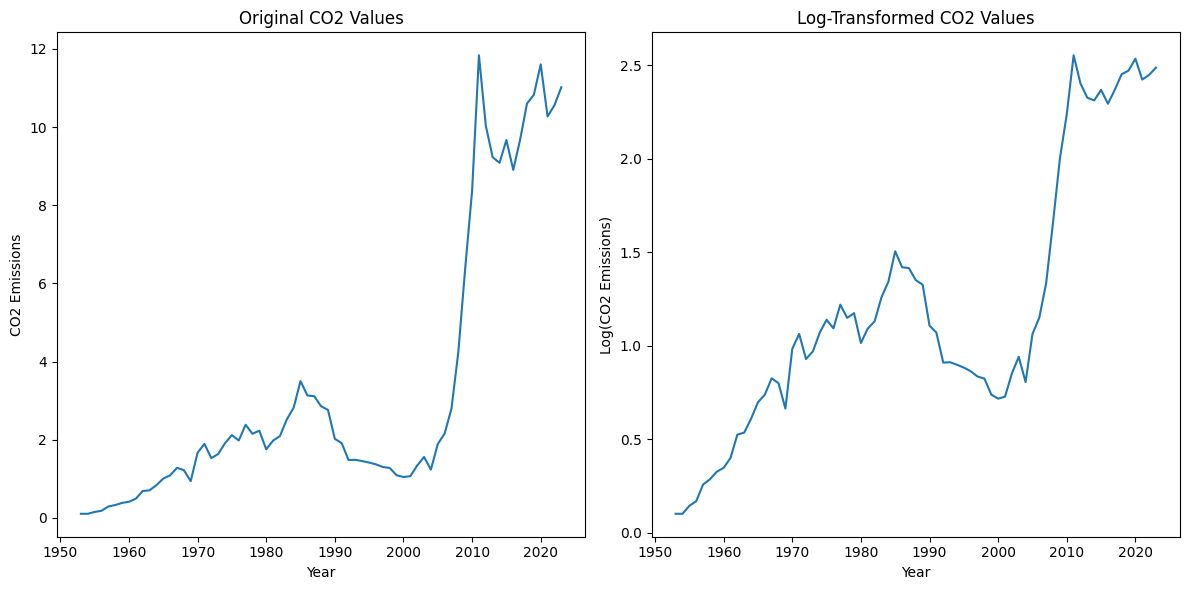

Training data shape: (63, 38)
Testing data shape: (8, 38)

Performing grid search for ARIMA parameters (keeping d=1)...
ARIMA(1,1,1) - AIC: -85.4454, BIC: -79.0640, RMSE: 0.7653
ARIMA(1,1,2) - AIC: -84.0828, BIC: -75.5743, RMSE: 0.9032
ARIMA(1,1,3) - AIC: -82.3078, BIC: -71.6721, RMSE: 0.8604
ARIMA(1,1,4) - AIC: -84.0843, BIC: -71.3215, RMSE: 0.5605
ARIMA(2,1,1) - AIC: -83.9660, BIC: -75.4575, RMSE: 0.8633
ARIMA(2,1,2) - AIC: -83.8778, BIC: -73.2422, RMSE: 1.0055
ARIMA(2,1,3) - AIC: -81.5414, BIC: -68.7786, RMSE: 0.4250
ARIMA(2,1,4) - AIC: -82.1170, BIC: -67.2271, RMSE: 0.7065
ARIMA(3,1,1) - AIC: -82.0041, BIC: -71.3684, RMSE: 0.8819
ARIMA(3,1,2) - AIC: -84.6084, BIC: -71.8456, RMSE: 0.3968
ARIMA(3,1,3) - AIC: -80.2050, BIC: -65.3151, RMSE: 3.9586
ARIMA(3,1,4) - AIC: -82.9561, BIC: -65.9390, RMSE: 0.5147
ARIMA(4,1,1) - AIC: -82.7648, BIC: -70.0020, RMSE: 1.2684
ARIMA(4,1,2) - AIC: -81.6801, BIC: -66.7901, RMSE: 1.0020
ARIMA(4,1,3) - AIC: -83.9492, BIC: -66.9321, RMSE: 0.5840
ARIMA(4,1,

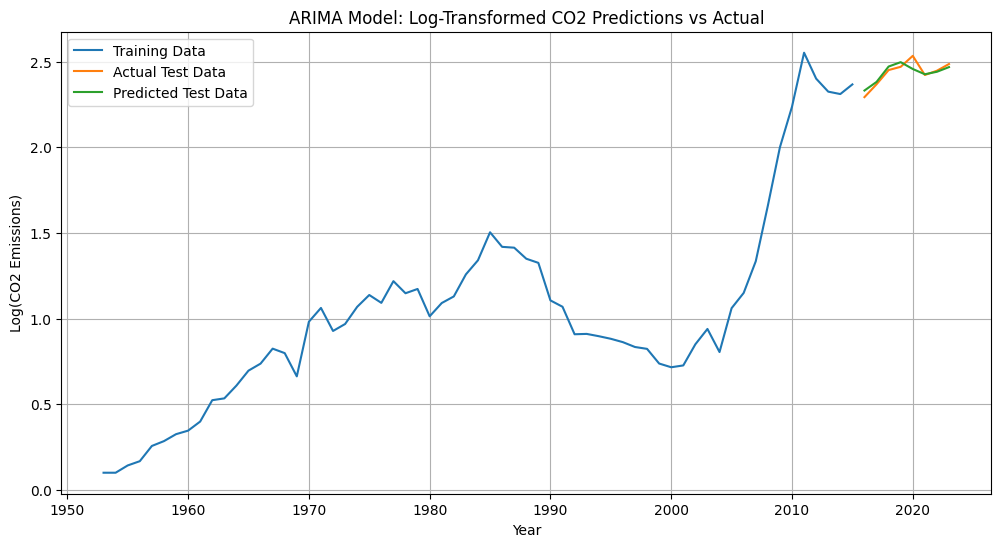

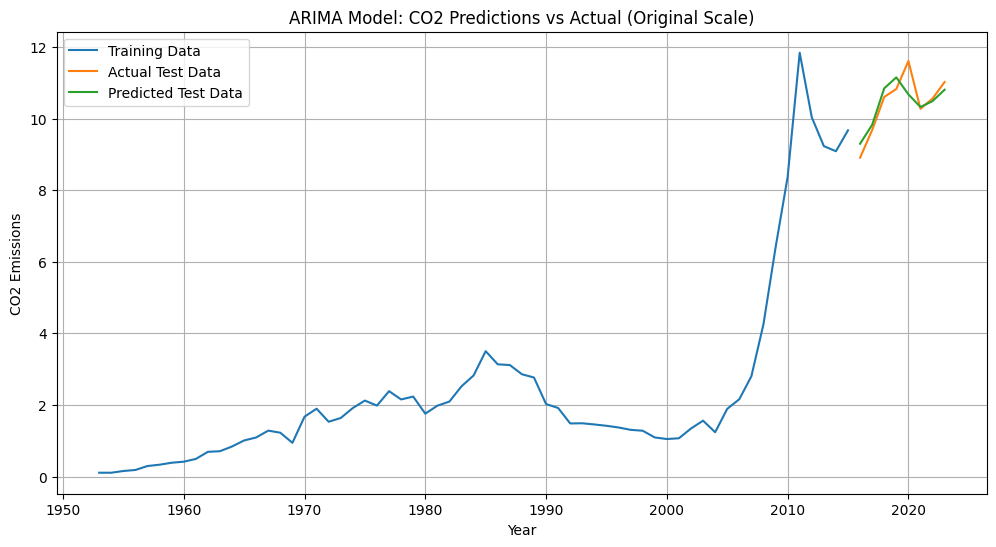

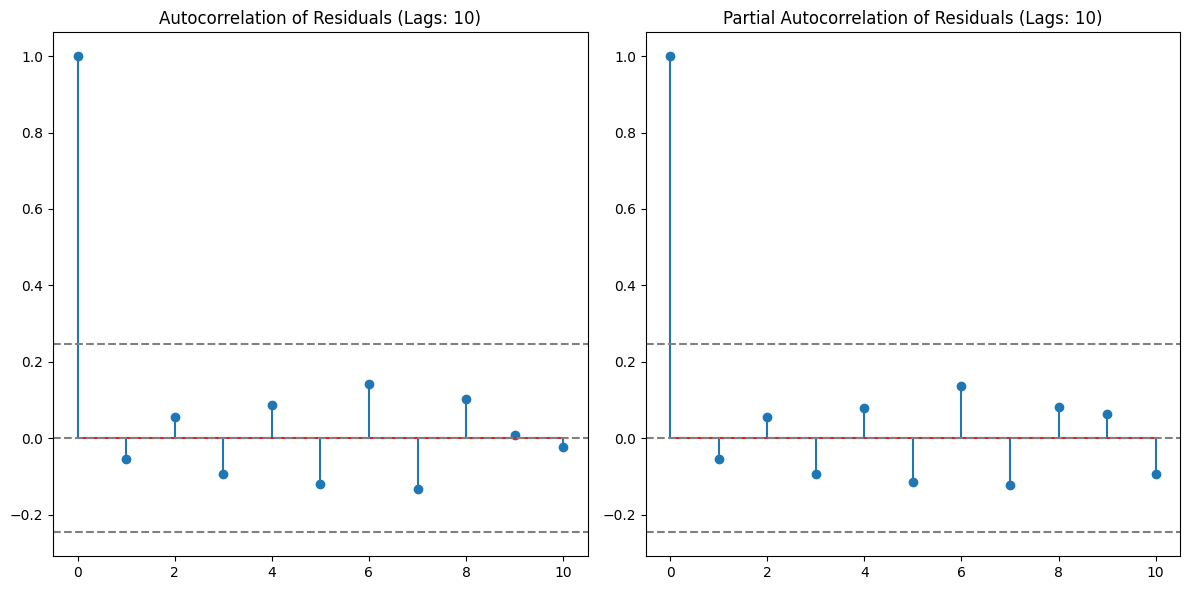


Forecasted CO2 emissions for the next 10 years:
      forecast_co2  pct_change  pct_change_from_last_historical
year                                                           
2024     10.730080         NaN                        -2.630857
2025     10.263440   -4.348892                        -6.865336
2026     10.230909   -0.316964                        -7.160540
2027     10.505326    2.682238                        -4.670365
2028     10.634255    1.227272                        -3.500411
2029     10.502374   -1.240154                        -4.697154
2030     10.365884   -1.299609                        -5.935719
2031     10.394849    0.279431                        -5.672873
2032     10.495140    0.964809                        -4.762797
2033     10.516706    0.205488                        -4.567096


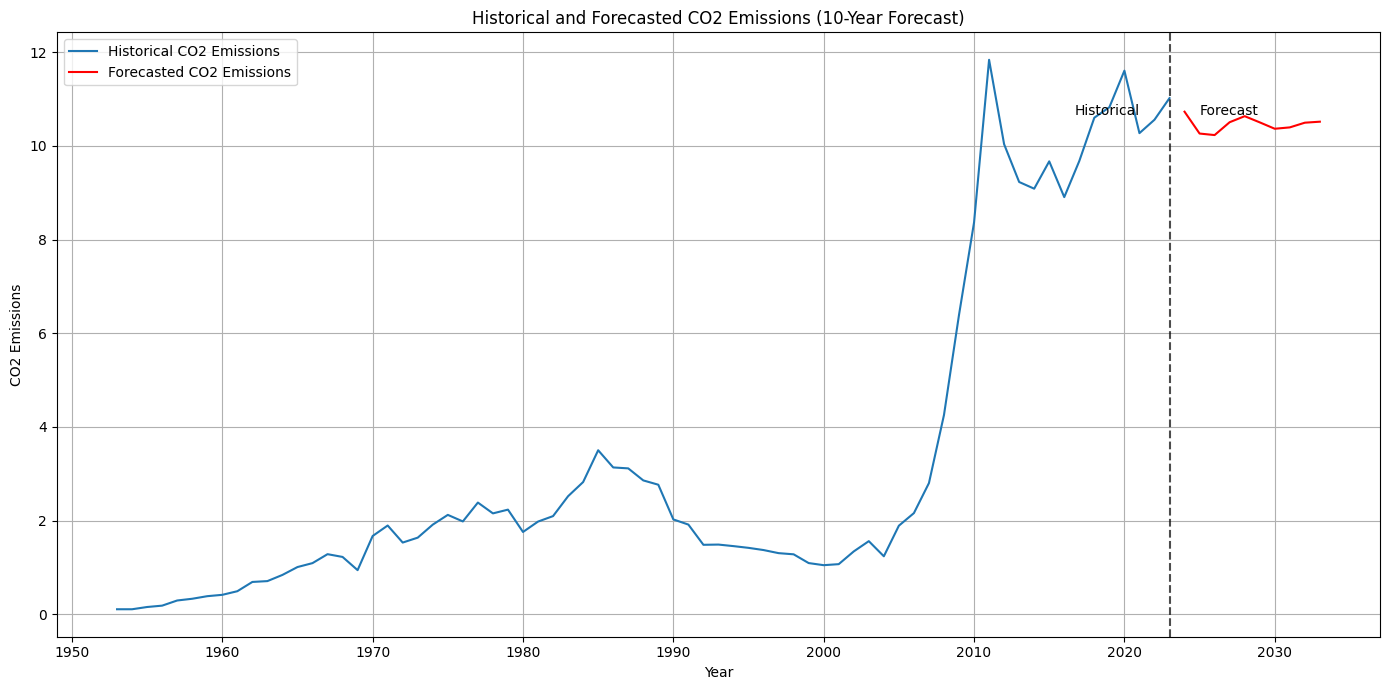

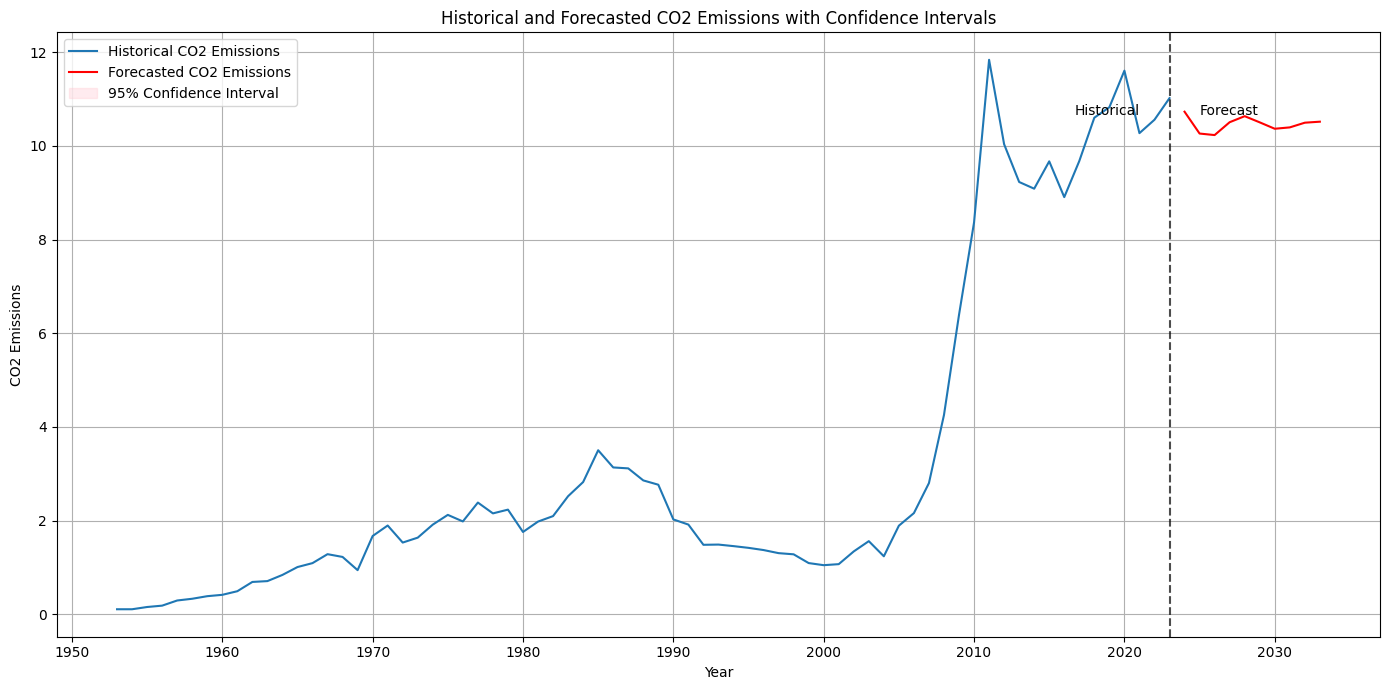

Forecast results saved to 'co2_forecast_results.csv'

Summary of Forecasted CO2 Emission Changes:
Average annual percentage change: -0.21%
Total percentage change over forecast period: -4.57%
Minimum annual percentage change: -4.35%
Maximum annual percentage change: 2.68%


In [35]:
df_final=df_ma.copy()

# Set year as index
df_final.set_index('year', inplace=True)

# Plot the original and log-transformed CO2 values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(df_final.index, df_final['co2'])
plt.title('Original CO2 Values')
plt.xlabel('Year')
plt.ylabel('CO2 Emissions')


plt.subplot(1, 2, 2)
plt.plot(df_final.index, df_final['log_co2'])
plt.title('Log-Transformed CO2 Values')
plt.xlabel('Year')
plt.ylabel('Log(CO2 Emissions)')
plt.tight_layout()
plt.show()

# Split the data into training and testing sets (80% for training)
train_size = int(len(df_final) * 0.9)
train_data = df_final.iloc[:train_size]
test_data = df_final.iloc[train_size:]

print(f"Training data shape: {train_data.shape}")
print(f"Testing data shape: {test_data.shape}")

# Function to fit ARIMA model and make predictions
def fit_arima_model(train_series, test_series, order=(1, 1, 1)):
    # Fit the ARIMA model
    model = ARIMA(train_series, order=order)
    model_fit = model.fit()
    
    # Summary of the model
    print(model_fit.summary())
    
    # Calculate residuals
    residuals = pd.Series(model_fit.resid, index=train_series.index)
    
    # Make predictions for test data
    predictions = model_fit.forecast(steps=len(test_series))
    
    # Convert predictions back to original scale
    original_scale_preds = np.expm1(predictions)
    original_scale_actual = np.expm1(test_series)
    
    # Evaluate the model
    mse = mean_squared_error(original_scale_actual, original_scale_preds)
    rmse = sqrt(mse)
    mae = mean_absolute_error(original_scale_actual, original_scale_preds)
    r2 = r2_score(original_scale_actual, original_scale_preds)
    
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"Root Mean Squared Error: {rmse:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"R-squared: {r2:.4f}")
    
    return model_fit, predictions, original_scale_preds, original_scale_actual, residuals

# Function to plot results
def plot_results(train_series, test_series, predictions, original_scale_preds, original_scale_actual):
    # Plot log-transformed results
    plt.figure(figsize=(12, 6))
    plt.plot(train_series.index, train_series, label='Training Data')
    plt.plot(test_series.index, test_series, label='Actual Test Data')
    plt.plot(test_series.index, predictions, label='Predicted Test Data')
    plt.title('ARIMA Model: Log-Transformed CO2 Predictions vs Actual')
    plt.xlabel('Year')
    plt.ylabel('Log(CO2 Emissions)')
    plt.legend()
    plt.grid(True)
  
    
    # Plot original scale results
    plt.figure(figsize=(12, 6))
    plt.plot(train_data.index, np.expm1(train_series), label='Training Data')
    plt.plot(test_series.index, original_scale_actual, label='Actual Test Data')
    plt.plot(test_series.index, original_scale_preds, label='Predicted Test Data')
    plt.title('ARIMA Model: CO2 Predictions vs Actual (Original Scale)')
    plt.xlabel('Year')
    plt.ylabel('CO2 Emissions')
    plt.legend()
    plt.grid(True)
    plt.show()

# Perform a grid search to find the best ARIMA parameters
# Define the p and q parameters to test (keeping d=1)
p_values = range(1, 5)
q_values = range(1, 5)

# Create a DataFrame to store results
grid_results = pd.DataFrame(columns=['p', 'd', 'q', 'AIC', 'BIC', 'RMSE'])

# Perform the grid search
print("\nPerforming grid search for ARIMA parameters (keeping d=1)...")
best_rmse = float('inf')
best_order = None

for p, q in itertools.product(p_values, q_values):
    try:
        # Define the order
        order = (p, 1, q)
        
        # Fit the model
        model = ARIMA(train_data['log_co2'], order=order)
        model_fit = model.fit()
        
        # Make predictions
        predictions = model_fit.forecast(steps=len(test_data))
        
        # Convert to original scale
        original_scale_preds = np.expm1(predictions)
        original_scale_actual = np.expm1(test_data['log_co2'])
        
        # Calculate RMSE
        mse = mean_squared_error(original_scale_actual, original_scale_preds)
        rmse = sqrt(mse)
        
        # Store the results
        grid_results = pd.concat([grid_results, pd.DataFrame({
            'p': [p],
            'd': [1],
            'q': [q],
            'AIC': [model_fit.aic],
            'BIC': [model_fit.bic],
            'RMSE': [rmse]
        })], ignore_index=True)
        
        print(f"ARIMA({p},1,{q}) - AIC: {model_fit.aic:.4f}, BIC: {model_fit.bic:.4f}, RMSE: {rmse:.4f}")
        
        # Update the best model if this one is better
        if rmse < best_rmse:
            best_rmse = rmse
            best_order = order
            
    except Exception as e:
        print(f"Error with ARIMA({p},1,{q}): {str(e)}")
        continue

# Sort the results by RMSE
grid_results = grid_results.sort_values('RMSE')
print("\nGrid search results (sorted by RMSE):")
print(grid_results)

print(f"\nBest ARIMA order based on RMSE: {best_order}")

# Fit the best model
print(f"\nFitting ARIMA{best_order} model on training data...")
model_fit, predictions, original_scale_preds, original_scale_actual, residuals = fit_arima_model(
    train_data['log_co2'], 
    test_data['log_co2'],
    order=best_order
)

# Plot the results
plot_results(train_data['log_co2'], test_data['log_co2'], predictions, original_scale_preds, original_scale_actual)

# Plot the residuals - only ACF and PACF for the best model
plt.figure(figsize=(12, 6))
nlags=10
# # ACF of residuals
plt.subplot(121)
plt.stem(acf(residuals, nlags=nlags))
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(residuals)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(residuals)), linestyle='--', color='gray')
plt.title(f'Autocorrelation of Residuals (Lags: {nlags})')

# # PACF of residuals
plt.subplot(122)
plt.stem(pacf(residuals, nlags=nlags))
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(residuals)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(residuals)), linestyle='--', color='gray')
plt.title(f'Partial Autocorrelation of Residuals (Lags: {nlags})')

plt.tight_layout()
plt.show()

# Make forecast for the next 10 years
last_year = df_final.index.max()
forecast_years = list(range(last_year + 1, last_year + 11))

# Fit the model on the entire dataset using the best parameters from grid search
full_model = ARIMA(df_final['log_co2'], order=best_order)
full_model_fit = full_model.fit()

# Plot residuals for the full model - only ACF and PACF
# Just use the final model directly, don't create redundant plots
# We already have the ACF/PACF plots for the best model above

# Generate forecasts in log-transformed scale
forecast = full_model_fit.forecast(steps=10)

# Convert forecasts back to original scale
forecast_original = np.expm1(forecast)

# Create a DataFrame for forecasts
forecast_df = pd.DataFrame({
    'year': forecast_years,
    'forecast_log_co2': forecast,
    'forecast_co2': forecast_original
})
forecast_df.set_index('year', inplace=True)

# Calculate percentage change from previous year
forecast_df['pct_change'] = forecast_df['forecast_co2'].pct_change() * 100
# Calculate percentage change from the last historical year
last_historical_co2 = df_final['co2'].iloc[-1]
forecast_df['pct_change_from_last_historical'] = ((forecast_df['forecast_co2'] - last_historical_co2) / last_historical_co2) * 100

print("\nForecasted CO2 emissions for the next 10 years:")
print(forecast_df[['forecast_co2', 'pct_change', 'pct_change_from_last_historical']])

# Plot the historical data and forecast
plt.figure(figsize=(14, 7))
plt.plot(df_final.index, df_final['co2'], label='Historical CO2 Emissions')
plt.plot(forecast_df.index, forecast_df['forecast_co2'], label='Forecasted CO2 Emissions', color='red')

# Add a vertical line to separate historical data from forecast
plt.axvline(x=last_year, color='black', linestyle='--', alpha=0.7)
plt.text(last_year - 2, df_final['co2'].max() * 0.9, 'Historical', ha='right')
plt.text(last_year + 2, df_final['co2'].max() * 0.9, 'Forecast', ha='left')

plt.title('Historical and Forecasted CO2 Emissions (10-Year Forecast)')
plt.xlabel('Year')
plt.ylabel('CO2 Emissions')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Create a DataFrame with confidence intervals for the forecast
conf_int = full_model_fit.get_forecast(steps=10).conf_int()
conf_int_original = np.expm1(conf_int)
forecast_df['lower_ci'] = conf_int_original.iloc[:, 0]
forecast_df['upper_ci'] = conf_int_original.iloc[:, 1]

# Plot with confidence intervals
plt.figure(figsize=(14, 7))
plt.plot(df_final.index, df_final['co2'], label='Historical CO2 Emissions')
plt.plot(forecast_df.index, forecast_df['forecast_co2'], label='Forecasted CO2 Emissions', color='red')

# Add confidence intervals
plt.fill_between(forecast_df.index, 
                 forecast_df['lower_ci'], 
                 forecast_df['upper_ci'], 
                 color='pink', alpha=0.3, 
                 label='95% Confidence Interval')

# Add a vertical line to separate historical data from forecast
plt.axvline(x=last_year, color='black', linestyle='--', alpha=0.7)
plt.text(last_year - 2, df_final['co2'].max() * 0.9, 'Historical', ha='right')
plt.text(last_year + 2, df_final['co2'].max() * 0.9, 'Forecast', ha='left')

plt.title('Historical and Forecasted CO2 Emissions with Confidence Intervals')
plt.xlabel('Year')
plt.ylabel('CO2 Emissions')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
# Save the forecast to a CSV file
forecast_df.to_csv('co2_forecast_results.csv')
print("Forecast results saved to 'co2_forecast_results.csv'")

# Print a summary of forecasted percentage changes
print("\nSummary of Forecasted CO2 Emission Changes:")
print(f"Average annual percentage change: {forecast_df['pct_change'].mean():.2f}%")
print(f"Total percentage change over forecast period: {forecast_df['pct_change_from_last_historical'].iloc[-1]:.2f}%")
print(f"Minimum annual percentage change: {forecast_df['pct_change'].min():.2f}%")
print(f"Maximum annual percentage change: {forecast_df['pct_change'].max():.2f}%")

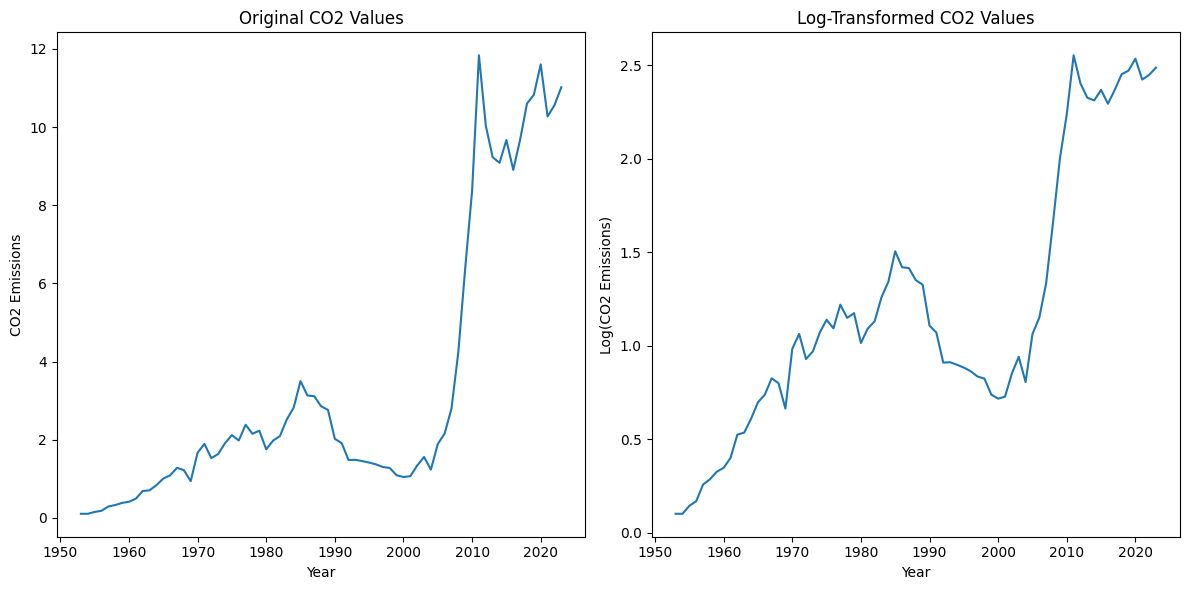

Training data shape: (63, 38)
Testing data shape: (8, 38)

Performing expanded grid search for SARIMA parameters...
Testing 28 different parameter combinations
SARIMA(3,1,3)x(0,0,0,4) - AIC: -70.2963, BIC: -55.8732, RMSE: 1.4345
SARIMA(3,1,3)x(0,0,0,6) - AIC: -70.2963, BIC: -55.8732, RMSE: 1.4345
SARIMA(3,1,4)x(0,0,0,4) - AIC: -71.3840, BIC: -55.0396, RMSE: 0.4806
SARIMA(3,1,4)x(0,0,0,6) - AIC: -71.3840, BIC: -55.0396, RMSE: 0.4806
SARIMA(4,1,3)x(0,0,0,4) - AIC: -72.9512, BIC: -56.4677, RMSE: 0.7356
SARIMA(4,1,3)x(0,0,0,6) - AIC: -72.9512, BIC: -56.4677, RMSE: 0.7356
SARIMA(4,1,4)x(0,0,0,4) - AIC: -69.5219, BIC: -51.1344, RMSE: 0.5108
SARIMA(4,1,4)x(0,0,0,6) - AIC: -69.5219, BIC: -51.1344, RMSE: 0.5108
SARIMA(5,1,3)x(0,0,0,4) - AIC: -67.2057, BIC: -48.8182, RMSE: 0.9989
SARIMA(5,1,3)x(0,0,0,6) - AIC: -67.2057, BIC: -48.8182, RMSE: 0.9989
SARIMA(5,1,4)x(0,0,0,4) - AIC: -66.4582, BIC: -46.0277, RMSE: 0.4880
SARIMA(5,1,4)x(0,0,0,6) - AIC: -66.4582, BIC: -46.0277, RMSE: 0.4880
SARIMA(6,1,3

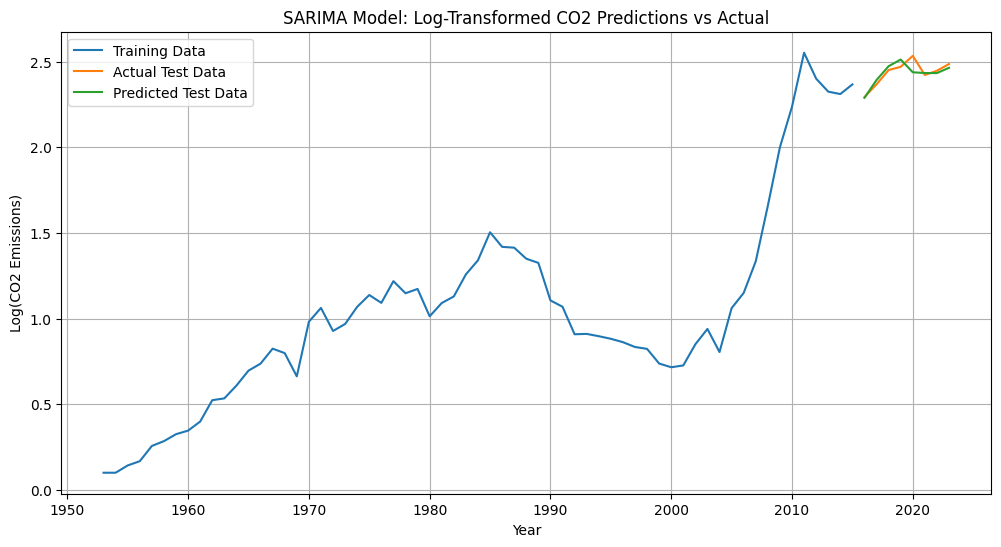

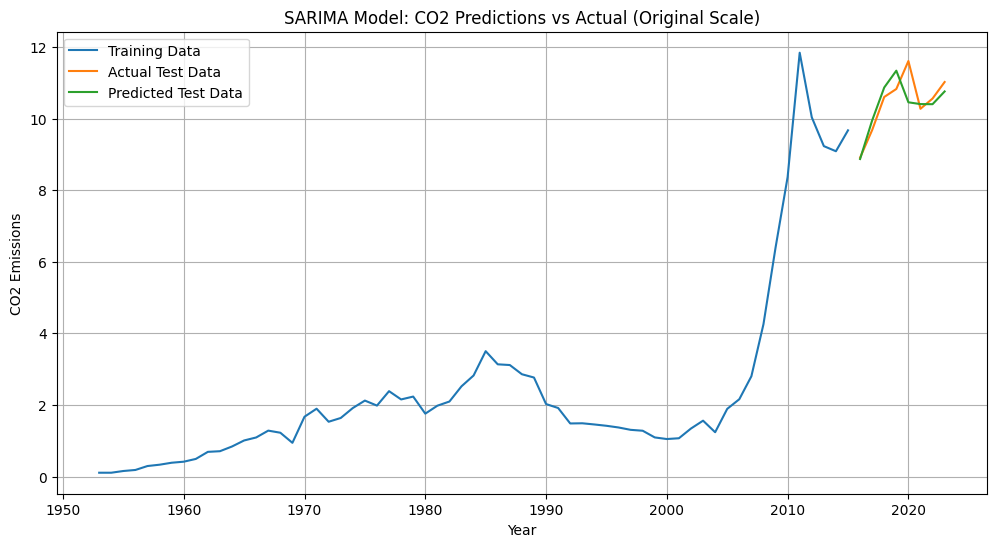


Forecasted CO2 emissions for the next 10 years:
      forecast_co2  pct_change  pct_change_from_last_historical
year                                                           
2024     10.866658   -1.391488                        -1.391488
2025      9.988548   -8.080775                        -9.359820
2026     10.203103    2.148013                        -7.412858
2027     10.391381    1.845305                        -5.704343
2028     10.597644    1.984940                        -3.832630
2029     10.381043   -2.043858                        -5.798155
2030     10.349517   -0.303690                        -6.084237
2031     10.335252   -0.137834                        -6.213684
2032     10.431003    0.926450                        -5.344801
2033     10.406464   -0.235246                        -5.567474


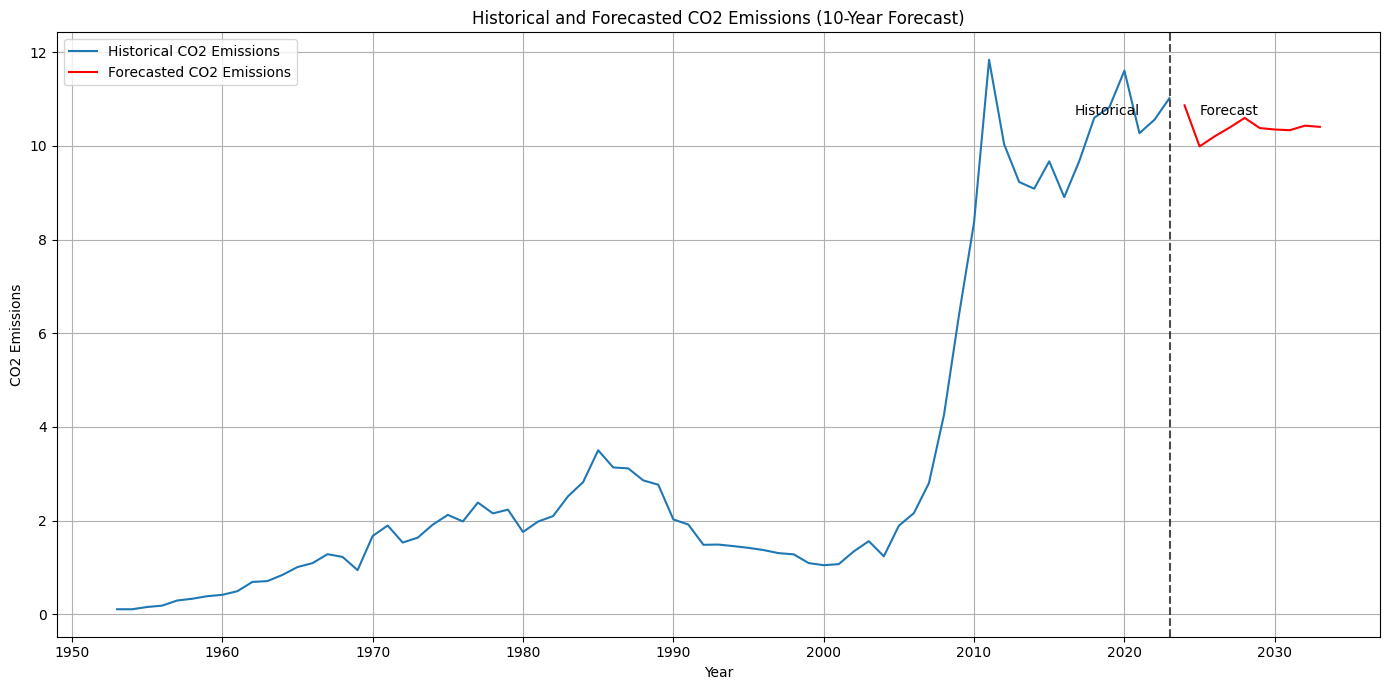

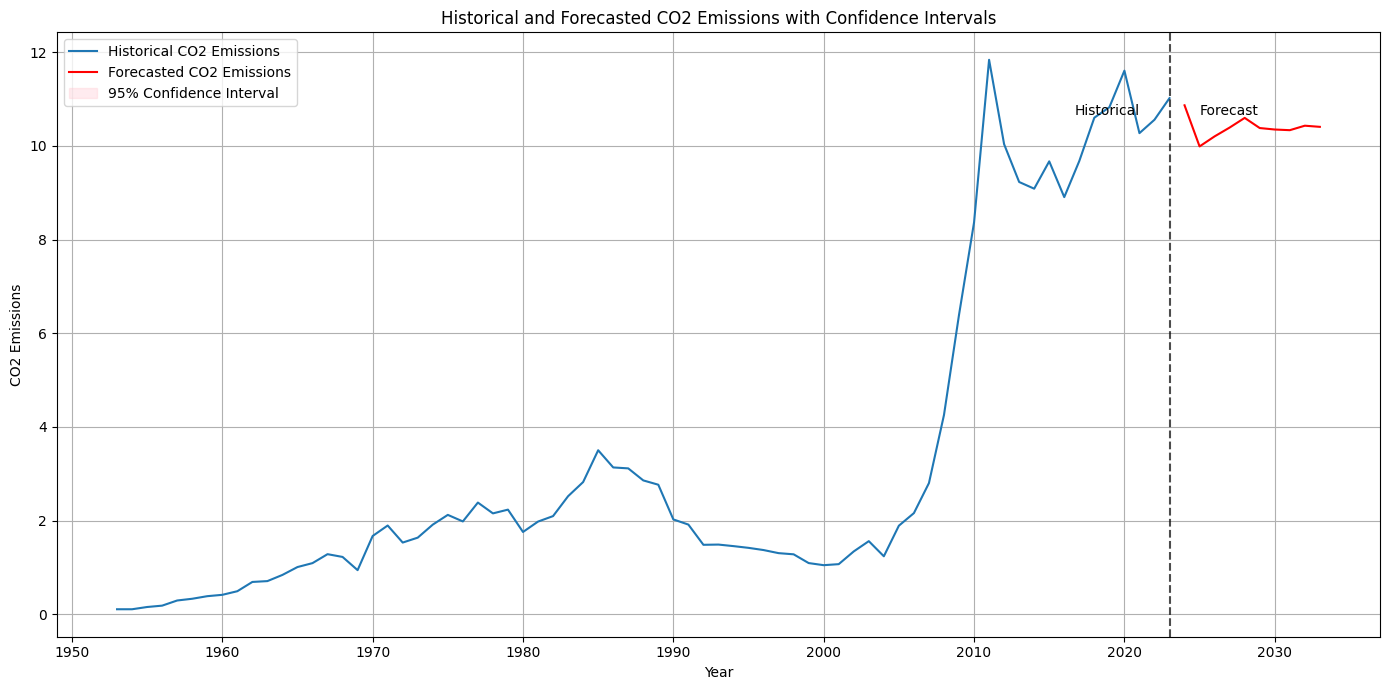


Summary of Forecasted CO2 Emission Changes:
Average annual percentage change: -0.53%
Total percentage change over forecast period: -5.57%
Minimum annual percentage change: -8.08%
Maximum annual percentage change: 2.15%


In [36]:
#Seasonal ARIMA

# Plot the original and log-transformed CO2 values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(df_final.index, df_final['co2'])
plt.title('Original CO2 Values')
plt.xlabel('Year')
plt.ylabel('CO2 Emissions')

plt.subplot(1, 2, 2)
plt.plot(df_final.index, df_final['log_co2'])
plt.title('Log-Transformed CO2 Values')
plt.xlabel('Year')
plt.ylabel('Log(CO2 Emissions)')
plt.tight_layout()
plt.show()

# Split the data into training and testing sets (90% for training)
train_size = int(len(df_final) * 0.9)
train_data = df_final.iloc[:train_size]
test_data = df_final.iloc[train_size:]

print(f"Training data shape: {train_data.shape}")
print(f"Testing data shape: {test_data.shape}")

# Function to fit SARIMA model and make predictions
def fit_sarima_model(train_series, test_series, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0)):
    # Fit the SARIMA model
    model = SARIMAX(train_series, 
                   order=order,
                   seasonal_order=seasonal_order,
                   enforce_stationarity=False,
                   enforce_invertibility=False)
    model_fit = model.fit(disp=False)
    
    # Summary of the model
    print(model_fit.summary())
    
    # Calculate residuals
    residuals = pd.Series(model_fit.resid, index=train_series.index)
    
    # Make predictions for test data
    predictions = model_fit.forecast(steps=len(test_series))
    
    # Convert predictions back to original scale
    original_scale_preds = np.expm1(predictions)
    original_scale_actual = np.expm1(test_series)
    
    # Evaluate the model
    mse = mean_squared_error(original_scale_actual, original_scale_preds)
    rmse = sqrt(mse)
    mae = mean_absolute_error(original_scale_actual, original_scale_preds)
    r2 = r2_score(original_scale_actual, original_scale_preds)
    
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"Root Mean Squared Error: {rmse:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"R-squared: {r2:.4f}")
    
    return model_fit, predictions, original_scale_preds, original_scale_actual, residuals

# Function to plot results
def plot_results(train_series, test_series, predictions, original_scale_preds, original_scale_actual):
    # Plot log-transformed results
    plt.figure(figsize=(12, 6))
    plt.plot(train_series.index, train_series, label='Training Data')
    plt.plot(test_series.index, test_series, label='Actual Test Data')
    plt.plot(test_series.index, predictions, label='Predicted Test Data')
    plt.title('SARIMA Model: Log-Transformed CO2 Predictions vs Actual')
    plt.xlabel('Year')
    plt.ylabel('Log(CO2 Emissions)')
    plt.legend()
    plt.grid(True)
    
    # Plot original scale results
    plt.figure(figsize=(12, 6))
    plt.plot(train_data.index, np.expm1(train_series), label='Training Data')
    plt.plot(test_series.index, original_scale_actual, label='Actual Test Data')
    plt.plot(test_series.index, original_scale_preds, label='Predicted Test Data')
    plt.title('SARIMA Model: CO2 Predictions vs Actual (Original Scale)')
    plt.xlabel('Year')
    plt.ylabel('CO2 Emissions')
    plt.legend()
    plt.grid(True)
    plt.show()

# Create a more comprehensive parameter grid
param_combinations = []

# Generate combinations with expanded ranges
for p in range(3, 10):  # p from 0 to 3
    for q in range(3, 5):  # q from 0 to 2
        for s in [4,6]:
            # Add combinations with both D=0 and D=1
            D=0

            # Add non-seasonal models
            param_combinations.append((p, 1, q, 0, D, 0, s))

            # Add seasonal models with expanded P and Q ranges
            for P in range(0, 1):  # P from 0 to 2
                for Q in range(0, 1):  # Q from 0 to 2
                    # Skip if both P and Q are 0 as it's equivalent to non-seasonal
                    if P > 0 or Q > 0:
                        param_combinations.append((p, 1, q, P, D, Q, s))

# Create a DataFrame to store results
grid_results = pd.DataFrame(columns=['p', 'd', 'q', 'P', 'D', 'Q', 's', 'AIC', 'BIC', 'RMSE'])

# Perform the grid search
print("\nPerforming expanded grid search for SARIMA parameters...")
print(f"Testing {len(param_combinations)} different parameter combinations")
best_rmse = float('inf')
best_order = None
best_seasonal_order = None

for params in param_combinations:
    p, d, q, P, D, Q, s = params
    
    try:
        # Define the order and seasonal order
        order = (p, d, q)
        seasonal_order = (P, D, Q, s)
        
        # Fit the model
        model = SARIMAX(train_data['log_co2'],
                       order=order,
                       seasonal_order=seasonal_order,
                       enforce_stationarity=False,
                       enforce_invertibility=False)
        model_fit = model.fit(disp=False)
        
        # Make predictions
        predictions = model_fit.forecast(steps=len(test_data))
        
        # Convert to original scale
        original_scale_preds = np.expm1(predictions)
        original_scale_actual = np.expm1(test_data['log_co2'])
        
        # Calculate RMSE
        mse = mean_squared_error(original_scale_actual, original_scale_preds)
        rmse = sqrt(mse)
        
        # Store the results
        grid_results = pd.concat([grid_results, pd.DataFrame({
            'p': [p],
            'd': [d],
            'q': [q],
            'P': [P],
            'D': [D],
            'Q': [Q],
            's': [s],
            'AIC': [model_fit.aic],
            'BIC': [model_fit.bic],
            'RMSE': [rmse]
        })], ignore_index=True)
        
        print(f"SARIMA({p},{d},{q})x({P},{D},{Q},{s}) - AIC: {model_fit.aic:.4f}, BIC: {model_fit.bic:.4f}, RMSE: {rmse:.4f}")
        
        # Update the best model if this one is better
        if rmse < best_rmse:
            best_rmse = rmse
            best_order = order
            best_seasonal_order = seasonal_order
            
    except Exception as e:
        print(f"Error with SARIMA({p},{d},{q})x({P},{D},{Q},{s}): {str(e)}")
        continue

# Sort the results by RMSE
grid_results = grid_results.sort_values('RMSE')
print("\nGrid search results (sorted by RMSE):")
print(grid_results)

# Check if best_order is None and provide a default
if best_order is None or best_seasonal_order is None:
    print("\nWarning: Grid search failed to find an optimal model. Using default parameters.")
    best_order = (1, 1, 1)
    best_seasonal_order = (0, 0, 0, 12)
else:
    print(f"\nBest SARIMA order based on RMSE: SARIMA{best_order}x{best_seasonal_order}")

# Fit the best model
print(f"\nFitting SARIMA{best_order}x{best_seasonal_order} model on training data...")
model_fit, predictions, original_scale_preds, original_scale_actual, residuals = fit_sarima_model(
    train_data['log_co2'], 
    test_data['log_co2'],
    order=best_order,
    seasonal_order=best_seasonal_order
)

# Plot the results
plot_results(train_data['log_co2'], test_data['log_co2'], predictions, original_scale_preds, original_scale_actual)

# # Plot the residuals - only ACF and PACF for the best model
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# # ACF of residuals
# plot_acf(residuals, lags=20, title='ACF of Residuals', zero=False, ax=ax1)
# ax1.grid(True)

# # PACF of residuals
# plot_pacf(residuals, lags=20, title='PACF of Residuals', zero=False, ax=ax2)
# ax2.grid(True)

# plt.tight_layout()
# plt.show()

# Make forecast for the next 10 years
last_year = df_final.index.max()
forecast_years = list(range(last_year + 1, last_year + 11))

# Fit the model on the entire dataset using the best parameters
full_model = SARIMAX(df_final['log_co2'],
                   order=best_order,
                   seasonal_order=best_seasonal_order,
                   enforce_stationarity=False,
                   enforce_invertibility=False)
full_model_fit = full_model.fit(disp=False)

# Generate forecasts in log-transformed scale
forecast = full_model_fit.forecast(steps=10)

# Convert forecasts back to original scale
forecast_original = np.expm1(forecast)

# Create a DataFrame for forecasts
forecast_df = pd.DataFrame({
    'year': forecast_years,
    'forecast_log_co2': forecast,
    'forecast_co2': forecast_original
})
forecast_df.set_index('year', inplace=True)

# Calculate percentage change from previous year
forecast_df['pct_change'] = forecast_df['forecast_co2'].pct_change() * 100
# First row will be NaN, calculate it relative to the last historical value
last_historical_co2 = df_final['co2'].iloc[-1]
forecast_df.loc[forecast_df.index[0], 'pct_change'] = ((forecast_df['forecast_co2'].iloc[0] - last_historical_co2) / last_historical_co2) * 100

# Calculate percentage change from the last historical year
forecast_df['pct_change_from_last_historical'] = ((forecast_df['forecast_co2'] - last_historical_co2) / last_historical_co2) * 100

print("\nForecasted CO2 emissions for the next 10 years:")
print(forecast_df[['forecast_co2', 'pct_change', 'pct_change_from_last_historical']])

# Plot the historical data and forecast
plt.figure(figsize=(14, 7))
plt.plot(df_final.index, df_final['co2'], label='Historical CO2 Emissions')
plt.plot(forecast_df.index, forecast_df['forecast_co2'], label='Forecasted CO2 Emissions', color='red')

# Add a vertical line to separate historical data from forecast
plt.axvline(x=last_year, color='black', linestyle='--', alpha=0.7)
plt.text(last_year - 2, df_final['co2'].max() * 0.9, 'Historical', ha='right')
plt.text(last_year + 2, df_final['co2'].max() * 0.9, 'Forecast', ha='left')

plt.title('Historical and Forecasted CO2 Emissions (10-Year Forecast)')
plt.xlabel('Year')
plt.ylabel('CO2 Emissions')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Create a DataFrame with confidence intervals for the forecast
conf_int = full_model_fit.get_forecast(steps=10).conf_int()
conf_int_original = np.expm1(conf_int)
forecast_df['lower_ci'] = conf_int_original.iloc[:, 0]
forecast_df['upper_ci'] = conf_int_original.iloc[:, 1]

# Plot with confidence intervals
plt.figure(figsize=(14, 7))
plt.plot(df_final.index, df_final['co2'], label='Historical CO2 Emissions')
plt.plot(forecast_df.index, forecast_df['forecast_co2'], label='Forecasted CO2 Emissions', color='red')

# Add confidence intervals
plt.fill_between(forecast_df.index, 
                 forecast_df['lower_ci'], 
                 forecast_df['upper_ci'], 
                 color='pink', alpha=0.3, 
                 label='95% Confidence Interval')

# Add a vertical line to separate historical data from forecast
plt.axvline(x=last_year, color='black', linestyle='--', alpha=0.7)
plt.text(last_year - 2, df_final['co2'].max() * 0.9, 'Historical', ha='right')
plt.text(last_year + 2, df_final['co2'].max() * 0.9, 'Forecast', ha='left')

plt.title('Historical and Forecasted CO2 Emissions with Confidence Intervals')
plt.xlabel('Year')
plt.ylabel('CO2 Emissions')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print a summary of forecasted percentage changes
print("\nSummary of Forecasted CO2 Emission Changes:")
print(f"Average annual percentage change: {forecast_df['pct_change'].mean():.2f}%")
print(f"Total percentage change over forecast period: {forecast_df['pct_change_from_last_historical'].iloc[-1]:.2f}%")
print(f"Minimum annual percentage change: {forecast_df['pct_change'].min():.2f}%")
print(f"Maximum annual percentage change: {forecast_df['pct_change'].max():.2f}%")

### LSTM- Long short term memory model

#### Univariate LSTM with lag variables and moving average of target variable

In [129]:
from scipy import stats
import warnings
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import time

In [130]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [131]:
df= df_ma.copy()
df.isnull().sum()

year                           0
gdp                            0
PC_coal_1                      0
PC_coal_2                      0
PC_oil_1                       0
PC_oil_2                       0
PC_cement_1                    0
PC_cement_2                    0
PC_gas_1                       0
PC_gas_2                       0
PC_landuse_2                   0
PC_flaring_1                   0
PC_flaring_2                   0
PC_growth_1                    0
PC_growth_2                    0
PC_energy_1                    0
temperature_change_from_ch4    0
PC_ghg_2                       0
PC_methane_1                   0
primary_energy_consumption     0
co2_per_capita                 0
co2_per_gdp                    0
co2_per_unit_energy            0
share_global_co2               0
co2                            0
co2_lag_1                      0
co2_lag_2                      0
co2_lag_3                      0
co2_lag_4                      0
co2_lag_5                      0
co2_lag_6 

In [132]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [442]:
def create_multivariate_sequences(data, seq_length, target_col):
    """Create sequences for multivariate LSTM training.

    Args:
        data: DataFrame containing features and target
        seq_length: Number of time steps in each sequence
        target_col: Name of the target column

    Returns:
        X: Input sequences with shape (n_samples, seq_length, n_features)
        y: Target values with shape (n_samples, 1)
    """
    X, y = [], []

    # Get the index of the target column
    target_idx = data.columns.get_loc(target_col)

    # Convert to numpy array
    data_array = data.values

    for i in range(len(data_array) - seq_length):
        # Input sequence (all features)
        sequence = data_array[i:i+seq_length, :]

        # Target (next value of target column)
        target = data_array[i+seq_length, target_idx]

        X.append(sequence)
        y.append(target)

    return np.array(X), np.array(y).reshape(-1, 1) 

In [443]:
# Define groups of variables for different scaling methods
log_transform_vars = ['gdp','primary_energy_consumption','co2']
standard_scaler_vars = [
    'temperature_change_from_ch4',
    'co2_per_capita', 'co2_per_gdp','share_global_co2'
]
pc_vars = [col for col in df.columns if col.startswith('PC_')]

for col in log_transform_vars:
    if df[col].isnull().any():
        missing_count = df[col].isnull().sum()
        print(f"\nImputing {missing_count} missing values in {col}:")
        
        # Try forward fill first
        df[col] = df[col].fillna(method='ffill')
        
        # If there are still NaN values (e.g., at the beginning of the series)
        if df[col].isnull().any():
            # Try backward fill for remaining
            df[col] = df[col].fillna(method='bfill')
            
            # If STILL NaN values remain, use rolling window imputation
            if df[col].isnull().any():
                print(f"  Using rolling window imputation for remaining {df[col].isnull().sum()} NaN values")
                
                # Rolling window mean with window size 3 (adjust as needed)
                window_size = 3
                rolling_mean = df[col].rolling(window=window_size, min_periods=1, center=True).mean()
                df[col] = df[col].fillna(rolling_mean)
                
                # If any NaN values STILL remain (unlikely but possible)
                if df[col].isnull().any():
                    # Fill any remaining NaN with the column mean
                    col_mean = df[col].mean()
                    df[col] = df[col].fillna(col_mean)
                    print(f"  Filled remaining NaN with column mean: {col_mean}")
    
    # Apply log1p transformation
    df[f'log_{col}'] = np.log1p(df[col])  # log(1+x) to handle zeros
    
    # Print some stats to verify
    print(f"Log transformed {col}:")
    print(f"  Original range: {df[col].min()} to {df[col].max()}")
    print(f"  Log range: {df[f'log_{col}'].min()} to {df[f'log_{col}'].max()}")

Log transformed gdp:
  Original range: 7919856640.0 to 73085706240.0
  Log range: 22.792638941725084 to 25.014898647523456
Log transformed primary_energy_consumption:
  Original range: 4.428 to 42.005
  Log range: 1.6915707419726227 to 3.761316388003443
Log transformed co2:
  Original range: 0.106 to 11.838
  Log range: 0.10074990310014306 to 2.5524095228895862


In [444]:
# Create scalers
log_standard_scaler = StandardScaler()
regular_standard_scaler = StandardScaler()

# Extract columns for scaling
log_cols = [f'log_{col}' for col in log_transform_vars]
log_data = df[log_cols].copy()
standard_data = df[standard_scaler_vars].copy()

In [471]:
# Define an additional scaler for lag and MA variables
lag_ma_scaler = StandardScaler()



# Fit and transform log-transformed variables
log_scaled_data = log_standard_scaler.fit_transform(log_data)
# Fit and transform regular variables
standard_scaled_data = regular_standard_scaler.fit_transform(standard_data)
# Create a new dataframe with all the scaled data
scaled_df = pd.DataFrame(index=df.index)
scaled_df['year'] = df['year']  # Keep year unscaled
# Add log-scaled data
for i, col in enumerate(log_cols):
    scaled_df[col] = log_scaled_data[:, i]
# Add standard-scaled data
for i, col in enumerate(standard_scaler_vars):
    scaled_df[col] = standard_scaled_data[:, i]
# Add PC variables (already scaled)
for col in pc_vars:
    scaled_df[col] = df[col]


    
scaled_df=scaled_df.drop(['year','PC_energy_1','PC_flaring_1','PC_flaring_2'],axis=1)
# Print shape to verify
print(f"Final scaled dataframe shape: {scaled_df.shape}")
print(f"Columns: {scaled_df.columns.tolist()}")
print(scaled_df.head())

Final scaled dataframe shape: (71, 20)
Columns: ['log_gdp', 'log_primary_energy_consumption', 'log_co2', 'temperature_change_from_ch4', 'co2_per_capita', 'co2_per_gdp', 'share_global_co2', 'PC_coal_1', 'PC_coal_2', 'PC_oil_1', 'PC_oil_2', 'PC_cement_1', 'PC_cement_2', 'PC_gas_1', 'PC_gas_2', 'PC_landuse_2', 'PC_growth_1', 'PC_growth_2', 'PC_ghg_2', 'PC_methane_1']
    log_gdp  log_primary_energy_consumption   log_co2  \
4 -0.984573                       -0.596475 -1.576871   
5 -0.949486                       -0.596475 -1.576871   
6 -0.918616                       -0.596475 -1.515844   
7 -0.847606                       -0.596475 -1.480193   
8 -0.847919                       -0.596475 -1.352476   

   temperature_change_from_ch4  co2_per_capita  co2_per_gdp  share_global_co2  \
4                    -0.450988       -1.475470    -1.953926         -1.173659   
5                    -0.450988       -1.475470    -1.953926         -1.173659   
6                    -0.450988       -1.422923 

In [472]:
seq_length = 5

# Define target column (log transformed CO2)
target_col = 'log_co2'

# Lag variables (up to 5)
lag_vars = [
    'log_co2',
    'co2_lag_1',
    'co2_lag_2',
    'co2_lag_3',
    'co2_lag_4',


]

# Moving average variables
ma_vars = [
    'co2_ma_2',
    'co2_ma_3',
    'co2_ma_5'
]

# Combined list
time_series_vars = lag_vars + ma_vars
# Create sequences
X, y = create_multivariate_sequences(scaled_df, seq_length, target_col)

# Print shapes to verify
print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (66, 5, 20), y shape: (66, 1)


In [473]:
# Split data into training and testing sets
train_size = len(X) - 5  # Use last 10 years for testing
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert to PyTorch tensors and move to appropriate device
X_train = torch.FloatTensor(X_train).to(device)
y_train = torch.FloatTensor(y_train).to(device)
X_test = torch.FloatTensor(X_test).to(device)
y_test = torch.FloatTensor(y_test).to(device)

In [474]:
# Create PyTorch dataset and dataloader
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

batch_size = 4  # Small batch size for small dataset
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [475]:
class StandardLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(StandardLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                           batch_first=True, dropout=dropout if num_layers > 1 else 0)
        
        # Fully connected layers
        self.fc1 = nn.Linear(hidden_size, hidden_size//2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_size//2, output_size)
        
    def forward(self, x):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        lstm_out, (h_n, _) = self.lstm(x, (h0, c0))  # lstm_out: (batch_size, seq_length, hidden_size)
        
        # Use the output from the last time step
        out = lstm_out[:, -1, :]
        
        # Process through fully connected layers
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        
        return out

In [476]:
input_size = X.shape[2]  # Number of features
hidden_size=256
num_layers = 5
output_size = 1
dropout = 0.2  # Slightly increased dropout for regularization

# Create model and move to device
model = StandardLSTM(input_size, hidden_size, num_layers, output_size, dropout).to(device)

In [477]:
print(model)
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

StandardLSTM(
  (lstm): LSTM(20, 256, num_layers=5, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)
Total parameters: 2423041


In [478]:
# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # Added L2 regularization
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=15, verbose=True)

# Train the model
num_epochs = 200  # Increased epochs
train_losses = []
test_losses = []

# Early stopping parameters
patience =30
best_loss = float('inf')
counter = 0

# Add timing to monitor performance
start_time = time.time()

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        running_loss += loss.item()
    
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    
    # Testing phase
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
    
    test_loss = test_loss / len(test_loader)
    test_losses.append(test_loss)
    
    # Update learning rate
    scheduler.step(test_loss)
    
    # Early stopping check
    if test_loss < best_loss:
        best_loss = test_loss
        counter = 0
        # Save the best model
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': epoch,
            'loss': best_loss,
        }, 'afghanistan_co2_best_model.pth')
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    # Print progress
    if (epoch+1) % 20 == 0:
        elapsed = time.time() - start_time
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}, Time: {elapsed:.2f}s')

print(f"Total training time: {time.time() - start_time:.2f} seconds")

Epoch [20/200], Train Loss: 0.070384, Test Loss: 0.099638, Time: 3.97s
Epoch [40/200], Train Loss: 0.038505, Test Loss: 0.057954, Time: 7.75s
Epoch [60/200], Train Loss: 0.024161, Test Loss: 0.005825, Time: 11.52s
Early stopping at epoch 71
Total training time: 13.59 seconds


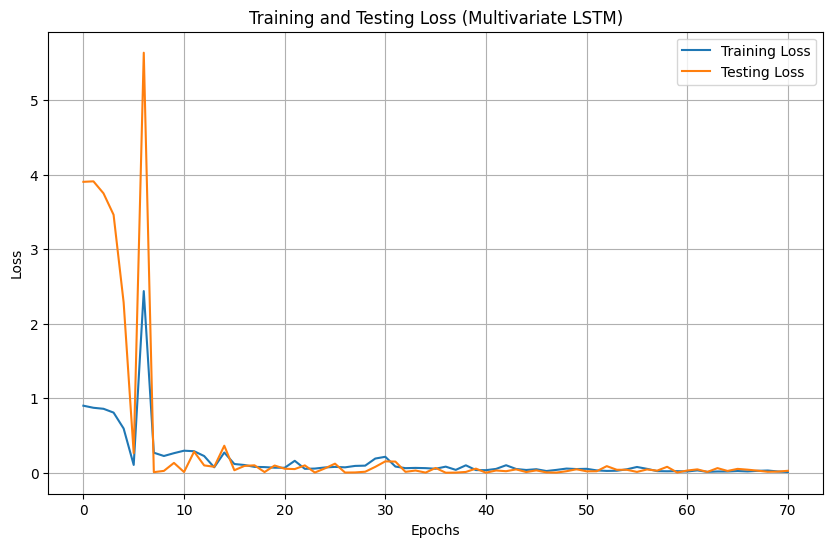

In [479]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.title('Training and Testing Loss (Multivariate LSTM)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

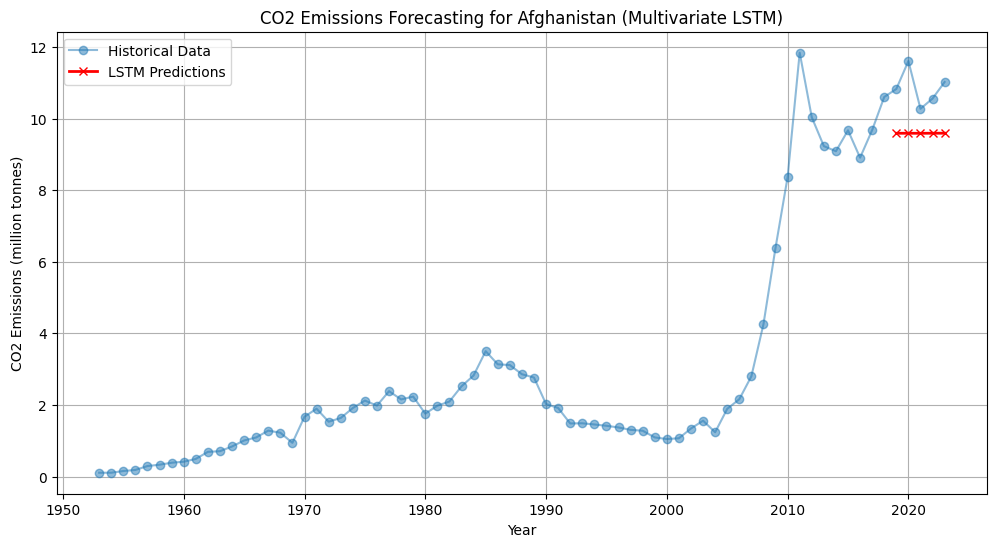

Test MSE: 1.8102
Test RMSE: 1.3454
Test MAE: 1.2675
Test R²: -7.8718
Test MAPE: 11.52%
Test SMAPE: 12.31%

Predictions vs Actual:
   Year  Actual CO2  Predicted CO2     Error  Percentage Error
0  2019   10.824999       9.587868  1.237131         11.428464
1  2020   11.606002       9.588938  2.017064         17.379492
2  2021   10.272000       9.587320  0.684680          6.665498
3  2022   10.557999       9.589549  0.968450          9.172663
4  2023   11.019999       9.589811  1.430187         12.978106


In [480]:
# Make predictions
model.eval()
with torch.no_grad():
    test_predictions = []
    for inputs, _ in test_loader:
        output = model(inputs)
        # Move output back to CPU for numpy operations
        test_predictions.append(output.cpu().numpy())

# Convert predictions back to original scale
test_predictions = np.array(test_predictions).reshape(-1, 1)

# First, inverse transform from standardized scale to log scale
test_predictions_log = test_predictions
for i, col in enumerate(['log_co2']):
    idx = log_cols.index(col)
    # Extract the mean and std used by the scaler
    mean = log_standard_scaler.mean_[idx]
    std = log_standard_scaler.scale_[idx]
    # Inverse transform manually
    test_predictions_log = test_predictions_log * std + mean

# Then, convert from log scale to original CO2 scale
test_predictions_original = np.expm1(test_predictions_log)  # expm1 = exp(x) - 1

# Get the actual test values and convert back to original scale
y_test_actual = y_test.cpu().numpy().reshape(-1, 1)  # Move back to CPU

# First, inverse transform from standardized to log scale
y_test_log = y_test_actual
for i, col in enumerate(['log_co2']):
    idx = log_cols.index(col)
    # Extract the mean and std used by the scaler
    mean = log_standard_scaler.mean_[idx]
    std = log_standard_scaler.scale_[idx]
    # Inverse transform manually
    y_test_log = y_test_log * std + mean

# Then, convert from log scale to original scale
y_test_original = np.expm1(y_test_log)

# Get the corresponding years for plotting
test_years = df['year'].values[train_size + seq_length:train_size + seq_length + len(test_predictions)]

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(df['year'], df['co2'], label='Historical Data', marker='o', alpha=0.5)
plt.plot(test_years, test_predictions_original, label='LSTM Predictions', marker='x', color='red', linewidth=2)
plt.title('CO2 Emissions Forecasting for Afghanistan (Multivariate LSTM)')
plt.xlabel('Year')
plt.ylabel('CO2 Emissions (million tonnes)')
plt.legend()
plt.grid(True)
plt.show()

# Calculate error metrics on the original scale
mse = mean_squared_error(y_test_original, test_predictions_original)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_original, test_predictions_original)
r2 = r2_score(y_test_original, test_predictions_original)

# Calculate percentage error metrics
mape = np.mean(np.abs((y_test_original - test_predictions_original) / y_test_original)) * 100
smape = np.mean(2 * np.abs(y_test_original - test_predictions_original) / (np.abs(y_test_original) + np.abs(test_predictions_original))) * 100

print(f'Test MSE: {mse:.4f}')
print(f'Test RMSE: {rmse:.4f}')
print(f'Test MAE: {mae:.4f}')
print(f'Test R²: {r2:.4f}')
print(f'Test MAPE: {mape:.2f}%')
print(f'Test SMAPE: {smape:.2f}%')

# Print the predictions vs actual values
results_df = pd.DataFrame({
    'Year': test_years,
    'Actual CO2': y_test_original.flatten(),
    'Predicted CO2': test_predictions_original.flatten(),
    'Error': (y_test_original - test_predictions_original).flatten(),
    'Percentage Error': (np.abs((y_test_original - test_predictions_original) / y_test_original) * 100).flatten()
})
print("\nPredictions vs Actual:")
print(results_df)

In [481]:
# Standard GRU Model
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # GRU layer - often better with vanishing gradients than standard LSTM
        self.gru = nn.GRU(input_size, hidden_size, num_layers, 
                          batch_first=True, dropout=dropout if num_layers > 1 else 0)
        
        # Fully connected layers
        self.fc1 = nn.Linear(hidden_size, hidden_size//2)
        self.leaky_relu = nn.LeakyReLU(0.1)  # LeakyReLU instead of ReLU
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_size//2, output_size)
        
        # Initialize weights for better gradient flow
        self._initialize_weights()
        
    def _initialize_weights(self):
        for name, param in self.named_parameters():
            if 'weight_ih' in name or 'weight_hh' in name:
                nn.init.orthogonal_(param)
            elif 'bias' in name:
                nn.init.constant_(param, 0.0)
                
    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate GRU
        gru_out, _ = self.gru(x, h0)
        
        # Use the output from the last time step
        out = gru_out[:, -1, :]
        
        # Process through fully connected layers
        out = self.fc1(out)
        out = self.leaky_relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        
        return out

In [482]:
input_size = X.shape[2]  # Number of features
hidden_size=256
num_layers = 5
output_size = 1
dropout = 0.2  # Slightly increased dropout for regularization

# Create model and move to device
model = GRUModel(input_size, hidden_size, num_layers, output_size, dropout).to(device)

In [483]:

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # Added L2 regularization
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=15, verbose=True)

# Train the model
num_epochs = 200  # Increased epochs
train_losses = []
test_losses = []

# Early stopping parameters
patience =30
best_loss = float('inf')
counter = 0

# Add timing to monitor performance
start_time = time.time()

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        running_loss += loss.item()
    
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    
    # Testing phase
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
    
    test_loss = test_loss / len(test_loader)
    test_losses.append(test_loss)
    
    # Update learning rate
    scheduler.step(test_loss)
    
    # Early stopping check
    if test_loss < best_loss:
        best_loss = test_loss
        counter = 0
        # Save the best model
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': epoch,
            'loss': best_loss,
        }, 'afghanistan_co2_best_model.pth')
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    # Print progress
    if (epoch+1) % 20 == 0:
        elapsed = time.time() - start_time
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}, Time: {elapsed:.2f}s')

print(f"Total training time: {time.time() - start_time:.2f} seconds")

Epoch [20/200], Train Loss: 0.122944, Test Loss: 0.159675, Time: 4.21s
Epoch [40/200], Train Loss: 0.025535, Test Loss: 0.005033, Time: 8.41s
Early stopping at epoch 56
Total training time: 11.79 seconds


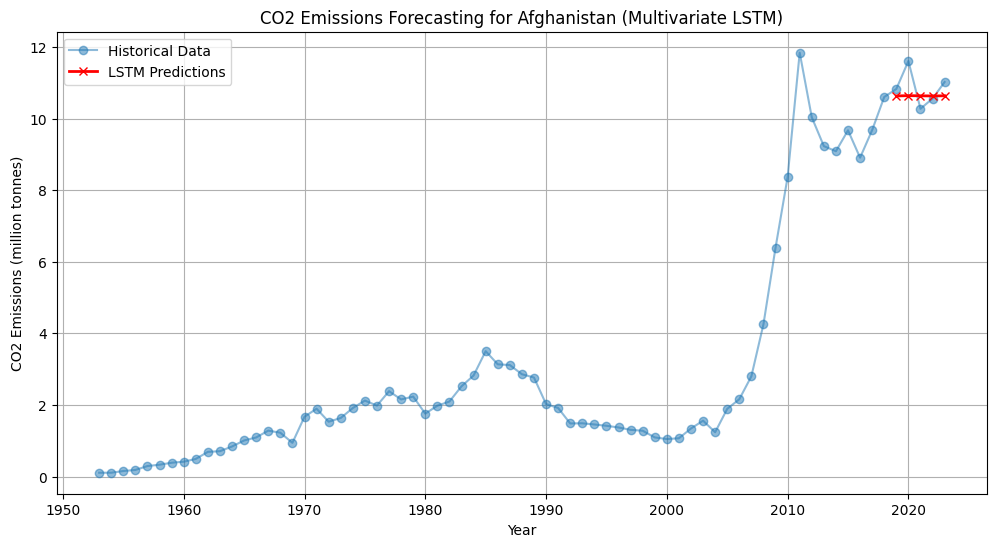

Test MSE: 0.2516
Test RMSE: 0.5016
Test MAE: 0.3964
Test R²: -0.2329
Test MAPE: 3.57%
Test SMAPE: 3.64%

Predictions vs Actual:
   Year  Actual CO2  Predicted CO2     Error  Percentage Error
0  2019   10.824999      10.629990  0.195009          1.801471
1  2020   11.606002      10.639127  0.966875          8.330820
2  2021   10.272000      10.634233 -0.362232          3.526404
3  2022   10.557999      10.630625 -0.072626          0.687878
4  2023   11.019999      10.634632  0.385366          3.496974


In [484]:
# Make predictions
model.eval()
with torch.no_grad():
    test_predictions = []
    for inputs, _ in test_loader:
        output = model(inputs)
        # Move output back to CPU for numpy operations
        test_predictions.append(output.cpu().numpy())

# Convert predictions back to original scale
test_predictions = np.array(test_predictions).reshape(-1, 1)

# First, inverse transform from standardized scale to log scale
test_predictions_log = test_predictions
for i, col in enumerate(['log_co2']):
    idx = log_cols.index(col)
    # Extract the mean and std used by the scaler
    mean = log_standard_scaler.mean_[idx]
    std = log_standard_scaler.scale_[idx]
    # Inverse transform manually
    test_predictions_log = test_predictions_log * std + mean

# Then, convert from log scale to original CO2 scale
test_predictions_original = np.expm1(test_predictions_log)  # expm1 = exp(x) - 1

# Get the actual test values and convert back to original scale
y_test_actual = y_test.cpu().numpy().reshape(-1, 1)  # Move back to CPU

# First, inverse transform from standardized to log scale
y_test_log = y_test_actual
for i, col in enumerate(['log_co2']):
    idx = log_cols.index(col)
    # Extract the mean and std used by the scaler
    mean = log_standard_scaler.mean_[idx]
    std = log_standard_scaler.scale_[idx]
    # Inverse transform manually
    y_test_log = y_test_log * std + mean

# Then, convert from log scale to original scale
y_test_original = np.expm1(y_test_log)

# Get the corresponding years for plotting
test_years = df['year'].values[train_size + seq_length:train_size + seq_length + len(test_predictions)]

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(df['year'], df['co2'], label='Historical Data', marker='o', alpha=0.5)
plt.plot(test_years, test_predictions_original, label='LSTM Predictions', marker='x', color='red', linewidth=2)
plt.title('CO2 Emissions Forecasting for Afghanistan (Multivariate LSTM)')
plt.xlabel('Year')
plt.ylabel('CO2 Emissions (million tonnes)')
plt.legend()
plt.grid(True)
plt.show()

# Calculate error metrics on the original scale
mse = mean_squared_error(y_test_original, test_predictions_original)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_original, test_predictions_original)
r2 = r2_score(y_test_original, test_predictions_original)

# Calculate percentage error metrics
mape = np.mean(np.abs((y_test_original - test_predictions_original) / y_test_original)) * 100
smape = np.mean(2 * np.abs(y_test_original - test_predictions_original) / (np.abs(y_test_original) + np.abs(test_predictions_original))) * 100

print(f'Test MSE: {mse:.4f}')
print(f'Test RMSE: {rmse:.4f}')
print(f'Test MAE: {mae:.4f}')
print(f'Test R²: {r2:.4f}')
print(f'Test MAPE: {mape:.2f}%')
print(f'Test SMAPE: {smape:.2f}%')

# Print the predictions vs actual values
results_df = pd.DataFrame({
    'Year': test_years,
    'Actual CO2': y_test_original.flatten(),
    'Predicted CO2': test_predictions_original.flatten(),
    'Error': (y_test_original - test_predictions_original).flatten(),
    'Percentage Error': (np.abs((y_test_original - test_predictions_original) / y_test_original) * 100).flatten()
})
print("\nPredictions vs Actual:")
print(results_df)